In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import (get_pu_weights_function,
                                          get_ttbar_weight,
                                          get_nlo_weight_function)

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

load datasets

In [2]:
import json

########## backgrounds ##########
bkgdatasets_=json.load(open('../../MC/Samples/backgrounds_nonempty.json'))
bkgscales_=json.load(open('../../MC/Samples/backgrounds_scale.json'))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open('../Samples/control_data2018.json'))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

data/MC re

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

plotopts

In [4]:
# common plotting options

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

# separate by types

In [5]:
ptbinning = np.concatenate([np.arange(0, 400, 10),
                           np.arange(400, 600, 20),
                           np.arange(600, 800, 50)])
massbinning = np.concatenate([np.arange(0, 40, 2),
                             np.arange(40, 100, 5)])

In [6]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", ptbinning)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        label_axis    = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis, label_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, label_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, label_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, label_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, label_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, label_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, label_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, label_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, label_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, label_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, label_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis, label_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis, label_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis, label_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, label_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(awkward.fromiter(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=absd0.max().content,
            mind0=absd0.min().content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        leptonjets_ = dileptonjets[controlregion]
        wgt = wgt[controlregion]
        wgts= (leptonjets_.pt.ones_like()*wgt).flatten()

        output['pt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(),
                          label=leptonjets_.label.flatten(), weight=wgts)
        output['eta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(),
                           label=leptonjets_.label.flatten(), weight=wgts)
        output['nef'].fill(dataset=dataset, nef=leptonjets_.nef.flatten(),
                           label=leptonjets_.label.flatten(), weight=wgts)
        output['maxd0'].fill(dataset=dataset, maxd0=leptonjets_.maxd0.flatten(),
                             label=leptonjets_.label.flatten(), weight=wgts)
        output['mind0'].fill(dataset=dataset, mind0=leptonjets_.mind0.flatten(),
                             label=leptonjets_.label.flatten(), weight=wgts)
        output['tkiso'].fill(dataset=dataset, tkiso=leptonjets_.tkiso.flatten(),
                             label=leptonjets_.label.flatten(), weight=wgts)
        output['pfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(),
                             label=leptonjets_.label.flatten(), weight=wgts)
        output['spreadpt'].fill(dataset=dataset, spreadpt=leptonjets_.spreadpt.flatten(),
                                label=leptonjets_.label.flatten(), weight=wgts)
        output['spreaddr'].fill(dataset=dataset, spreaddr=leptonjets_.spreaddr.flatten(),
                                label=leptonjets_.label.flatten(), weight=wgts)
        output['lamb'].fill(dataset=dataset, lamb=leptonjets_.lamb.flatten(),
                            label=leptonjets_.label.flatten(), weight=wgts)
        output['epsi'].fill(dataset=dataset, epsi=leptonjets_.epsi.flatten(),
                            label=leptonjets_.label.flatten(), weight=wgts)
        output['ecfe1'].fill(dataset=dataset, ecfe1=leptonjets_.ecf1.flatten(),
                             label=leptonjets_.label.flatten(), weight=wgts)
        output['ecfe2'].fill(dataset=dataset, ecfe2=leptonjets_.ecf2.flatten(),
                             label=leptonjets_.label.flatten(), weight=wgts)
        output['ecfe3'].fill(dataset=dataset, ecfe3=leptonjets_.ecf3.flatten(),
                             label=leptonjets_.label.flatten(), weight=wgts)
        output['mva'].fill(dataset=dataset, mva=leptonjets_.mva.flatten(),
                           label=leptonjets_.label.flatten(), weight=wgts)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [24]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [11:50<00:00, 10.25items/s]  


In [12]:
def makeplot(plotvar, title, overflow='over'):
    fig, (axes, raxes) = plt.subplots(2,3,figsize=(24,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(1,2)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(2,3)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(3,4)),
               overlay='cat',
               ax=axes[2],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(3,4)),
               overlay='cat',
               ax=axes[2],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(3,4)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(3,4)).sum('cat'),
                   ax=raxes[2],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')
    for ax in axes:
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('symlog')
        ax.set_xlabel(None)
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[control region] egamma-type leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[control region] pfmu-type leptonjets {title}', x=0.0, ha="left")
    axes[2].set_title(f'[control region] dsamu-type leptonjets {title}', x=0.0, ha="left")

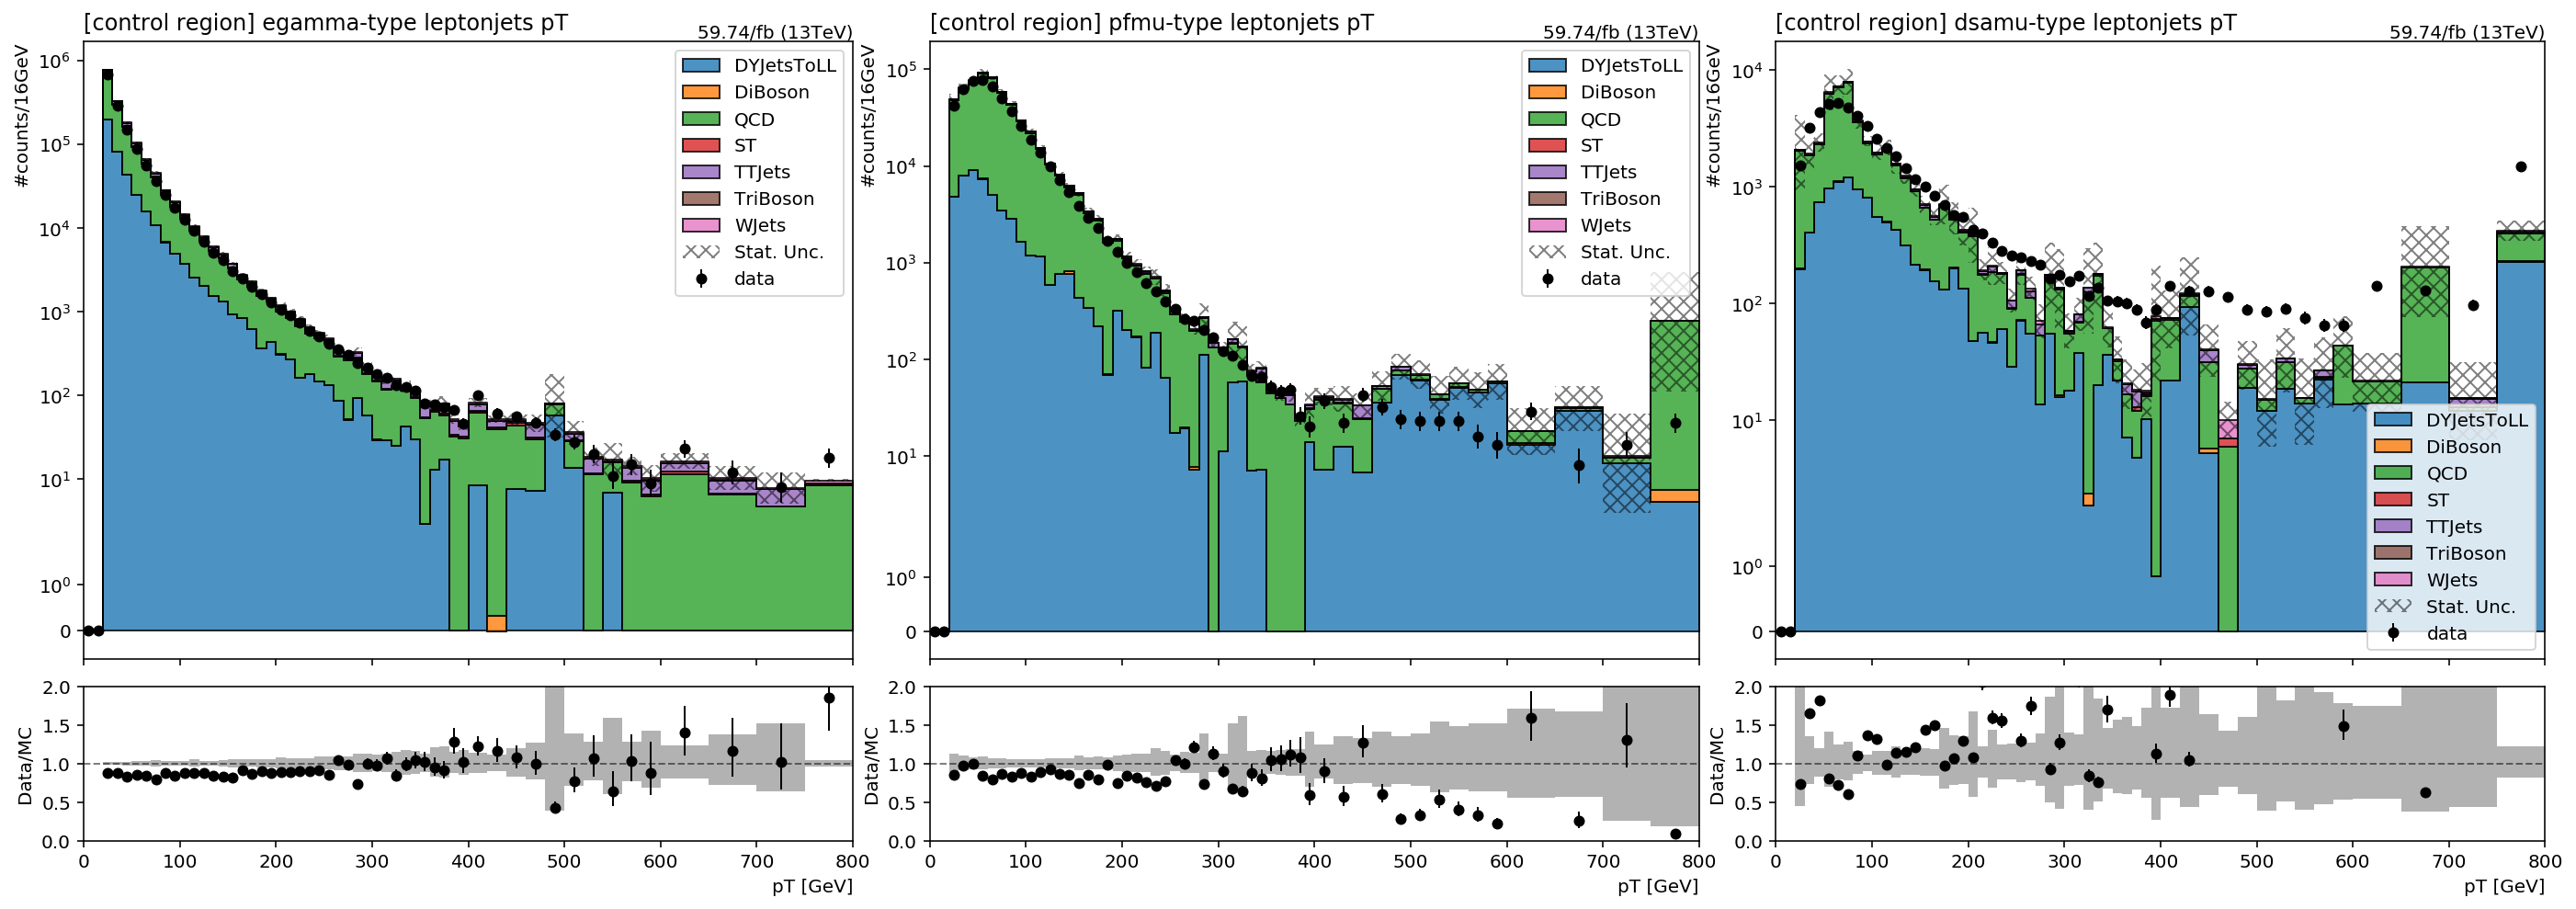

In [25]:
makeplot('pt_cat', 'pT');

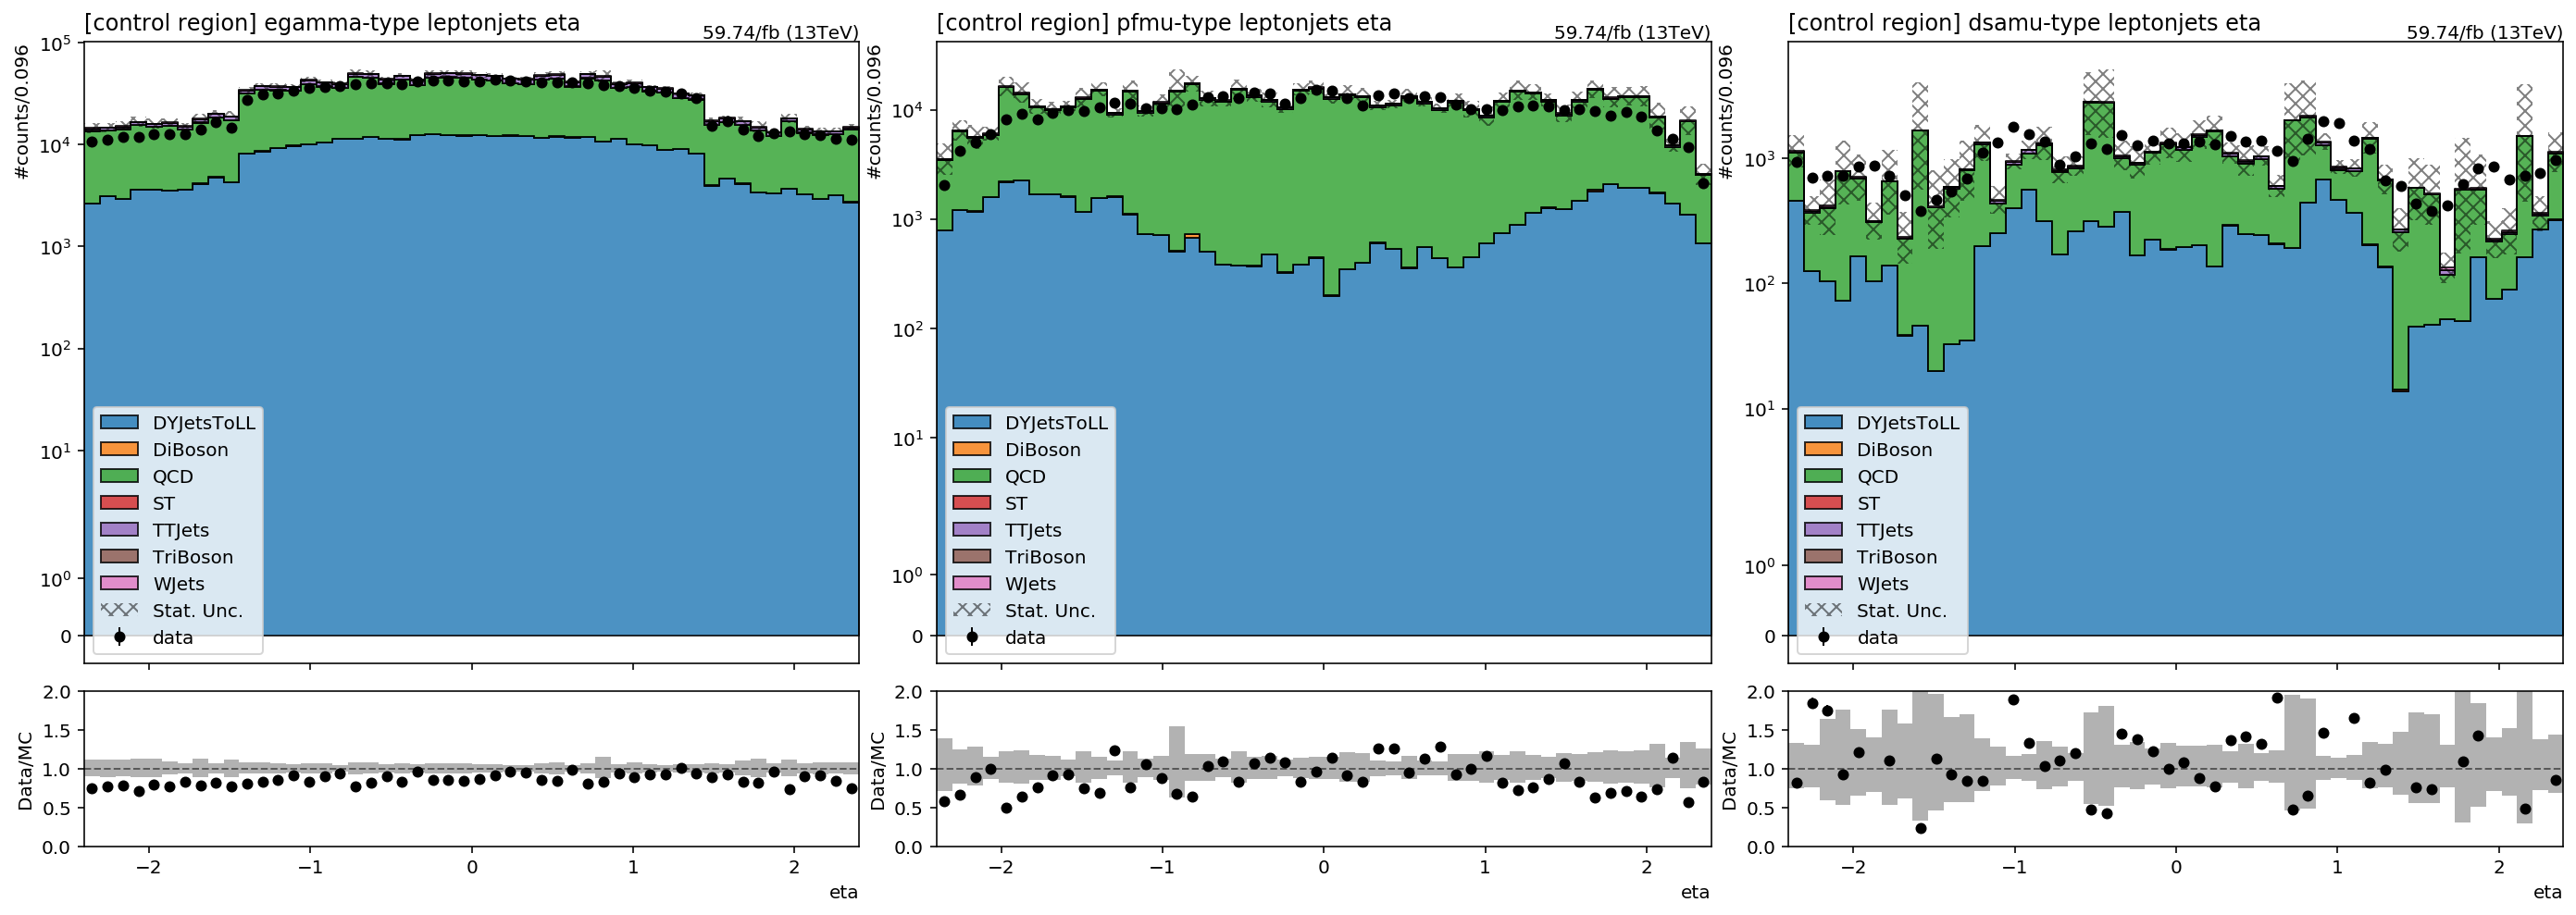

In [26]:
makeplot('eta_cat', 'eta', overflow='none');

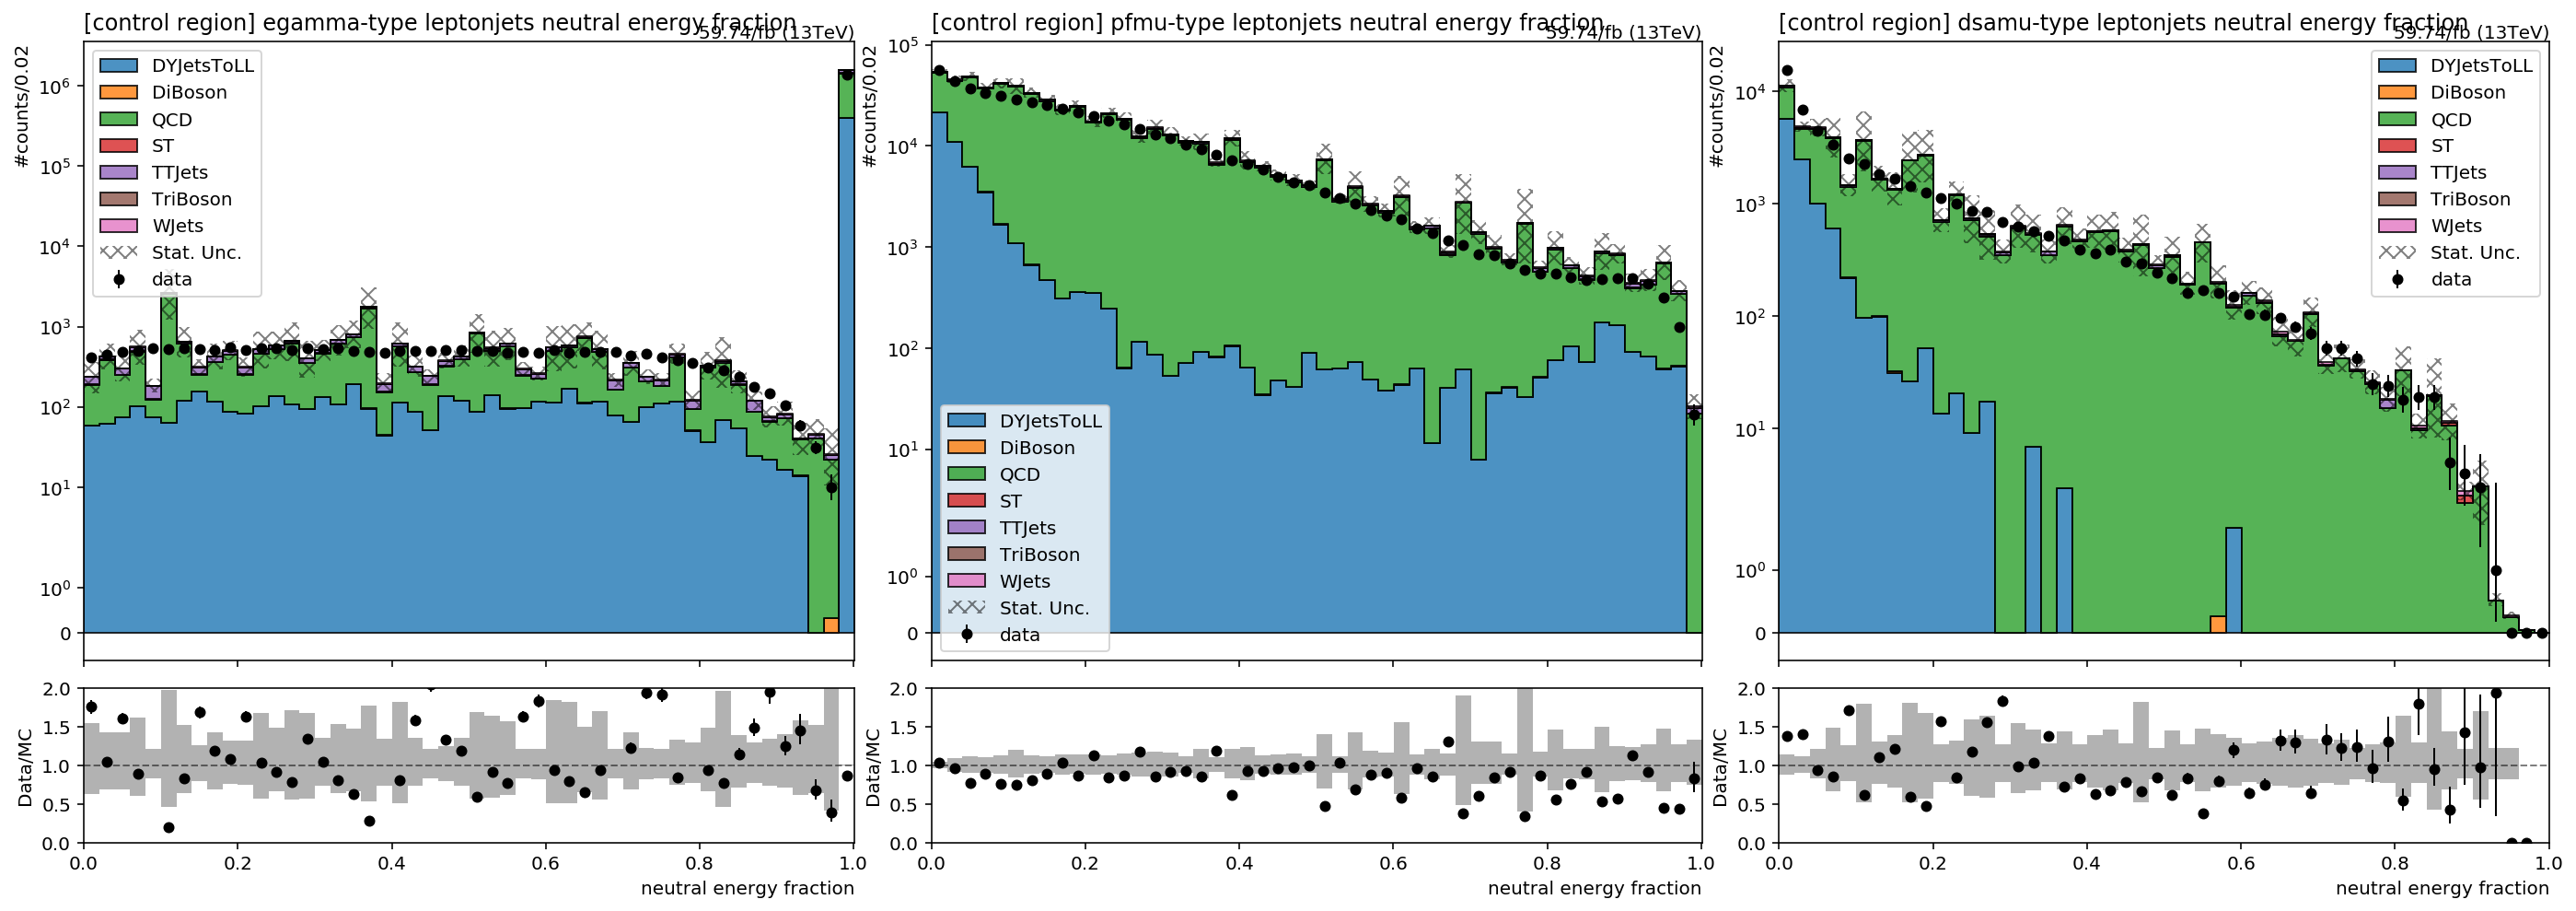

In [27]:
makeplot('nef_cat', 'neutral energy fraction', overflow='none');

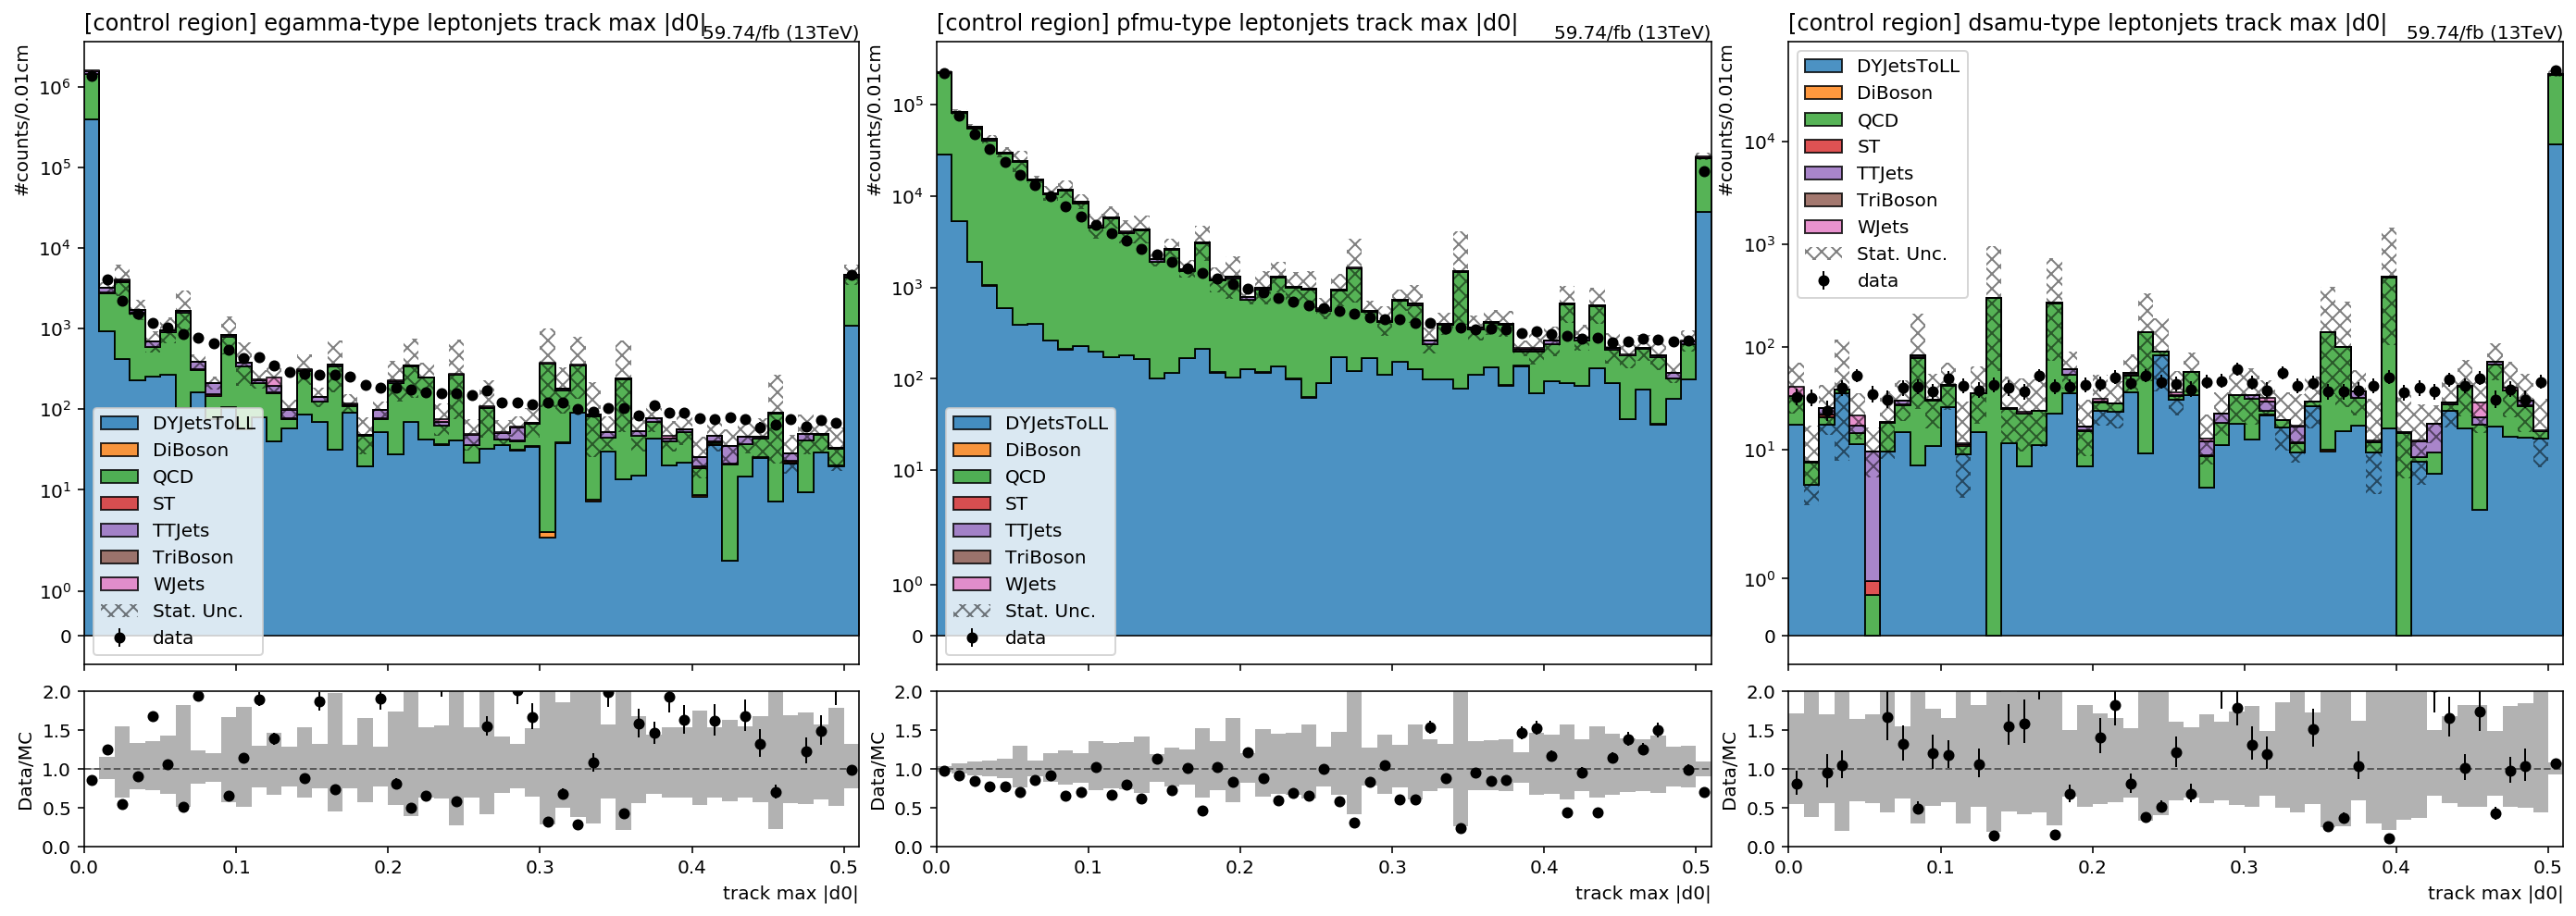

In [28]:
makeplot('maxd0_cat', 'track max |d0|');

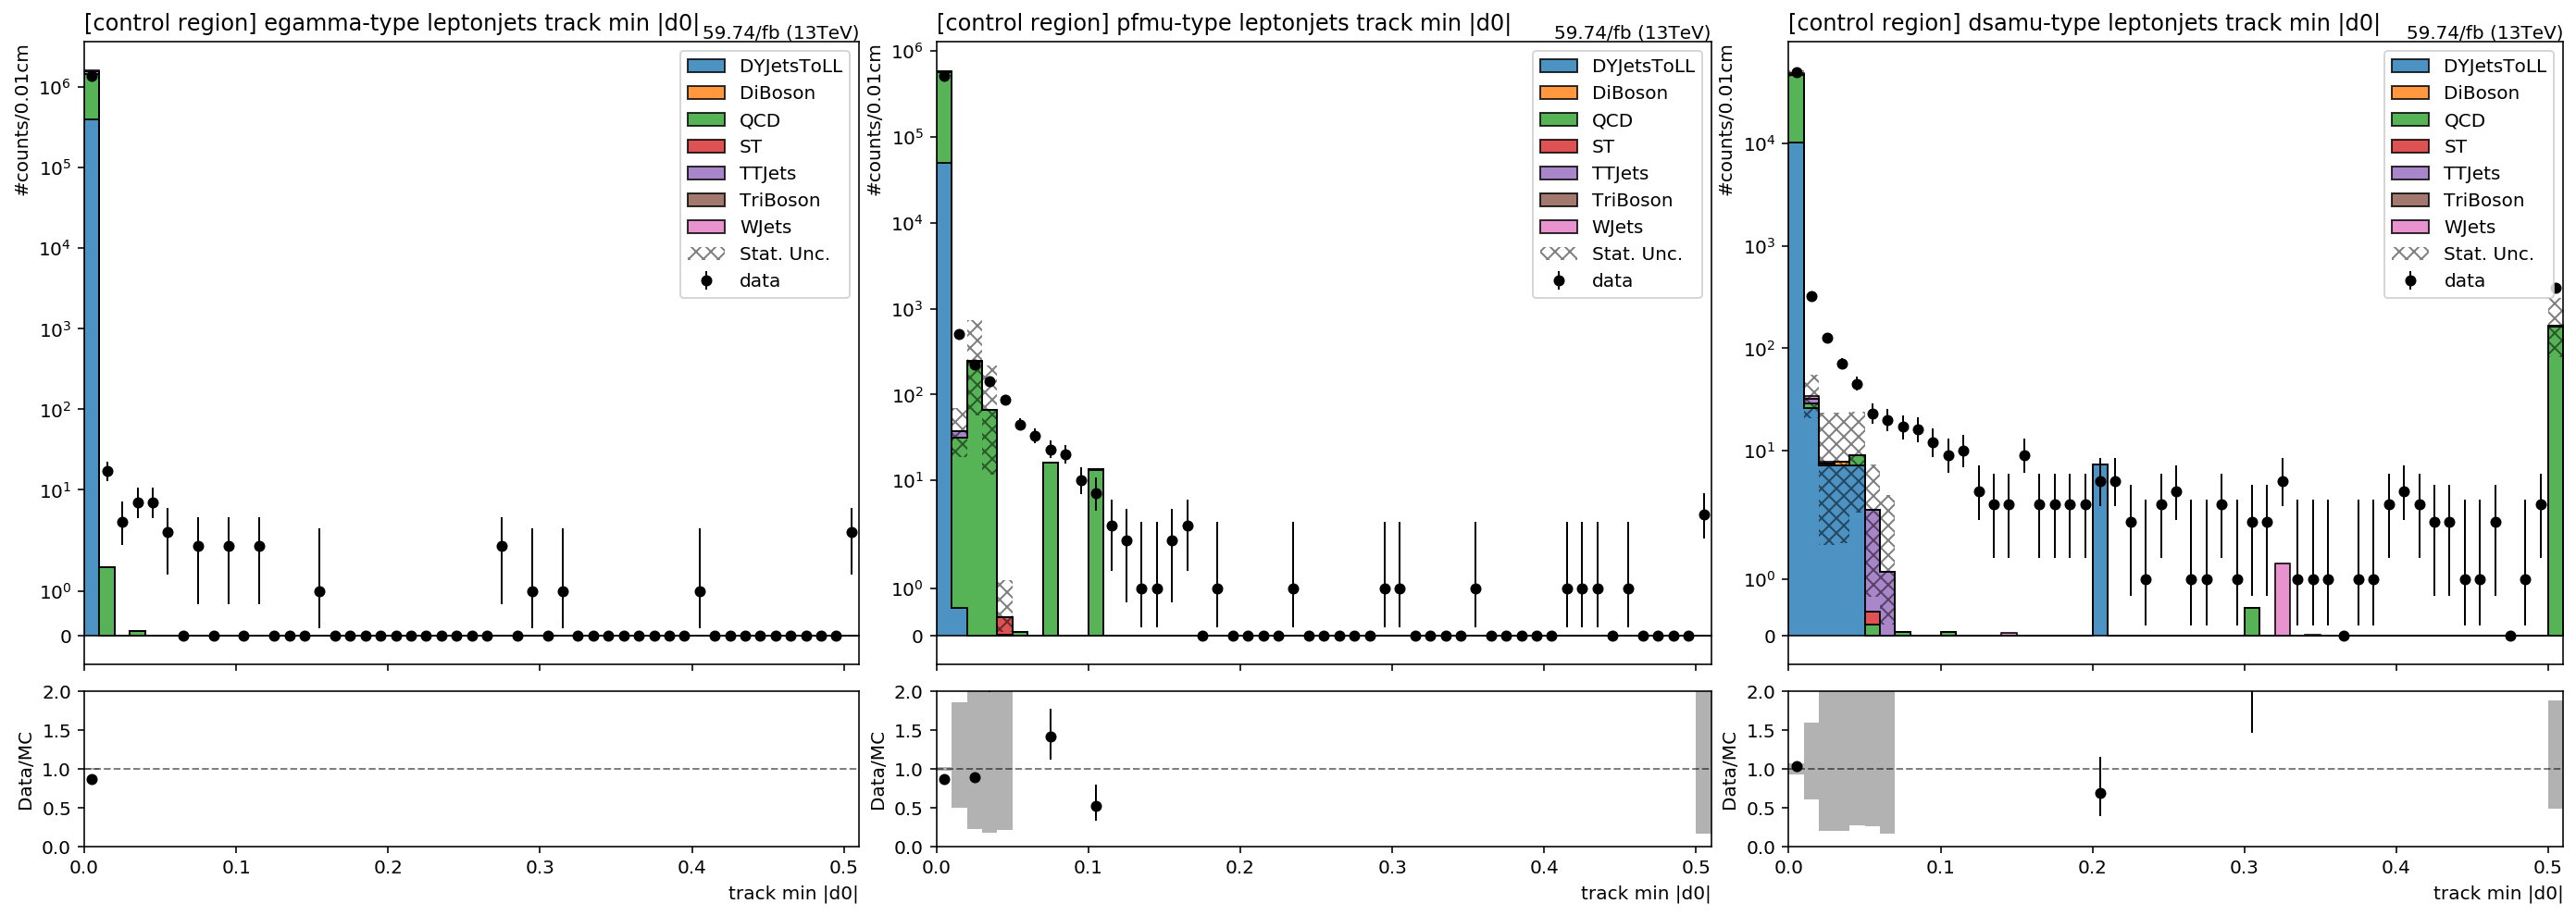

In [29]:
makeplot('mind0_cat', 'track min |d0|');

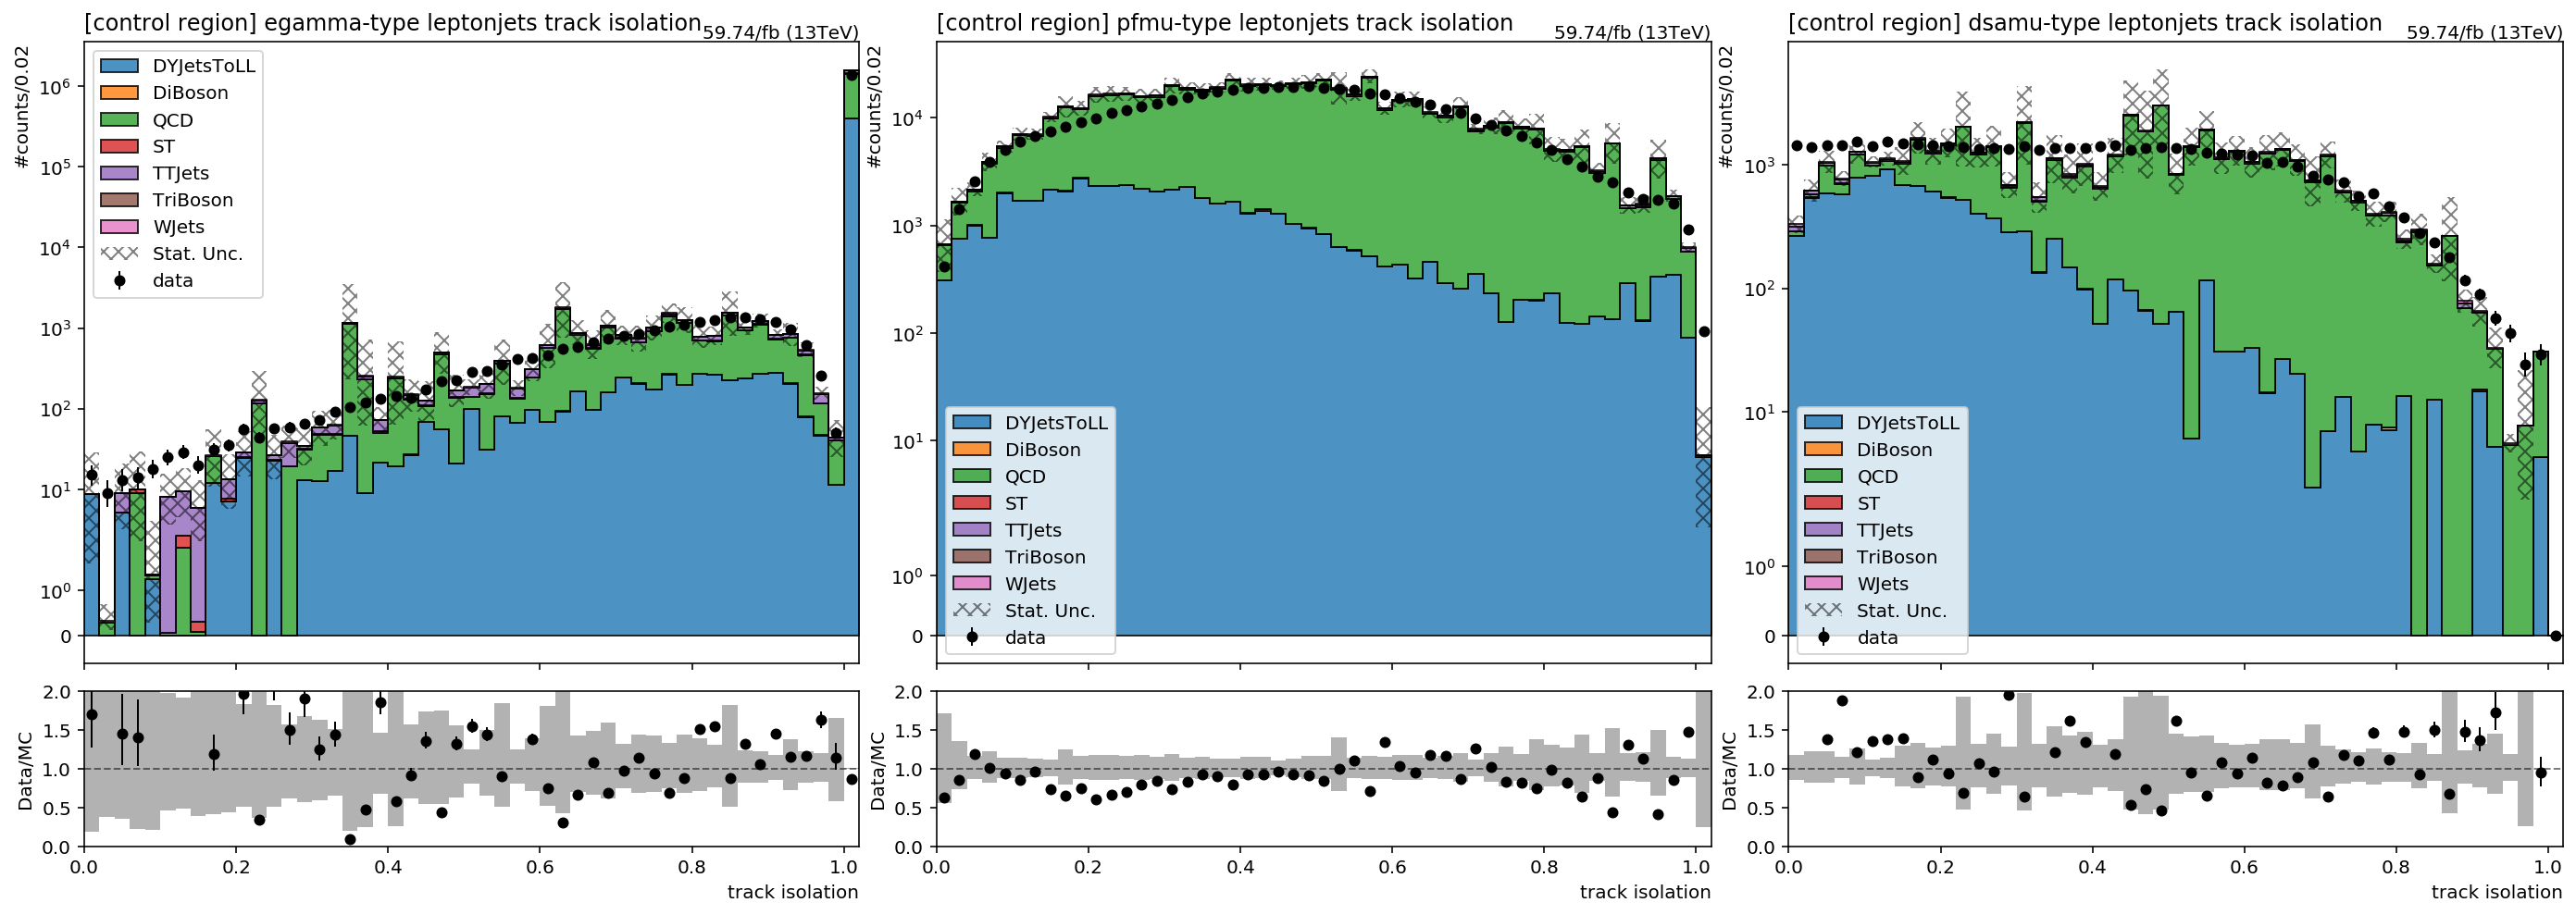

In [30]:
makeplot('tkiso_cat', 'track isolation');

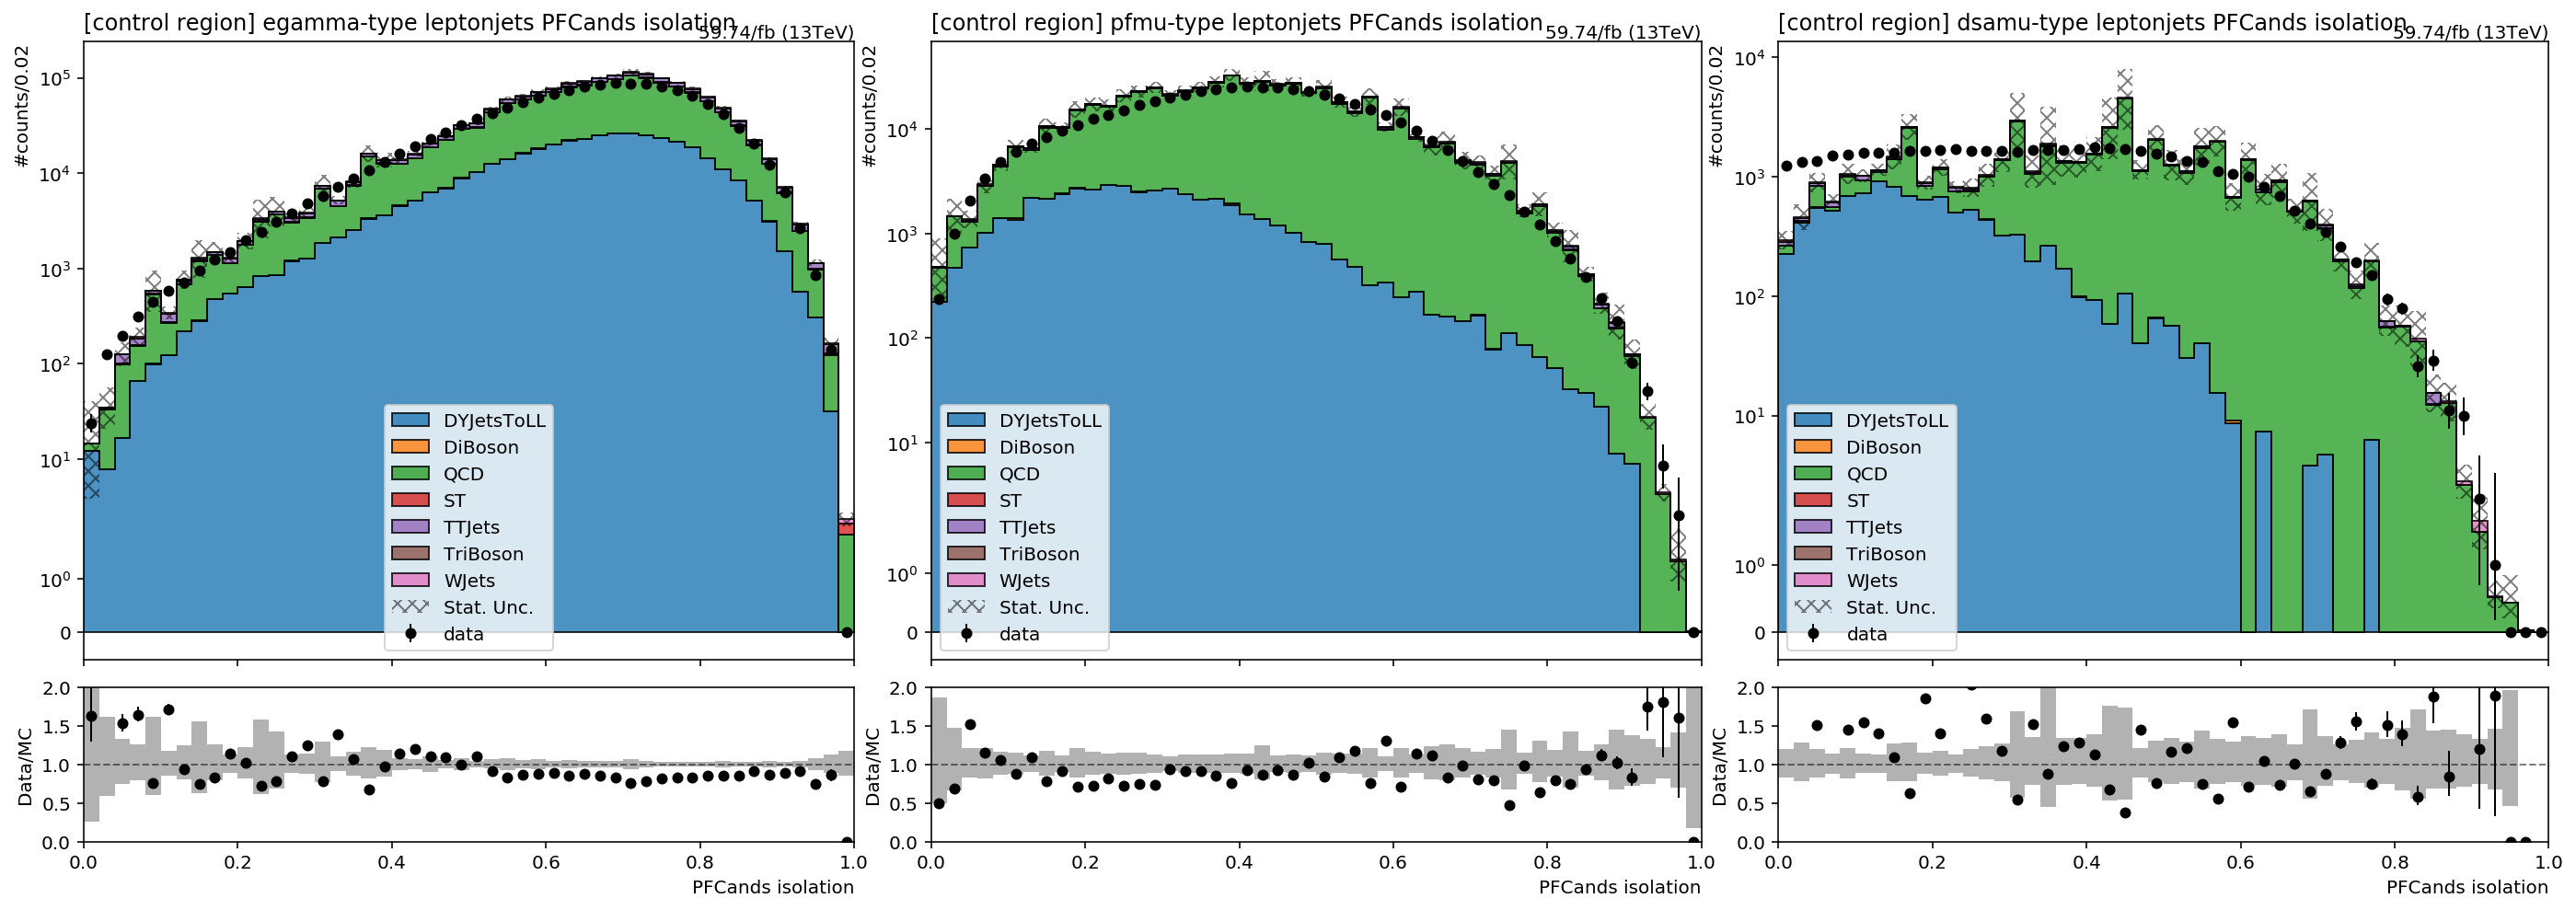

In [31]:
makeplot('pfiso_cat', 'PFCands isolation', overflow='none');

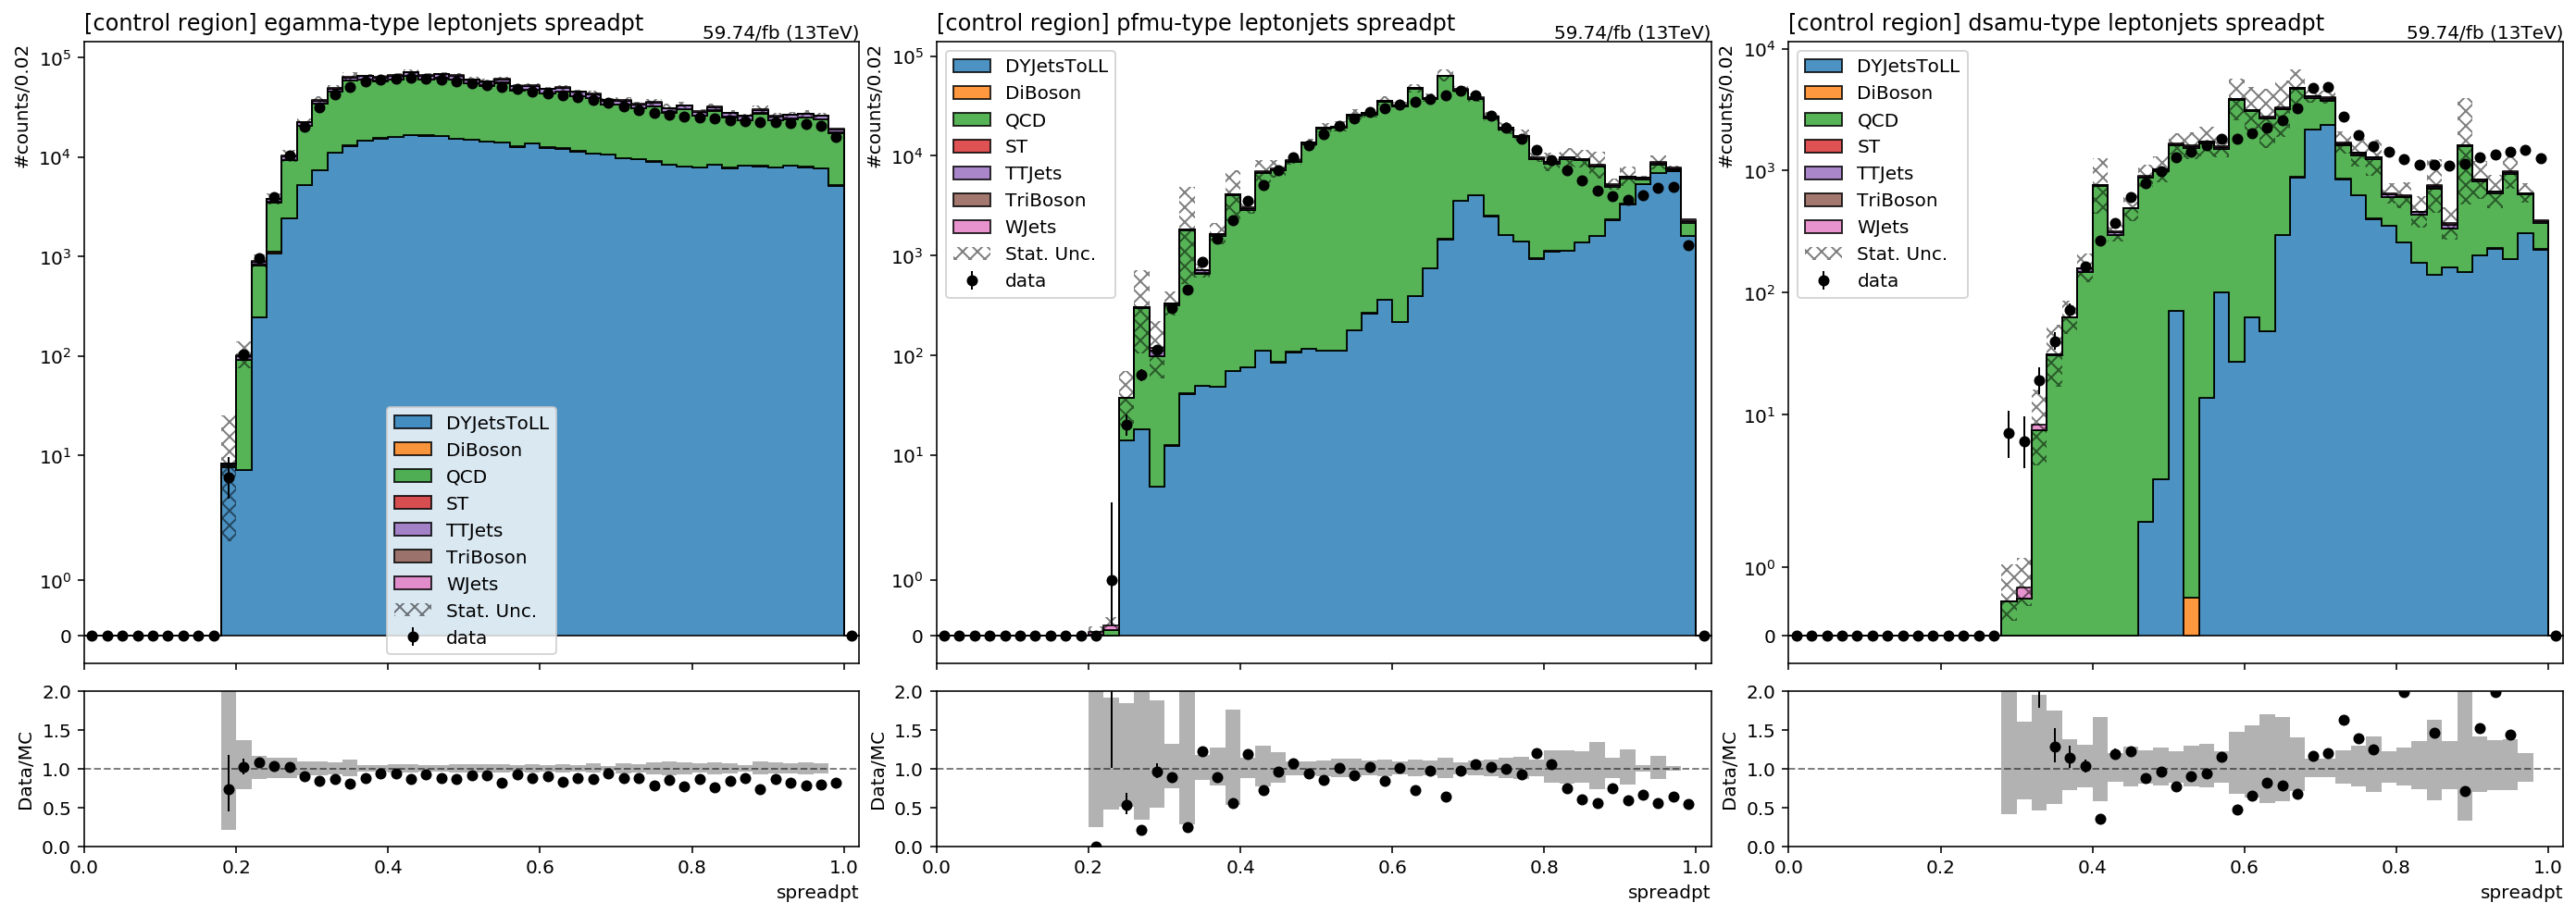

In [32]:
makeplot('spreadpt_cat', 'spreadpt');

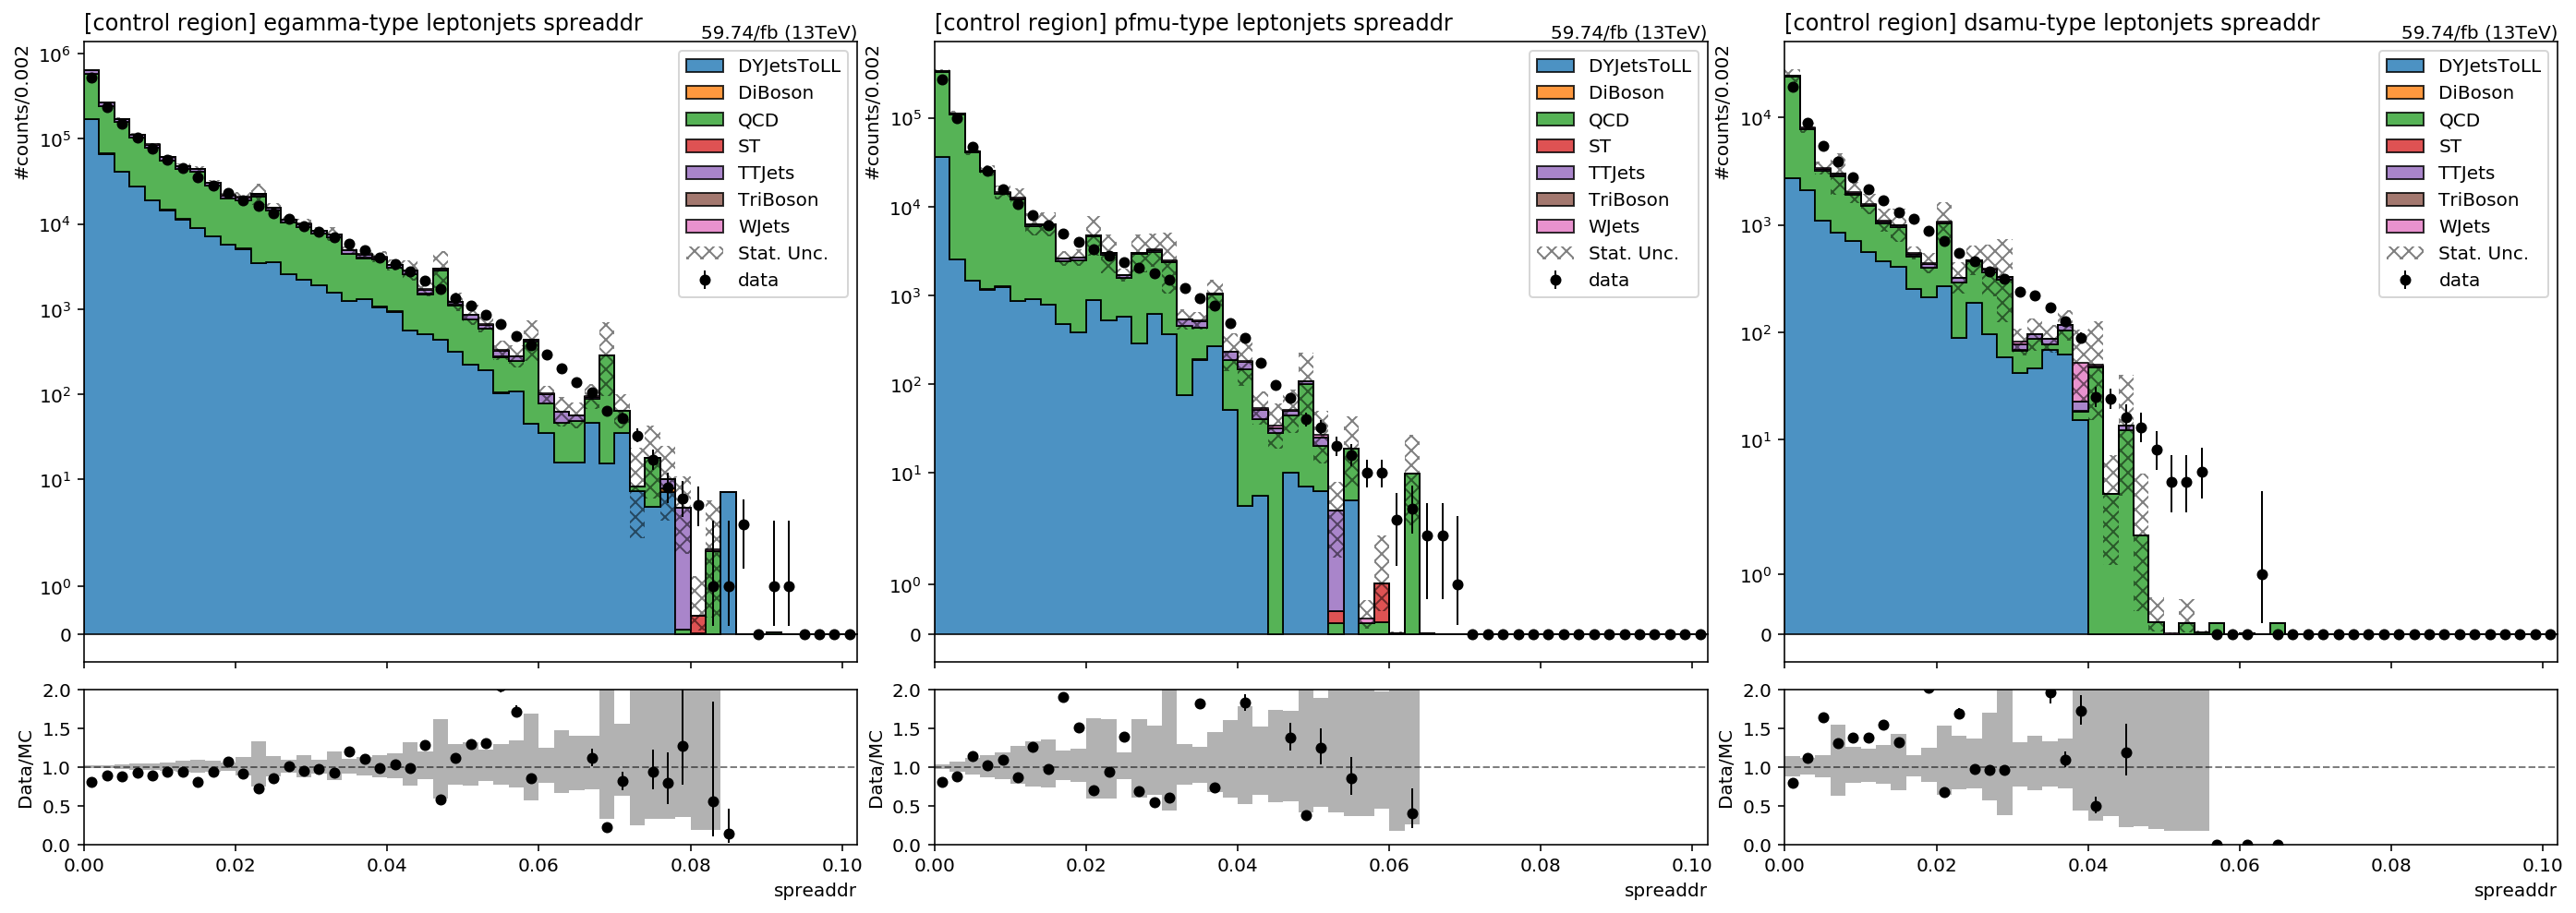

In [33]:
makeplot('spreaddr_cat', 'spreaddr');

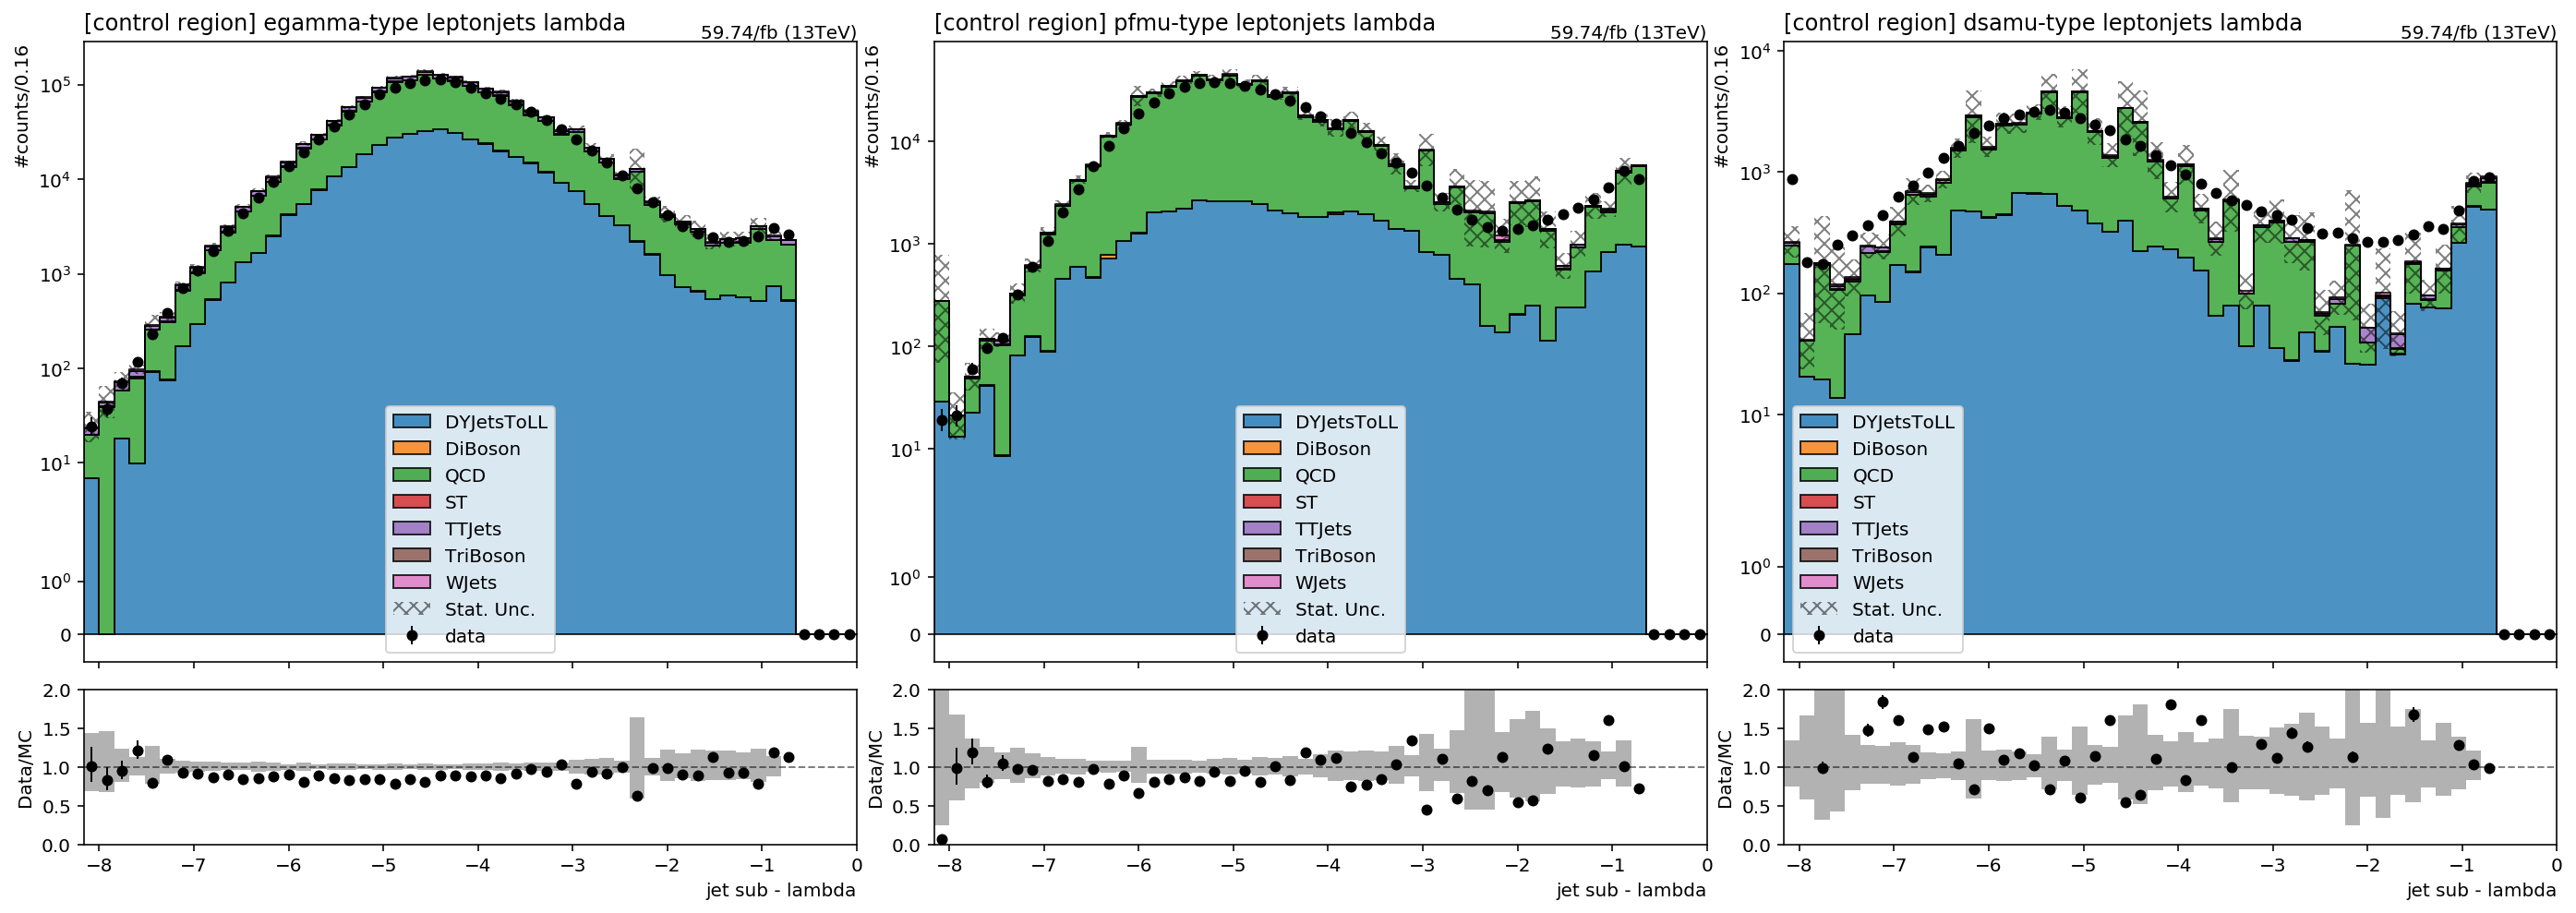

In [34]:
makeplot('lamb_cat', 'lambda', overflow='under');

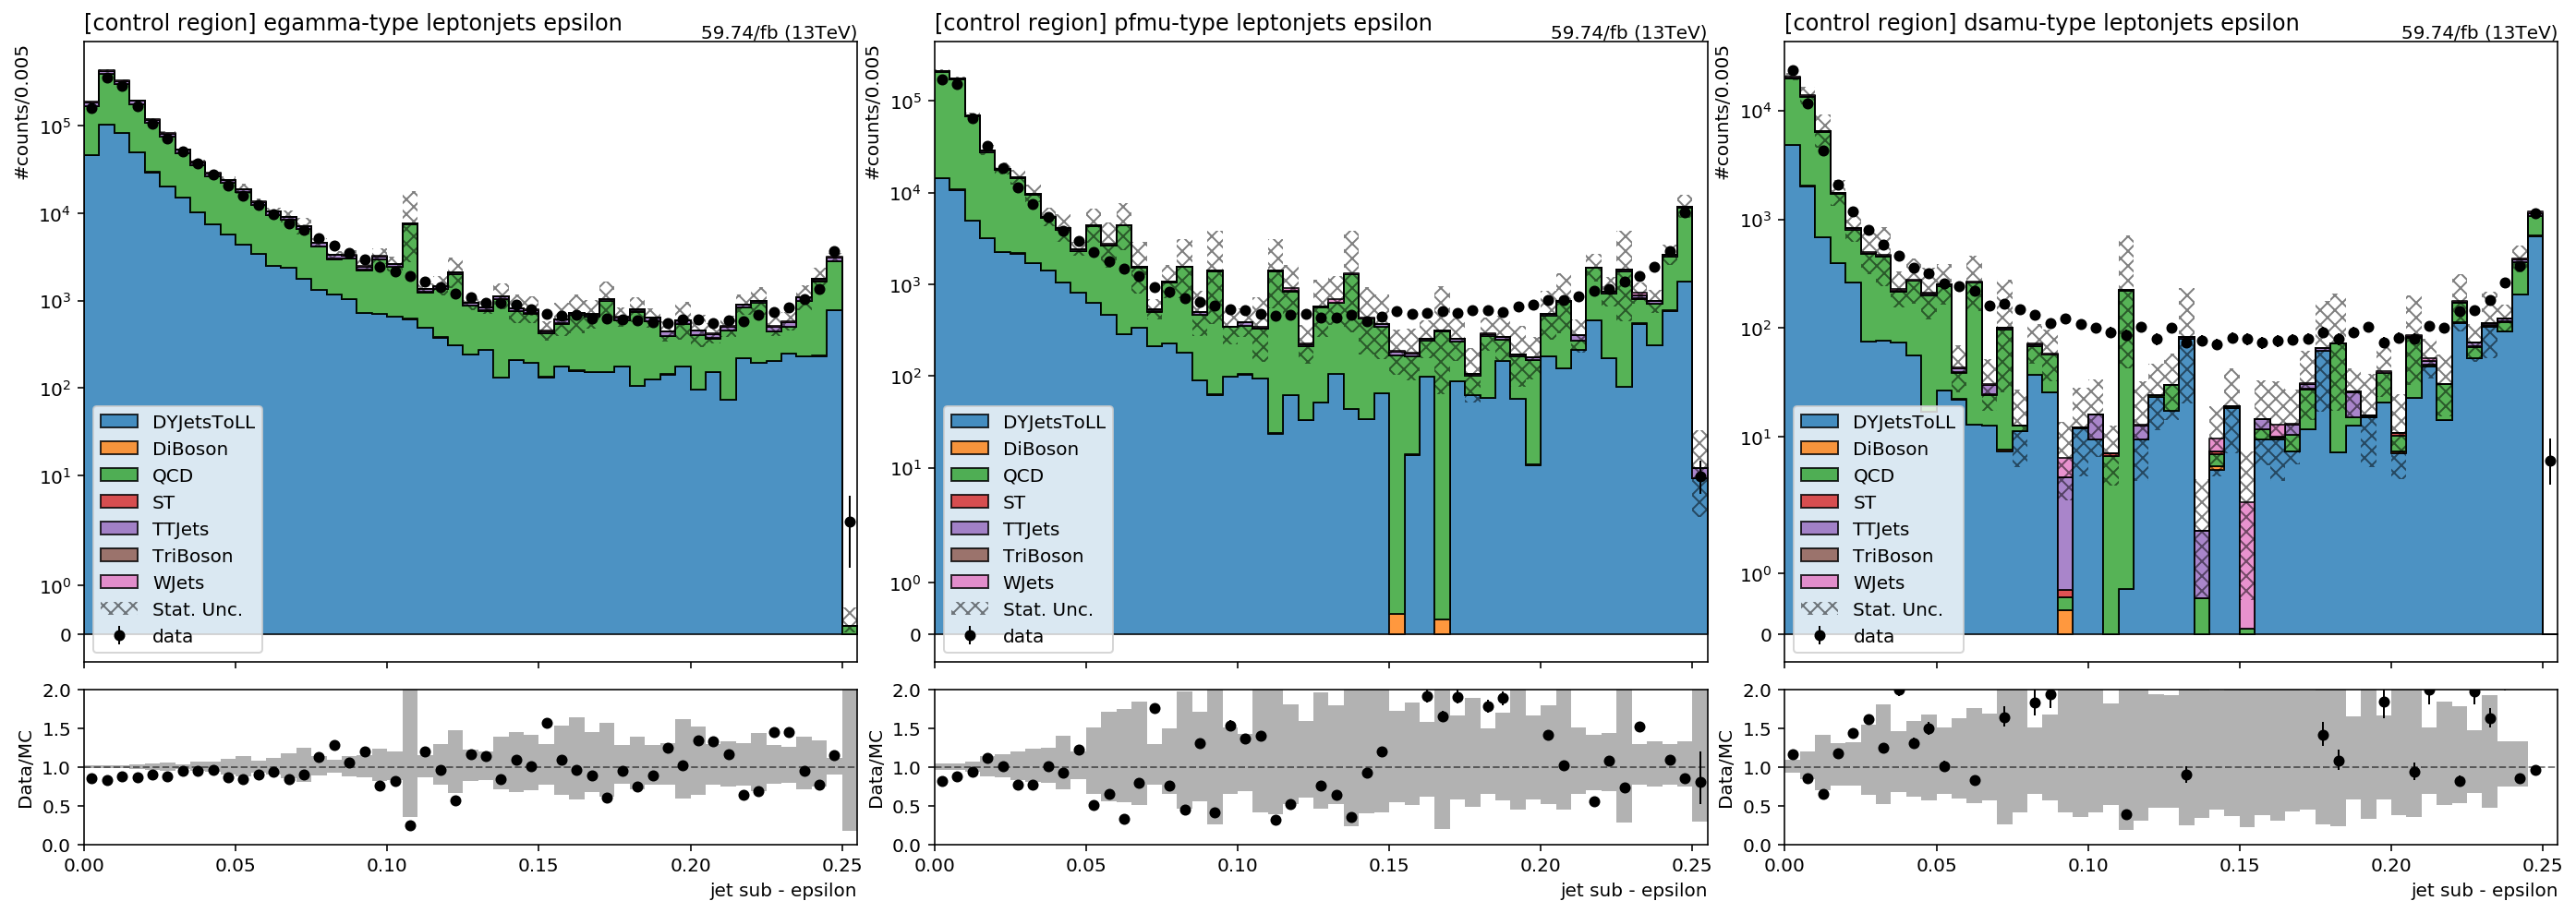

In [35]:
makeplot('epsi_cat', 'epsilon');

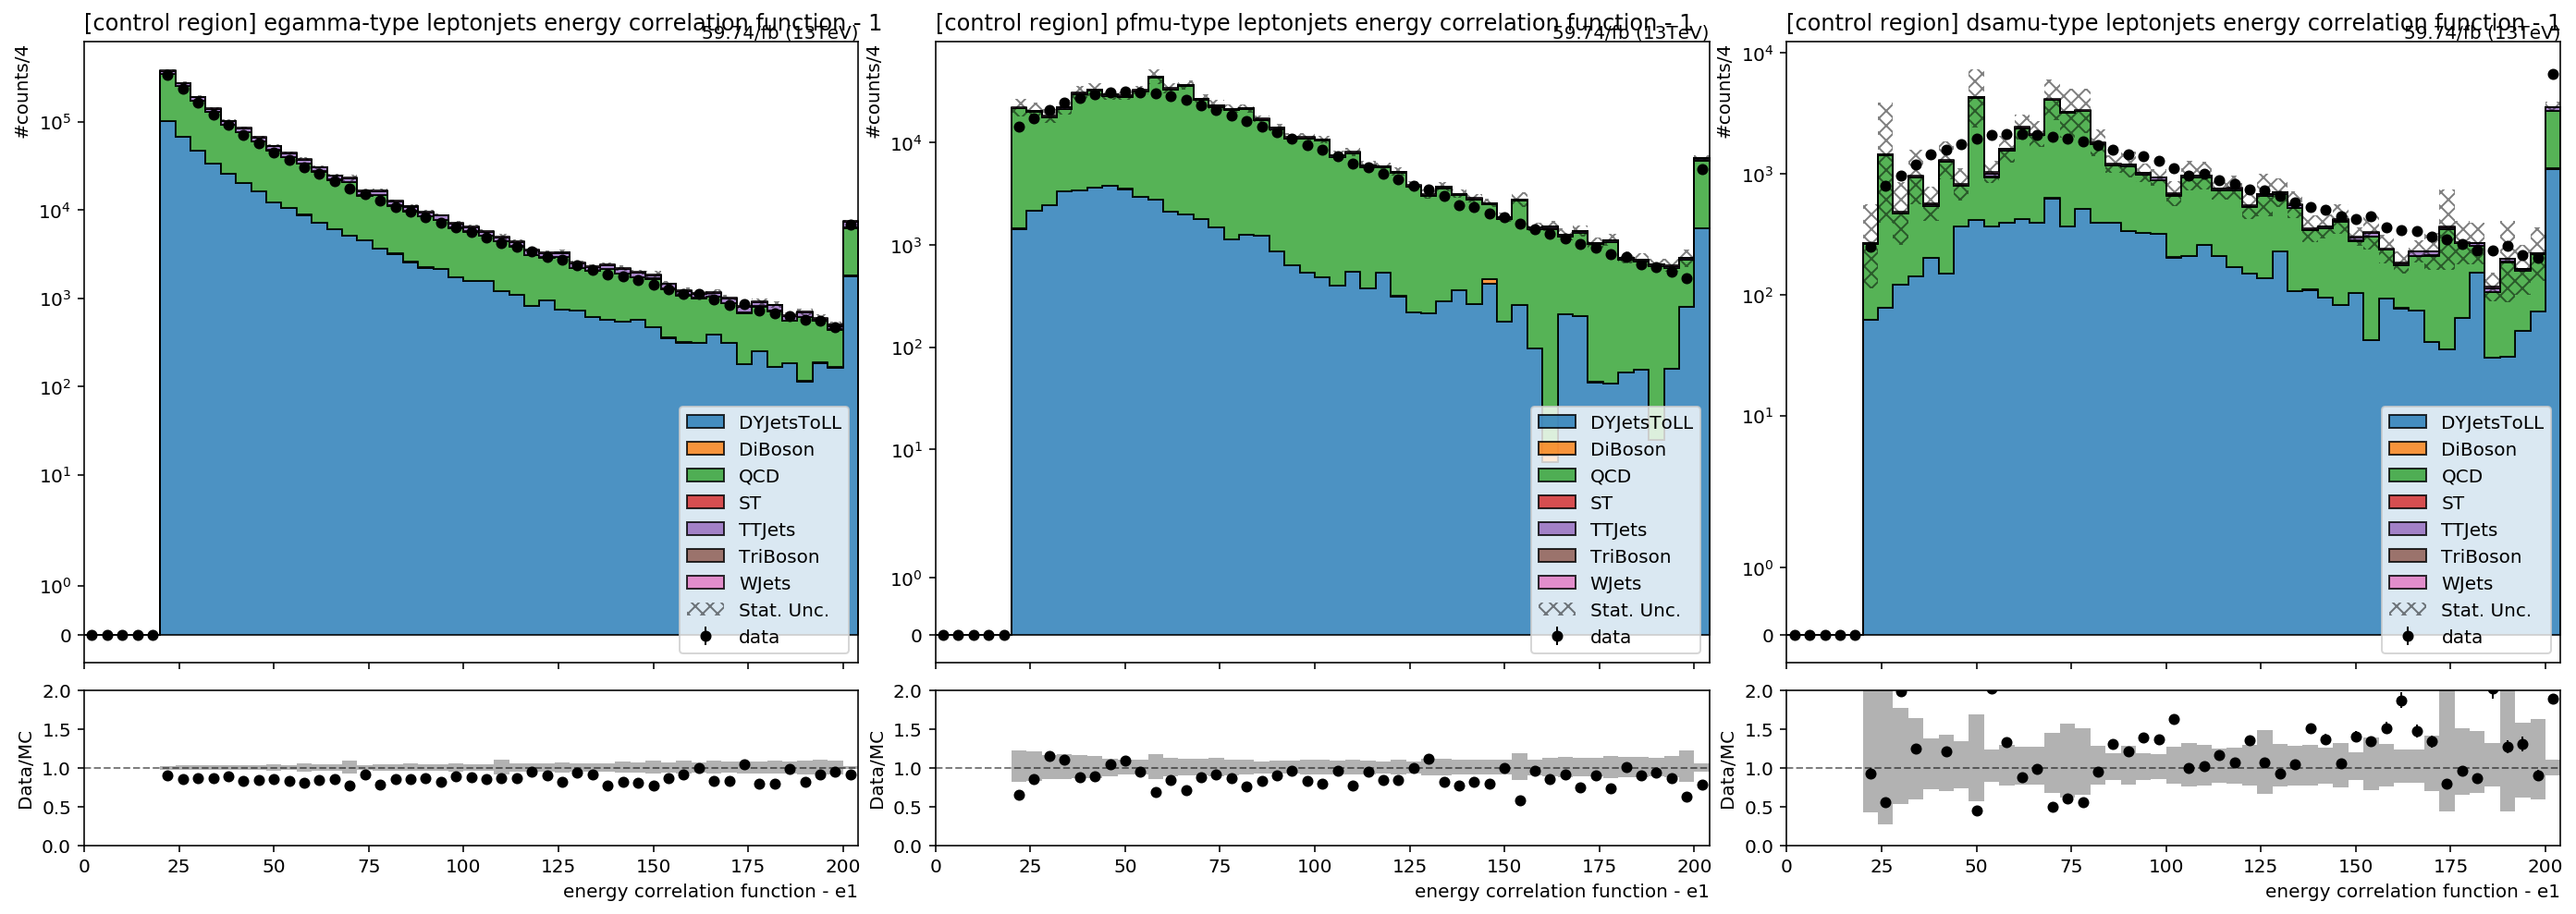

In [36]:
makeplot('ecfe1_cat', 'energy correlation function - 1');

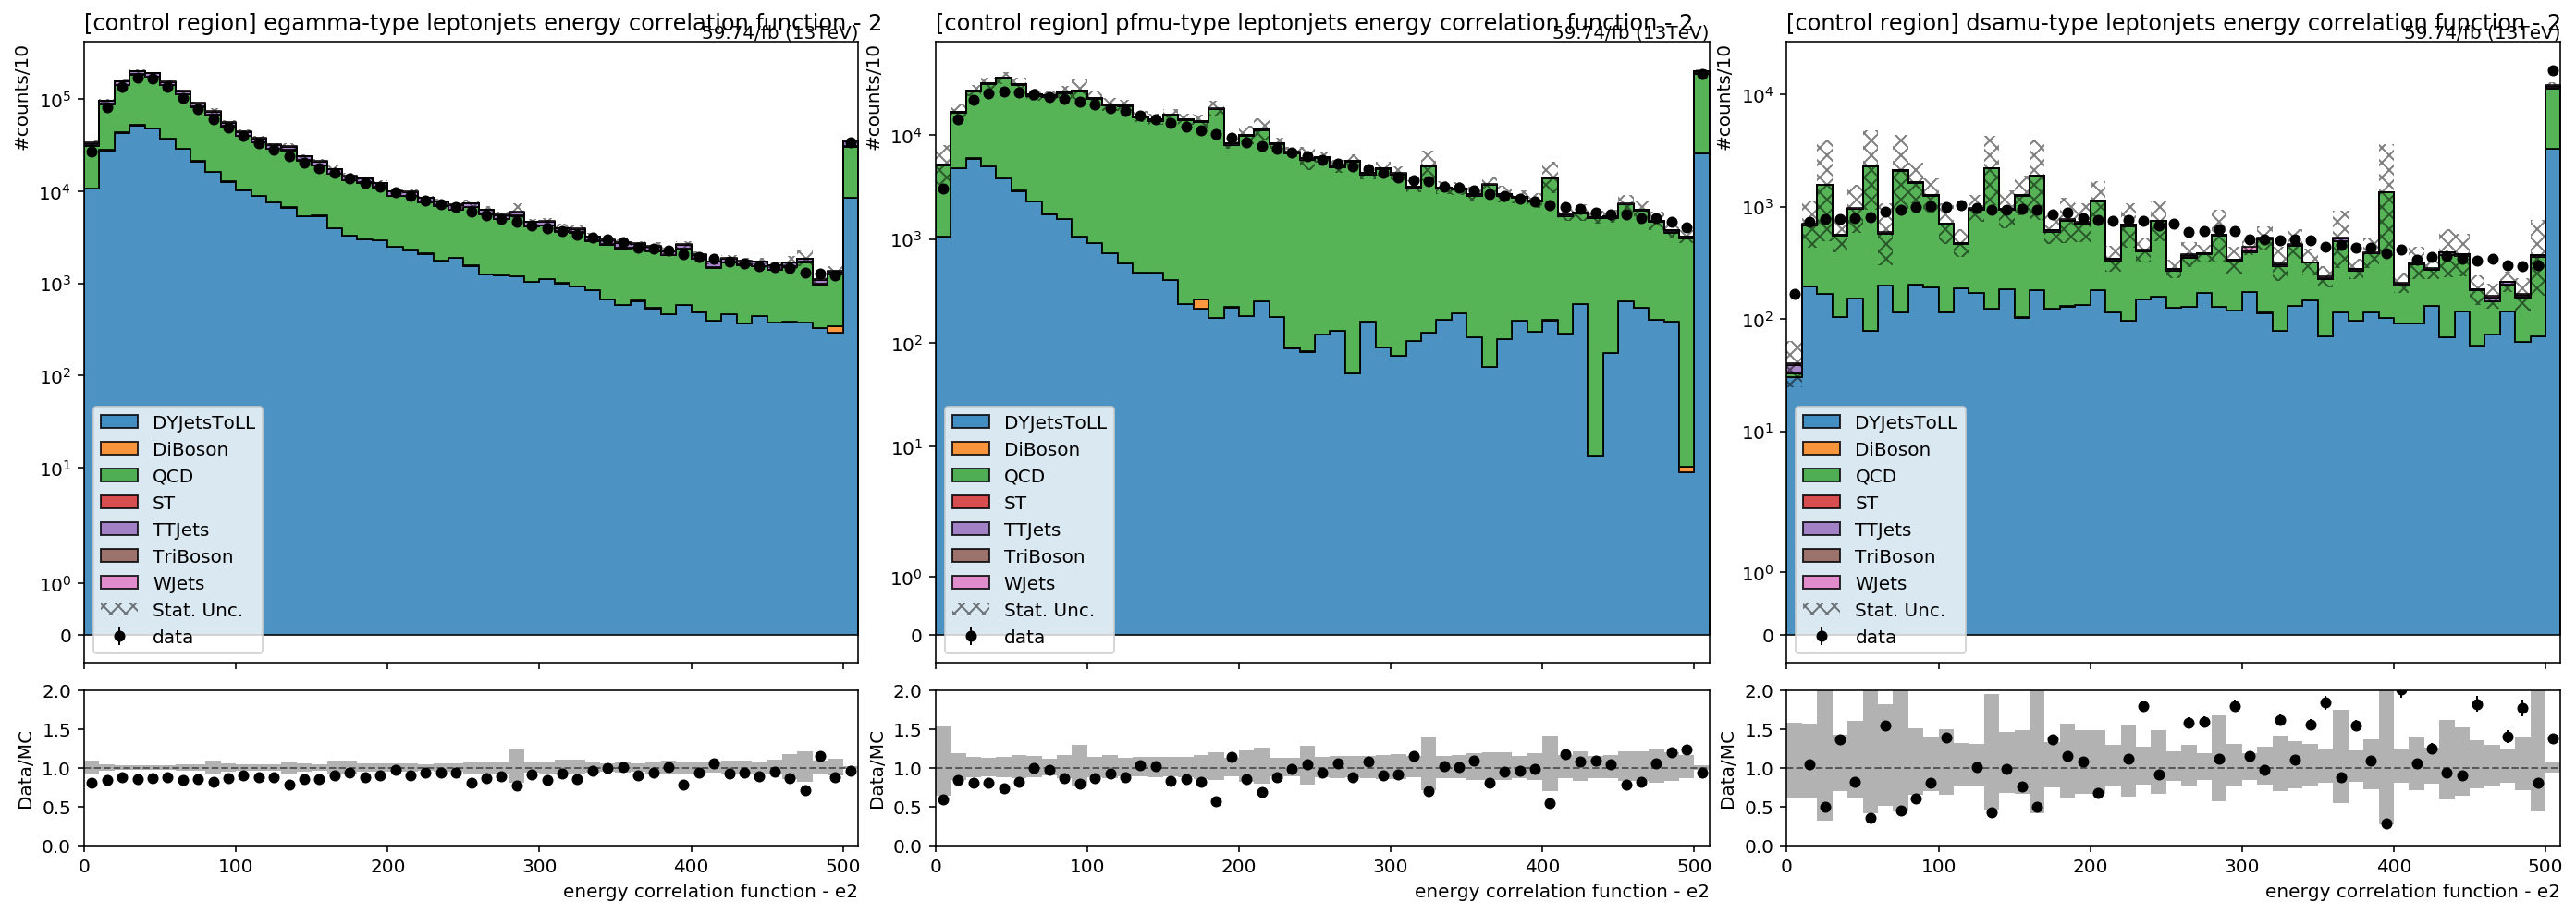

In [37]:
makeplot('ecfe2_cat', 'energy correlation function - 2');

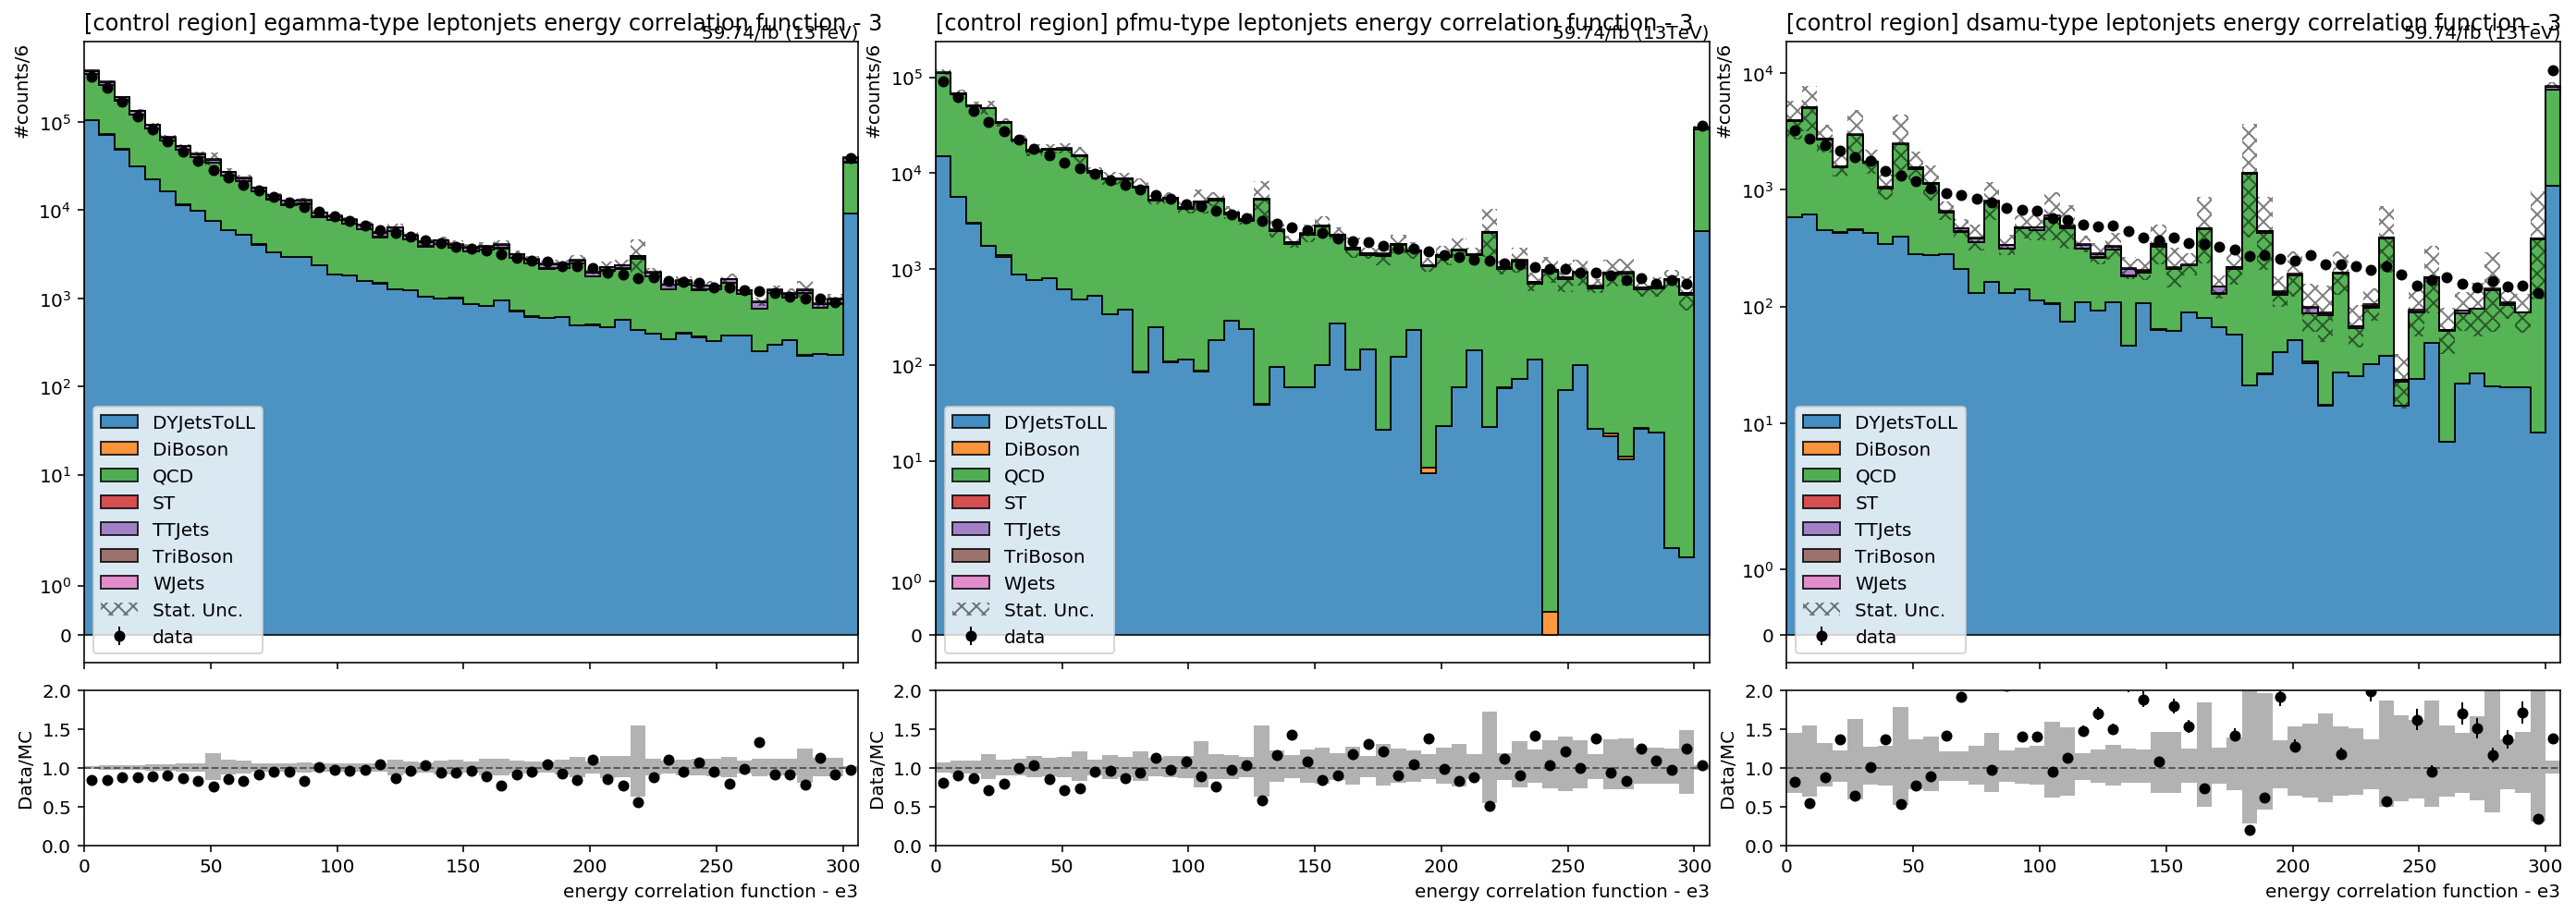

In [38]:
makeplot('ecfe3_cat', 'energy correlation function - 3');

# leading/subleading leptonjet

In [10]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        pt_axis       = hist.Bin("pt", "pT [GeV]", ptbinning)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1.001)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        label_axis    = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        
        self._accumulator = processor.dict_accumulator({
            'lead_pt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis),
            "lead_eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, label_axis),
            "lead_nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, label_axis),
            "lead_maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, label_axis),
            "lead_mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, label_axis),
            "lead_tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, label_axis),
            "lead_pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, label_axis),
            "lead_spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, label_axis),
            "lead_spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, label_axis),
            "lead_lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, label_axis),
            "lead_epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, label_axis),
            "lead_ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis, label_axis),
            "lead_ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis, label_axis),
            "lead_ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis, label_axis),
            "lead_mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, label_axis),
            
            'subl_pt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis),
            "subl_eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, label_axis),
            "subl_nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, label_axis),
            "subl_maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, label_axis),
            "subl_mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, label_axis),
            "subl_tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, label_axis),
            "subl_pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, label_axis),
            "subl_spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, label_axis),
            "subl_spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, label_axis),
            "subl_lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, label_axis),
            "subl_epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, label_axis),
            "subl_ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis, label_axis),
            "subl_ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis, label_axis),
            "subl_ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis, label_axis),
            "subl_mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, label_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(awkward.fromiter(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=absd0.max().content,
            mind0=absd0.min().content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        dileptonjets = dileptonjets[controlregion]
        if dileptonjets.size==0: return output
        leadlj_ = dileptonjets[dileptonjets.pt.argmax()]
        subllj_ = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        wgt = wgt[controlregion]

        output['lead_pt'].fill(dataset=dataset, pt=leadlj_.pt.flatten(),
                          label=leadlj_.label.flatten(), weight=wgt)
        output['lead_eta'].fill(dataset=dataset, eta=leadlj_.eta.flatten(),
                           label=leadlj_.label.flatten(), weight=wgt)
        output['lead_nef'].fill(dataset=dataset, nef=leadlj_.nef.flatten(),
                           label=leadlj_.label.flatten(), weight=wgt)
        output['lead_maxd0'].fill(dataset=dataset, maxd0=leadlj_.maxd0.flatten(),
                             label=leadlj_.label.flatten(), weight=wgt)
        output['lead_mind0'].fill(dataset=dataset, mind0=leadlj_.mind0.flatten(),
                             label=leadlj_.label.flatten(), weight=wgt)
        output['lead_tkiso'].fill(dataset=dataset, tkiso=leadlj_.tkiso.flatten(),
                             label=leadlj_.label.flatten(), weight=wgt)
        output['lead_pfiso'].fill(dataset=dataset, pfiso=leadlj_.pfiso.flatten(),
                             label=leadlj_.label.flatten(), weight=wgt)
        output['lead_spreadpt'].fill(dataset=dataset, spreadpt=leadlj_.spreadpt.flatten(),
                                label=leadlj_.label.flatten(), weight=wgt)
        output['lead_spreaddr'].fill(dataset=dataset, spreaddr=leadlj_.spreaddr.flatten(),
                                label=leadlj_.label.flatten(), weight=wgt)
        output['lead_lamb'].fill(dataset=dataset, lamb=leadlj_.lamb.flatten(),
                            label=leadlj_.label.flatten(), weight=wgt)
        output['lead_epsi'].fill(dataset=dataset, epsi=leadlj_.epsi.flatten(),
                            label=leadlj_.label.flatten(), weight=wgt)
        output['lead_ecfe1'].fill(dataset=dataset, ecfe1=leadlj_.ecf1.flatten(),
                             label=leadlj_.label.flatten(), weight=wgt)
        output['lead_ecfe2'].fill(dataset=dataset, ecfe2=leadlj_.ecf2.flatten(),
                             label=leadlj_.label.flatten(), weight=wgt)
        output['lead_ecfe3'].fill(dataset=dataset, ecfe3=leadlj_.ecf3.flatten(),
                             label=leadlj_.label.flatten(), weight=wgt)
        output['lead_mva'].fill(dataset=dataset, mva=leadlj_.mva.flatten(),
                           label=leadlj_.label.flatten(), weight=wgt)

        output['subl_pt'].fill(dataset=dataset, pt=subllj_.pt.flatten(),
                          label=subllj_.label.flatten(), weight=wgt)
        output['subl_eta'].fill(dataset=dataset, eta=subllj_.eta.flatten(),
                           label=subllj_.label.flatten(), weight=wgt)
        output['subl_nef'].fill(dataset=dataset, nef=subllj_.nef.flatten(),
                           label=subllj_.label.flatten(), weight=wgt)
        output['subl_maxd0'].fill(dataset=dataset, maxd0=subllj_.maxd0.flatten(),
                             label=subllj_.label.flatten(), weight=wgt)
        output['subl_mind0'].fill(dataset=dataset, mind0=subllj_.mind0.flatten(),
                             label=subllj_.label.flatten(), weight=wgt)
        output['subl_tkiso'].fill(dataset=dataset, tkiso=subllj_.tkiso.flatten(),
                             label=subllj_.label.flatten(), weight=wgt)
        output['subl_pfiso'].fill(dataset=dataset, pfiso=subllj_.pfiso.flatten(),
                             label=subllj_.label.flatten(), weight=wgt)
        output['subl_spreadpt'].fill(dataset=dataset, spreadpt=subllj_.spreadpt.flatten(),
                                label=subllj_.label.flatten(), weight=wgt)
        output['subl_spreaddr'].fill(dataset=dataset, spreaddr=subllj_.spreaddr.flatten(),
                                label=subllj_.label.flatten(), weight=wgt)
        output['subl_lamb'].fill(dataset=dataset, lamb=subllj_.lamb.flatten(),
                            label=subllj_.label.flatten(), weight=wgt)
        output['subl_epsi'].fill(dataset=dataset, epsi=subllj_.epsi.flatten(),
                            label=subllj_.label.flatten(), weight=wgt)
        output['subl_ecfe1'].fill(dataset=dataset, ecfe1=subllj_.ecf1.flatten(),
                             label=subllj_.label.flatten(), weight=wgt)
        output['subl_ecfe2'].fill(dataset=dataset, ecfe2=subllj_.ecf2.flatten(),
                             label=subllj_.label.flatten(), weight=wgt)
        output['subl_ecfe3'].fill(dataset=dataset, ecfe3=subllj_.ecf3.flatten(),
                             label=subllj_.label.flatten(), weight=wgt)
        output['subl_mva'].fill(dataset=dataset, mva=subllj_.mva.flatten(),
                           label=subllj_.label.flatten(), weight=wgt)
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [15]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [17:48<00:00,  6.82items/s]


## leading leptonjets

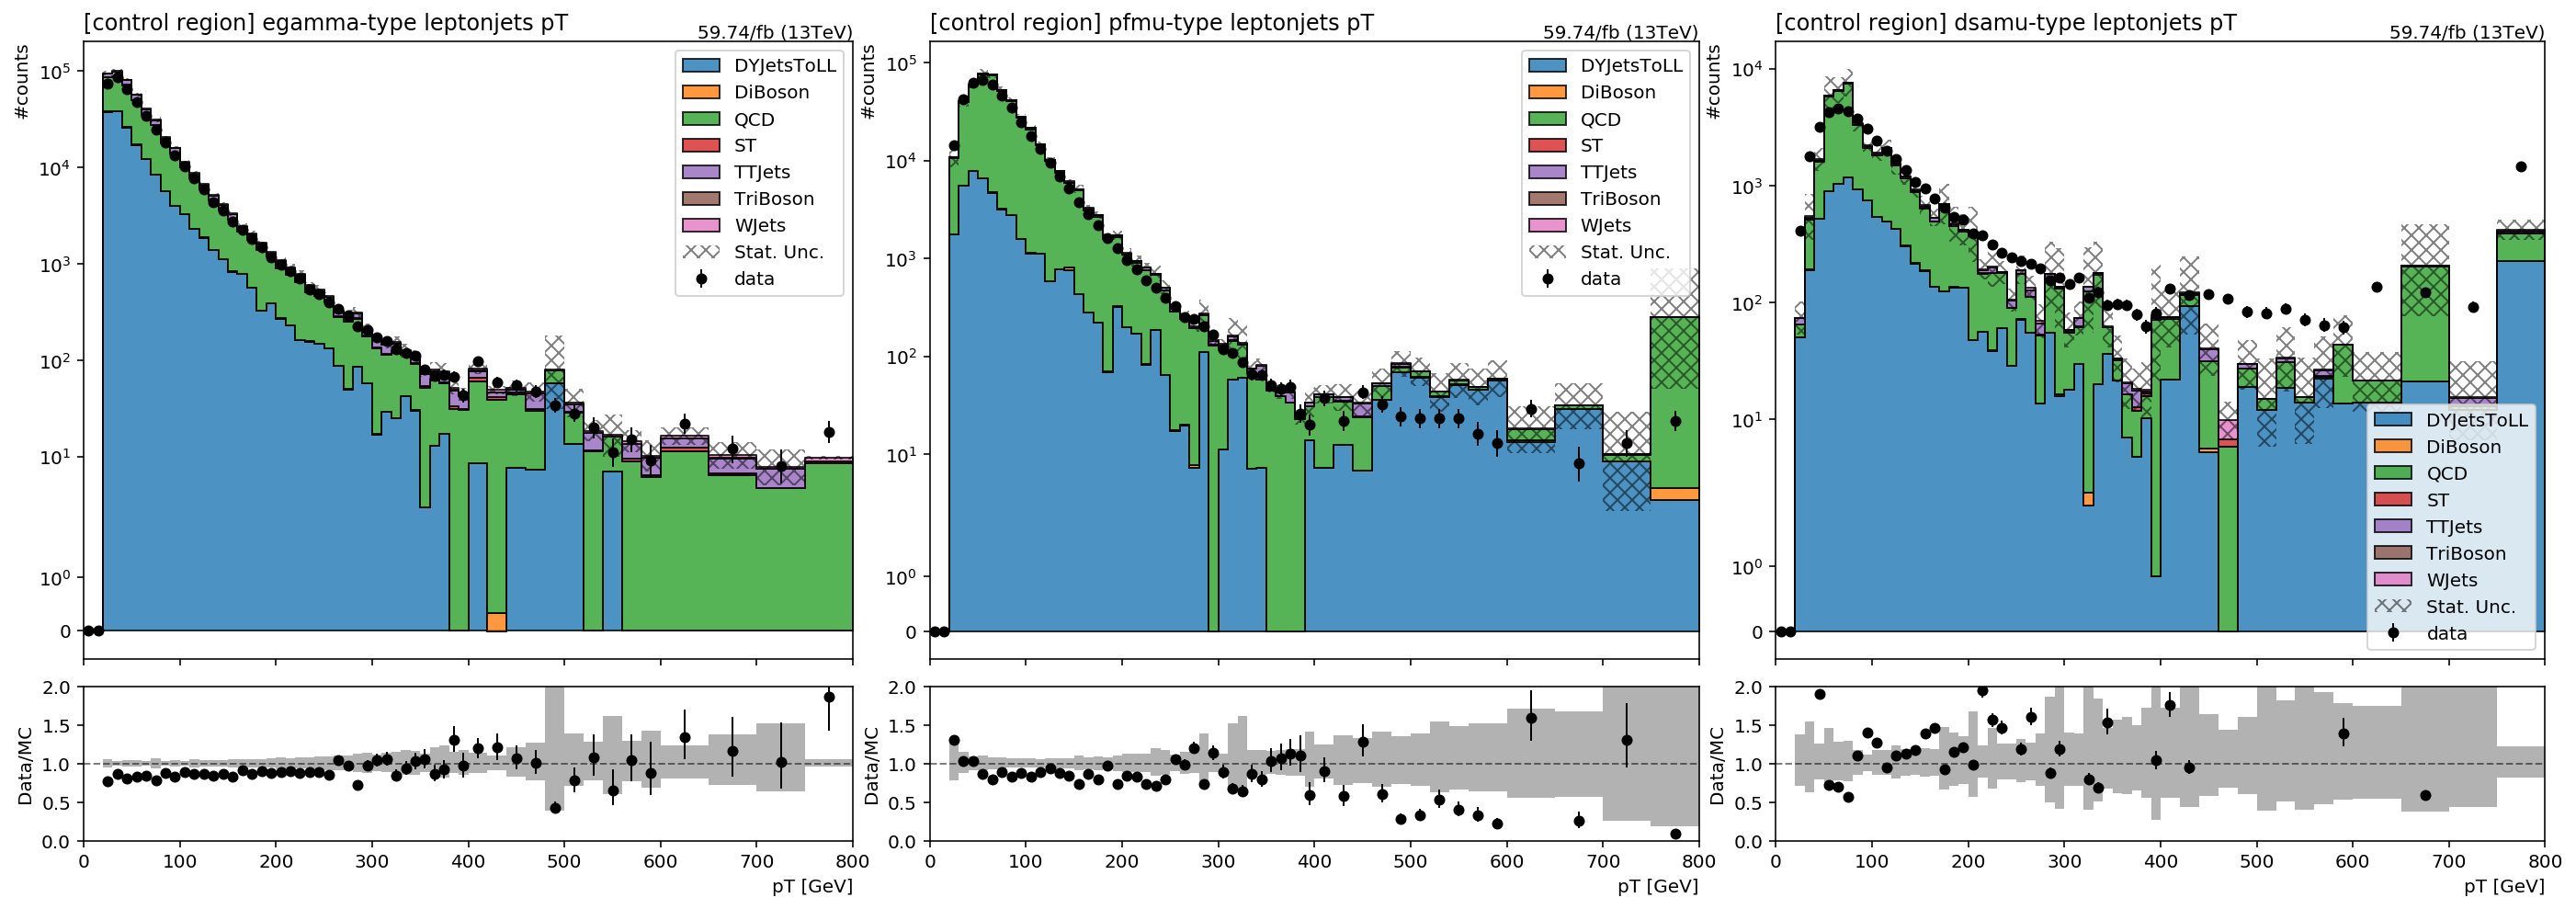

In [16]:
makeplot('lead_pt_cat', 'pT');

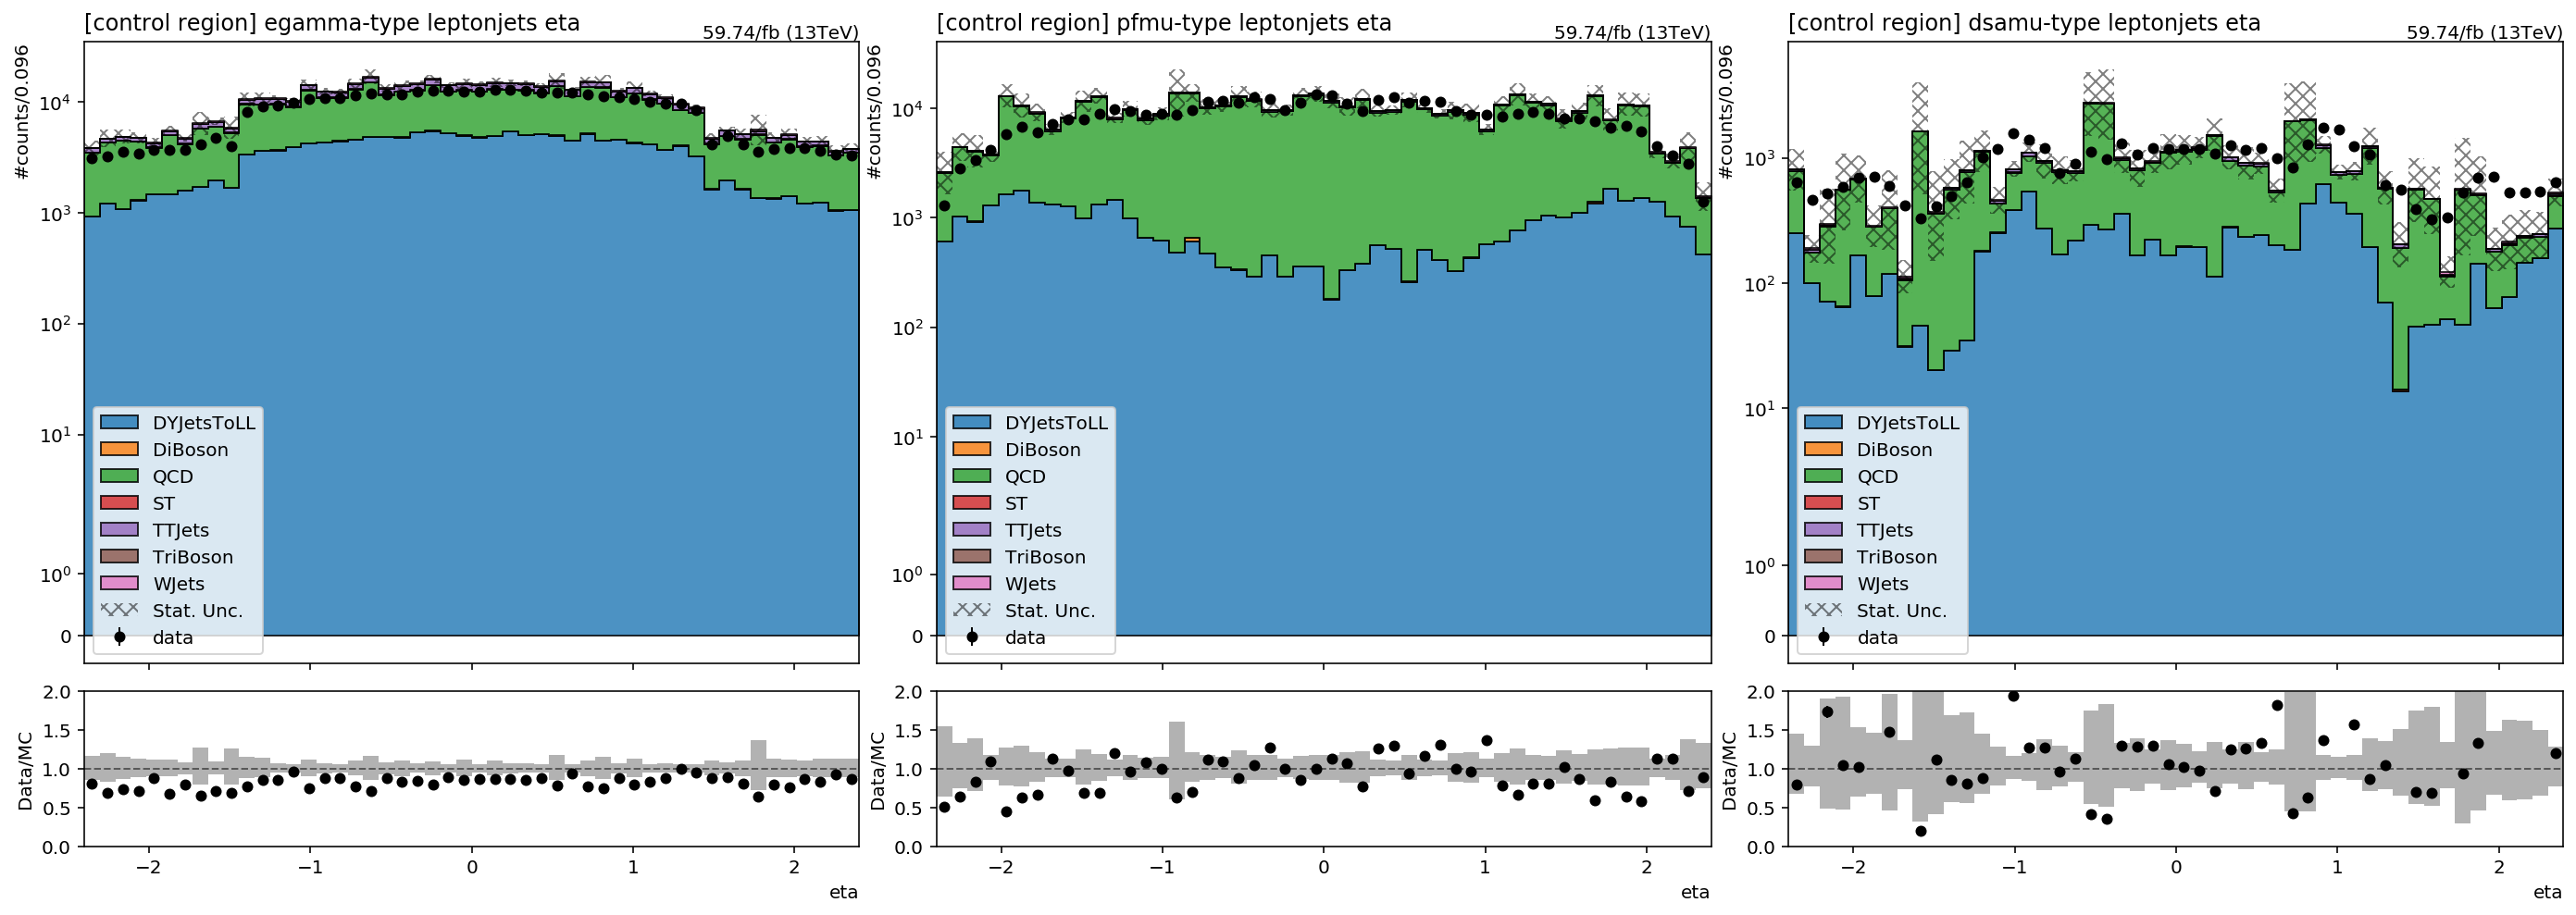

In [17]:
makeplot('lead_eta_cat', 'eta', overflow='none');

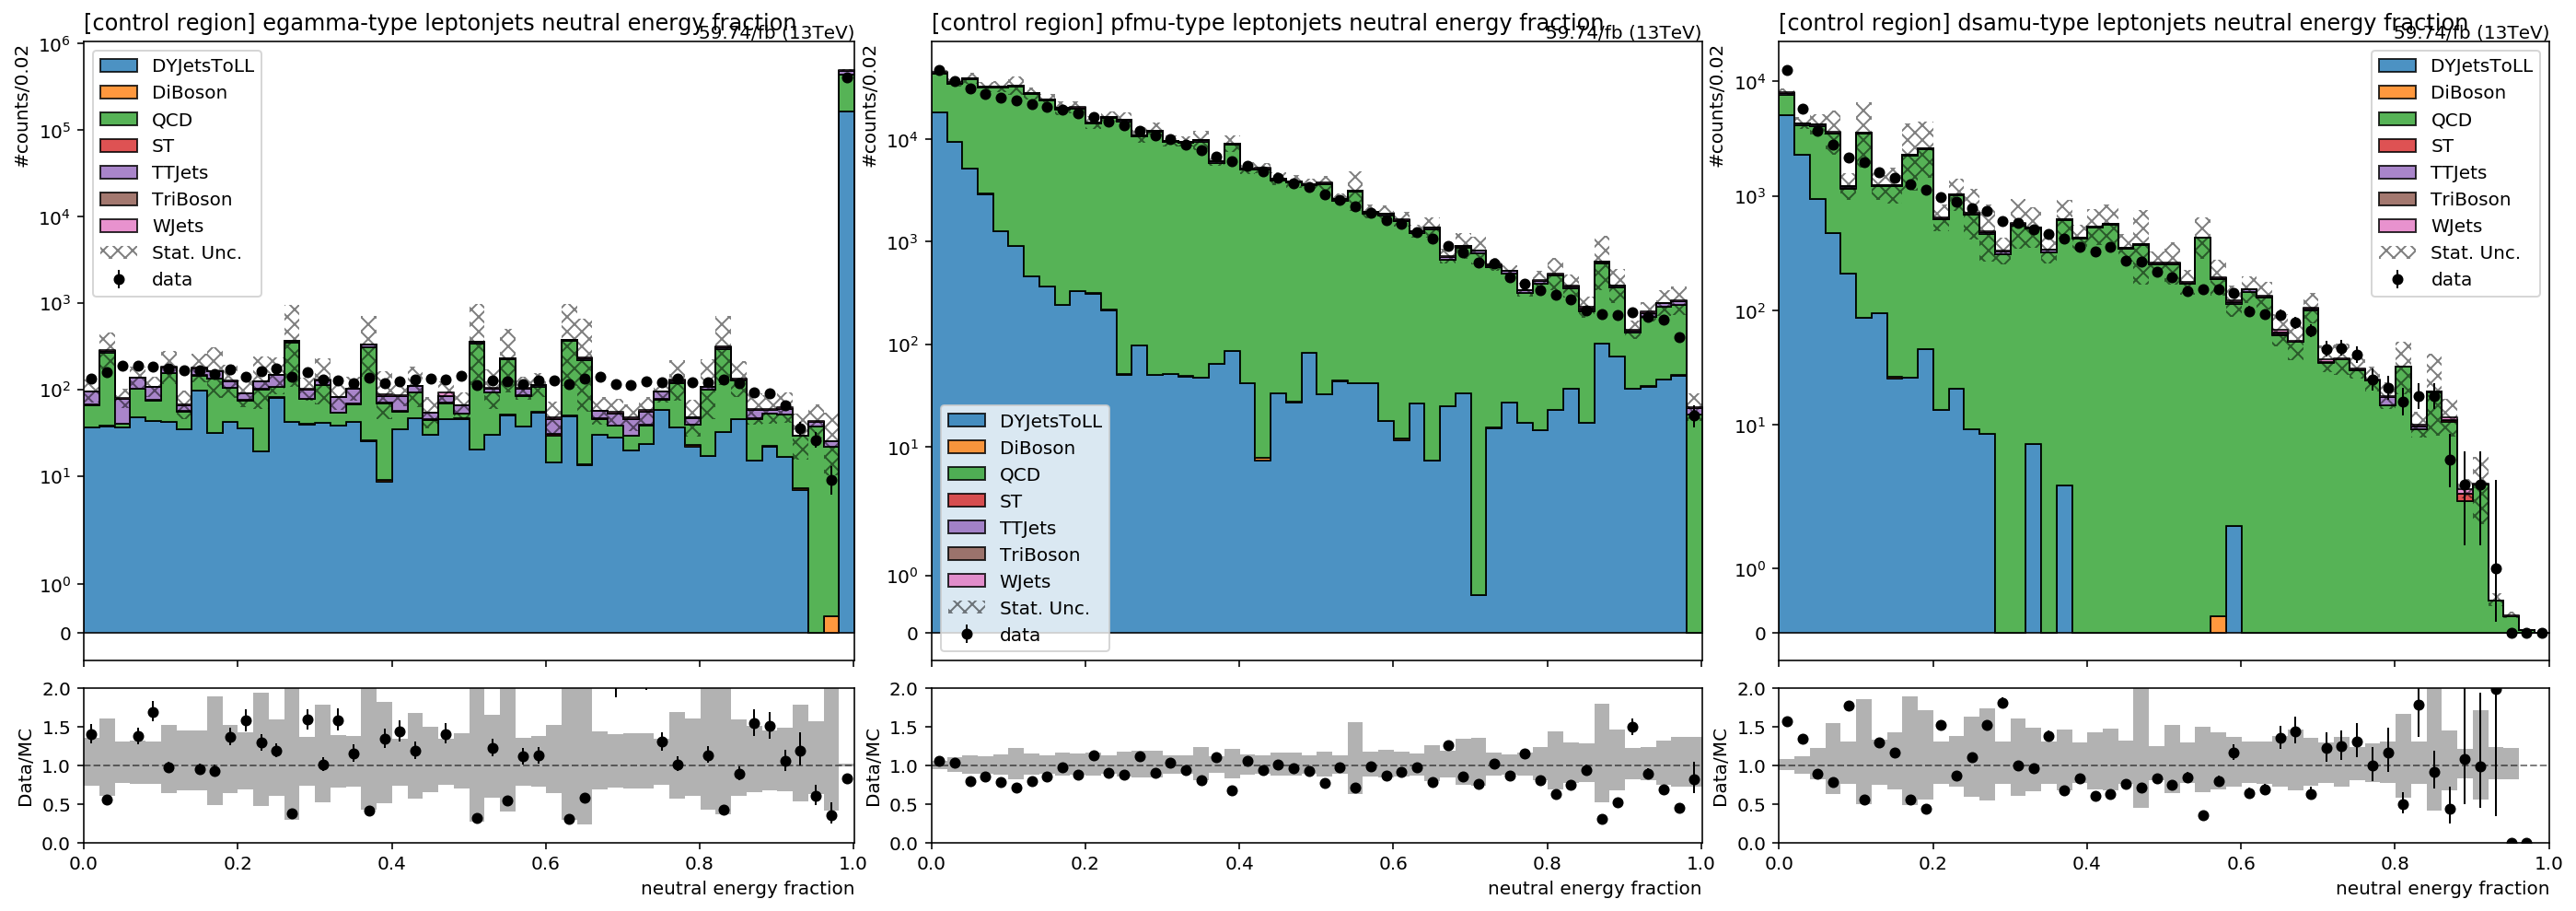

In [18]:
makeplot('lead_nef_cat', 'neutral energy fraction', overflow='none');

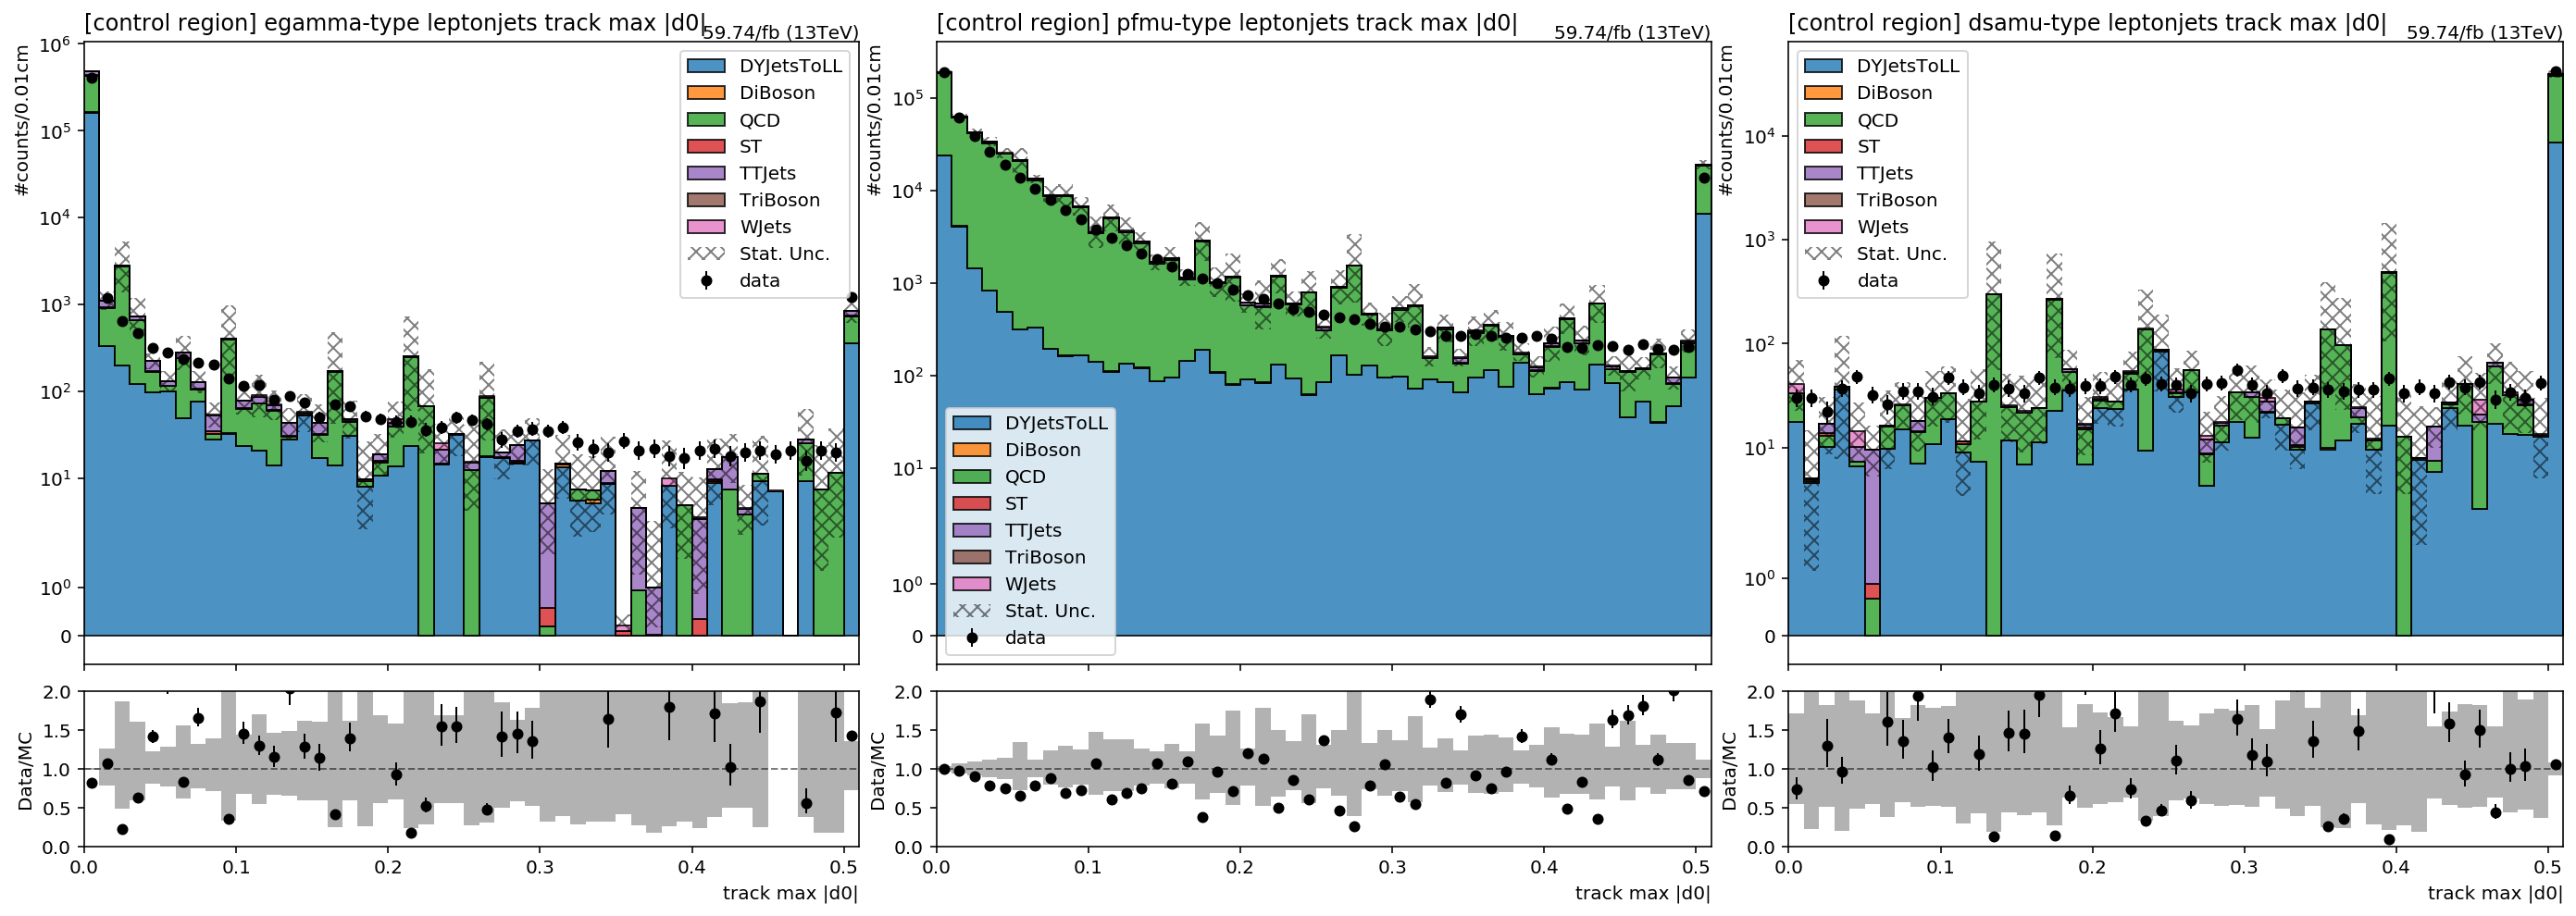

In [19]:
makeplot('lead_maxd0_cat', 'track max |d0|');

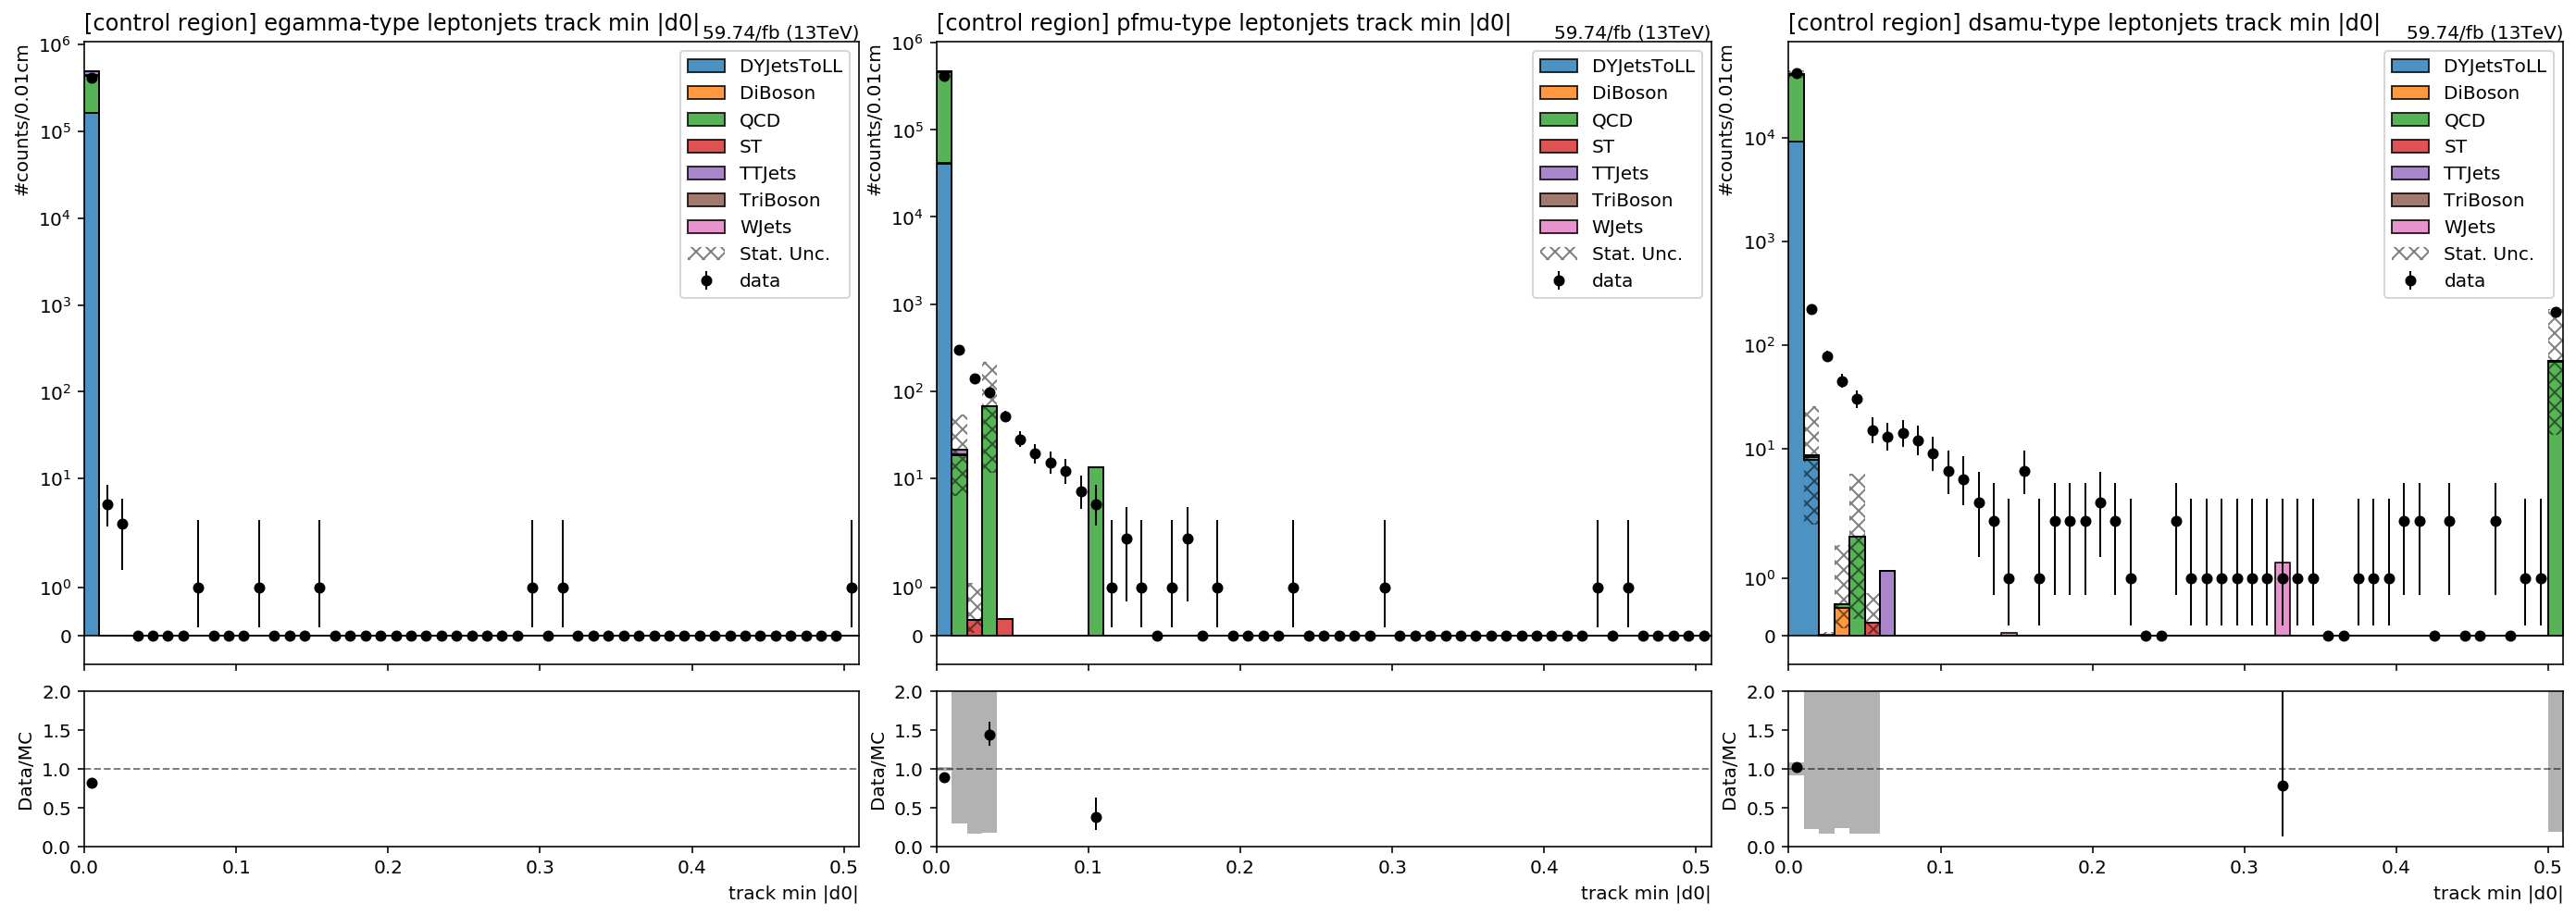

In [20]:
makeplot('lead_mind0_cat', 'track min |d0|');

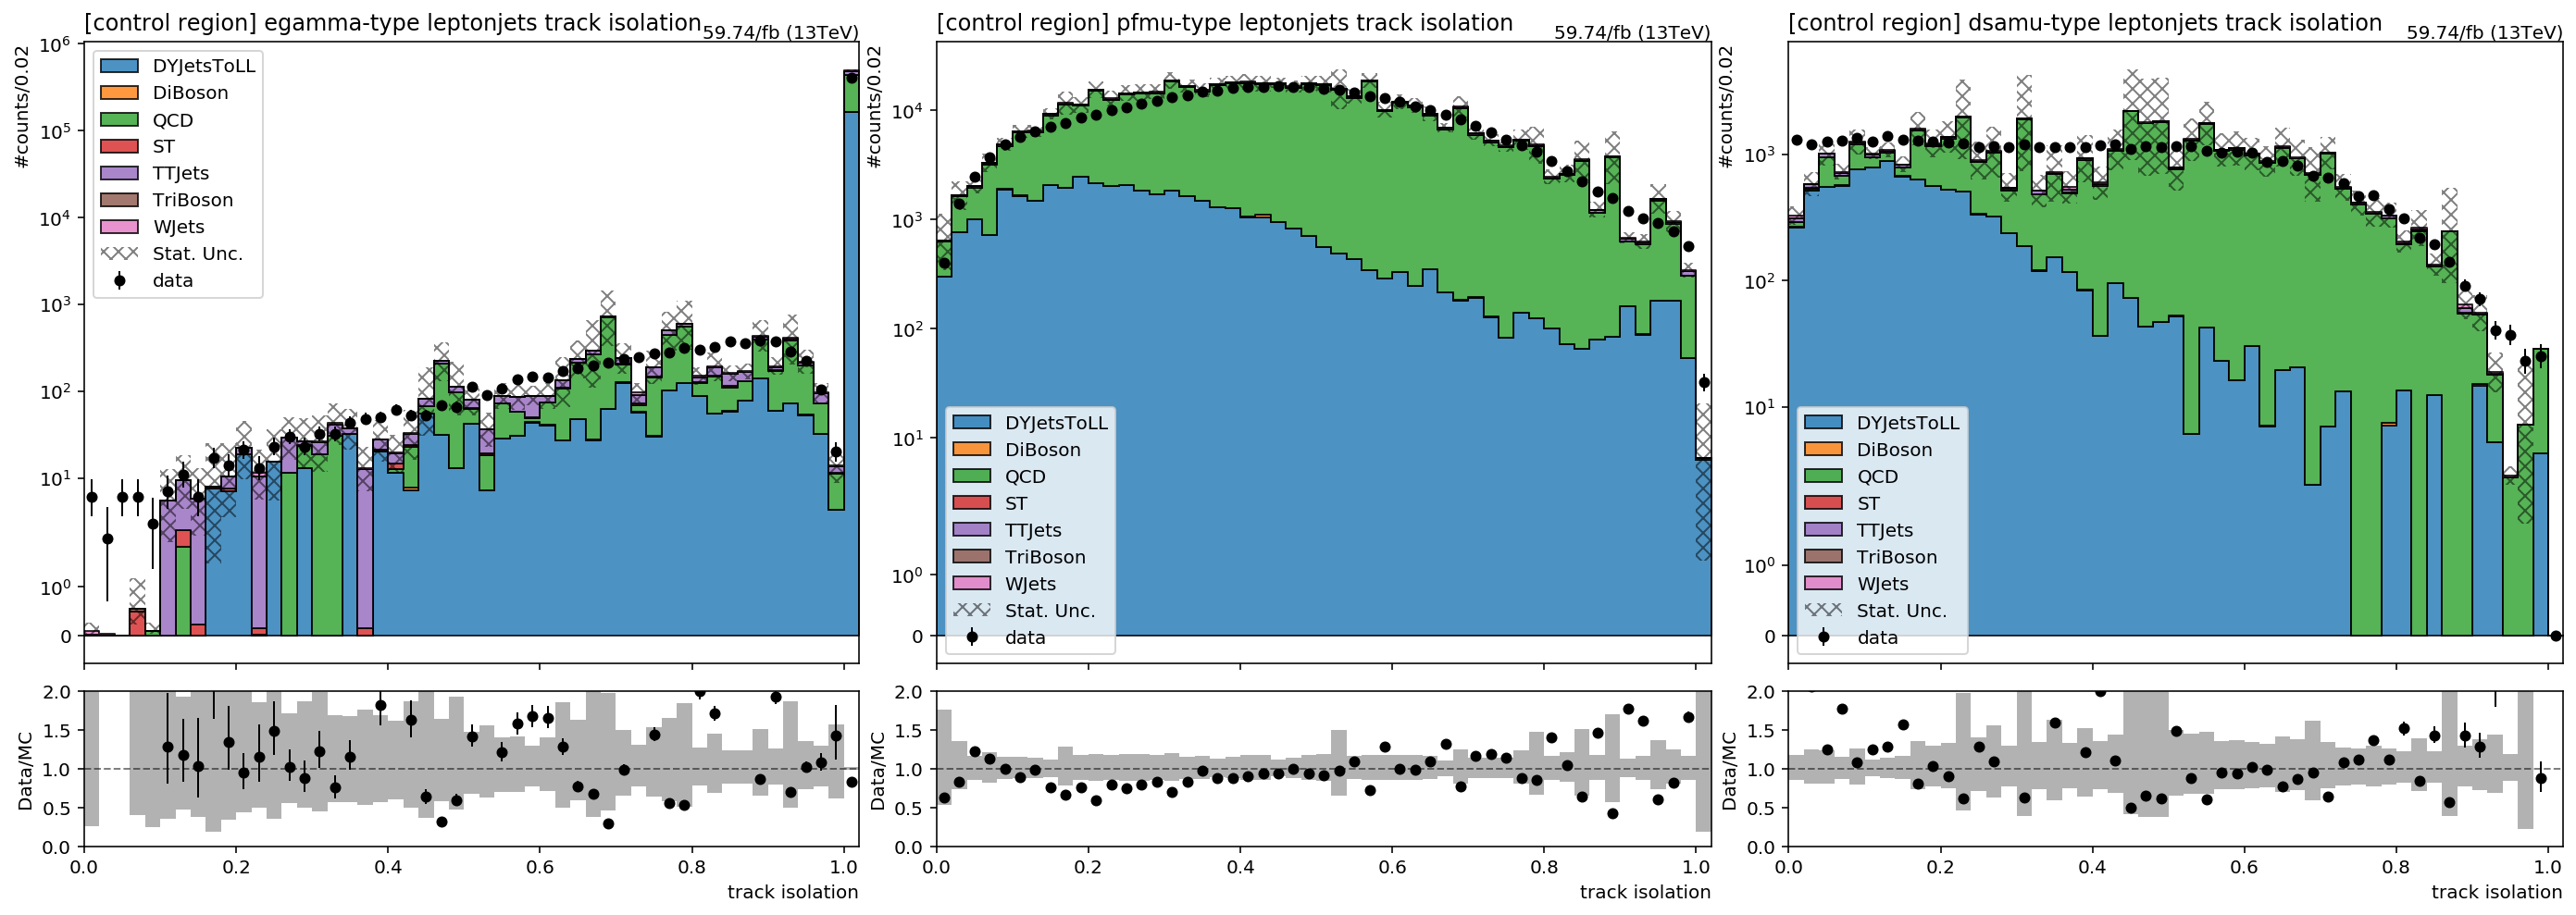

In [21]:
makeplot('lead_tkiso_cat', 'track isolation');

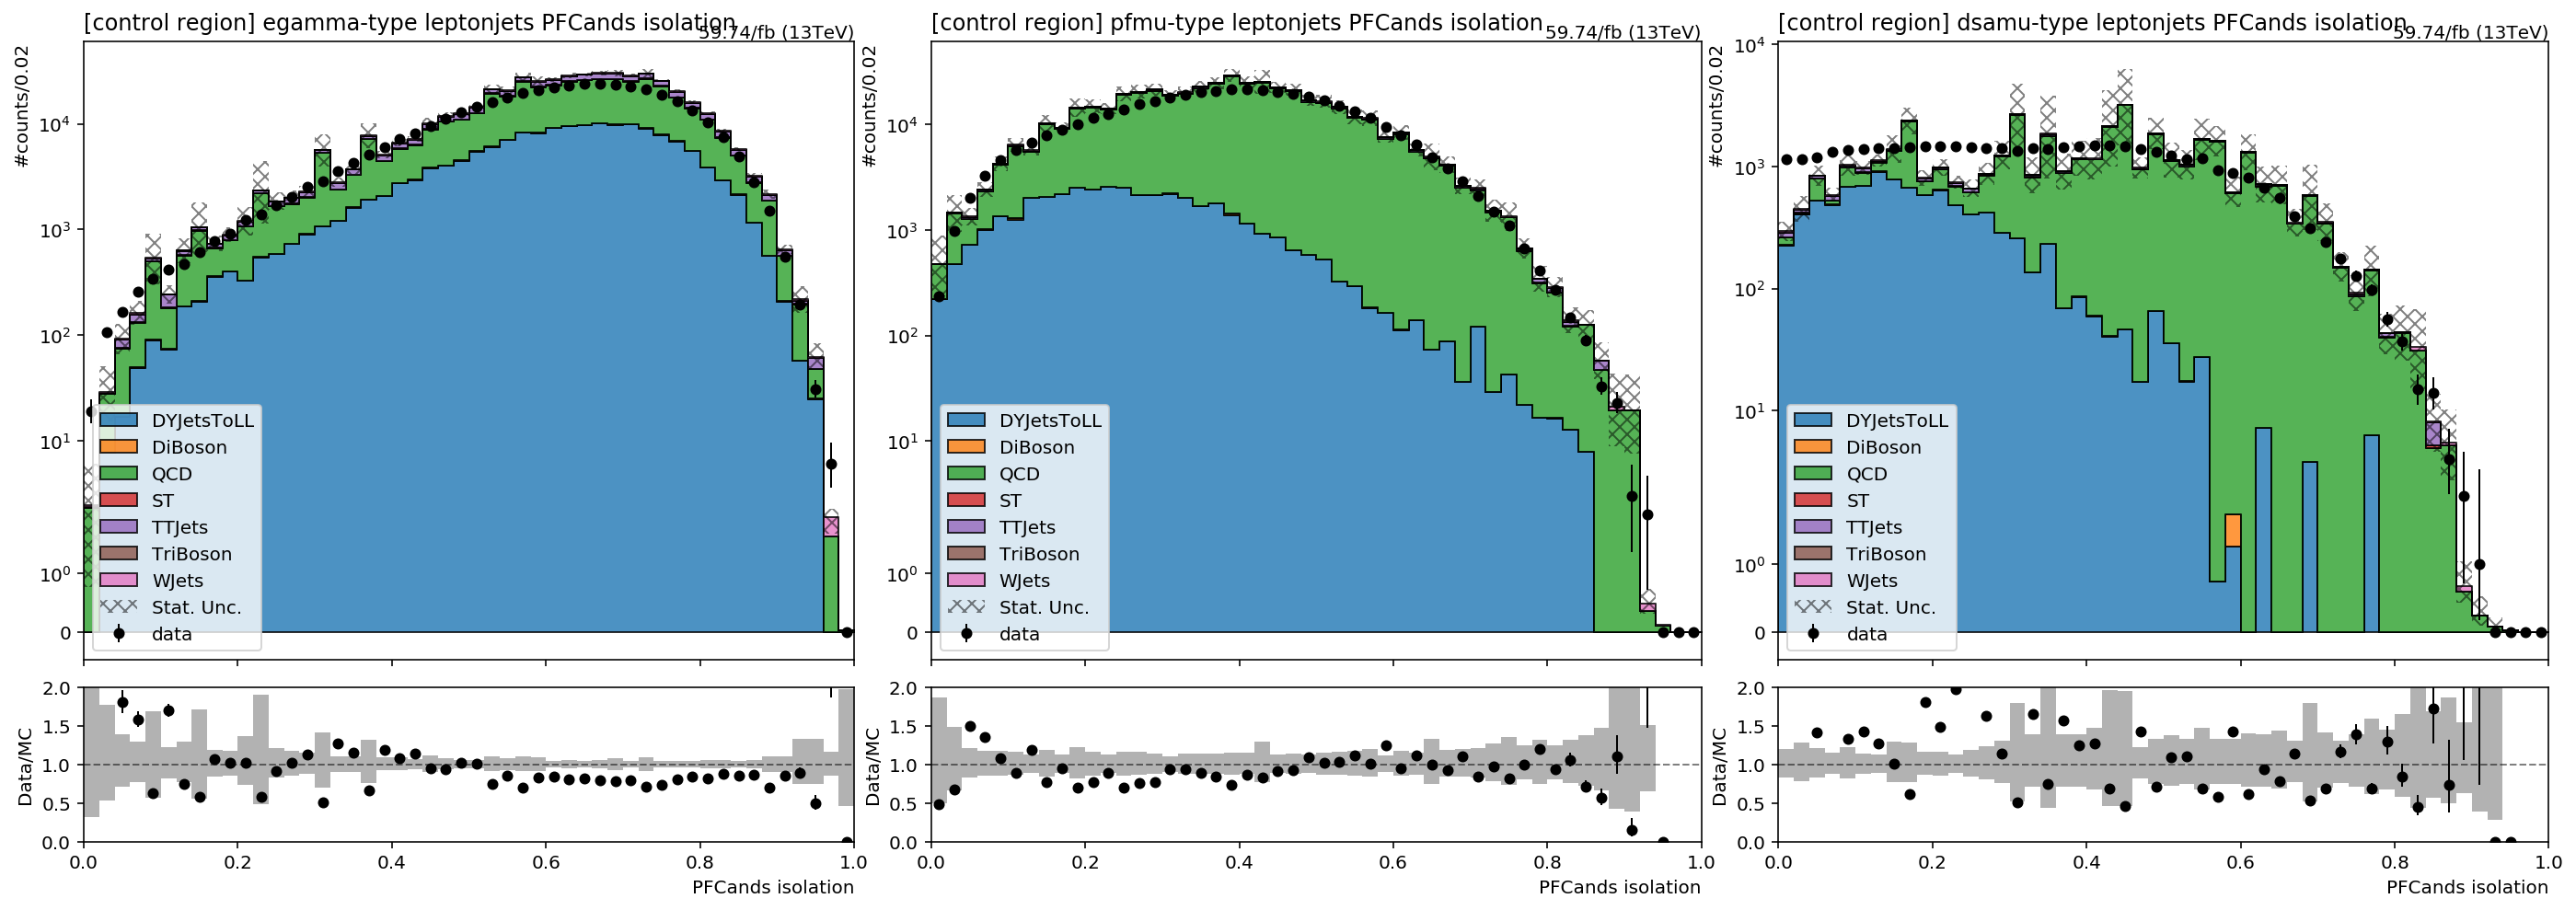

In [22]:
makeplot('lead_pfiso_cat', 'PFCands isolation', overflow='none');

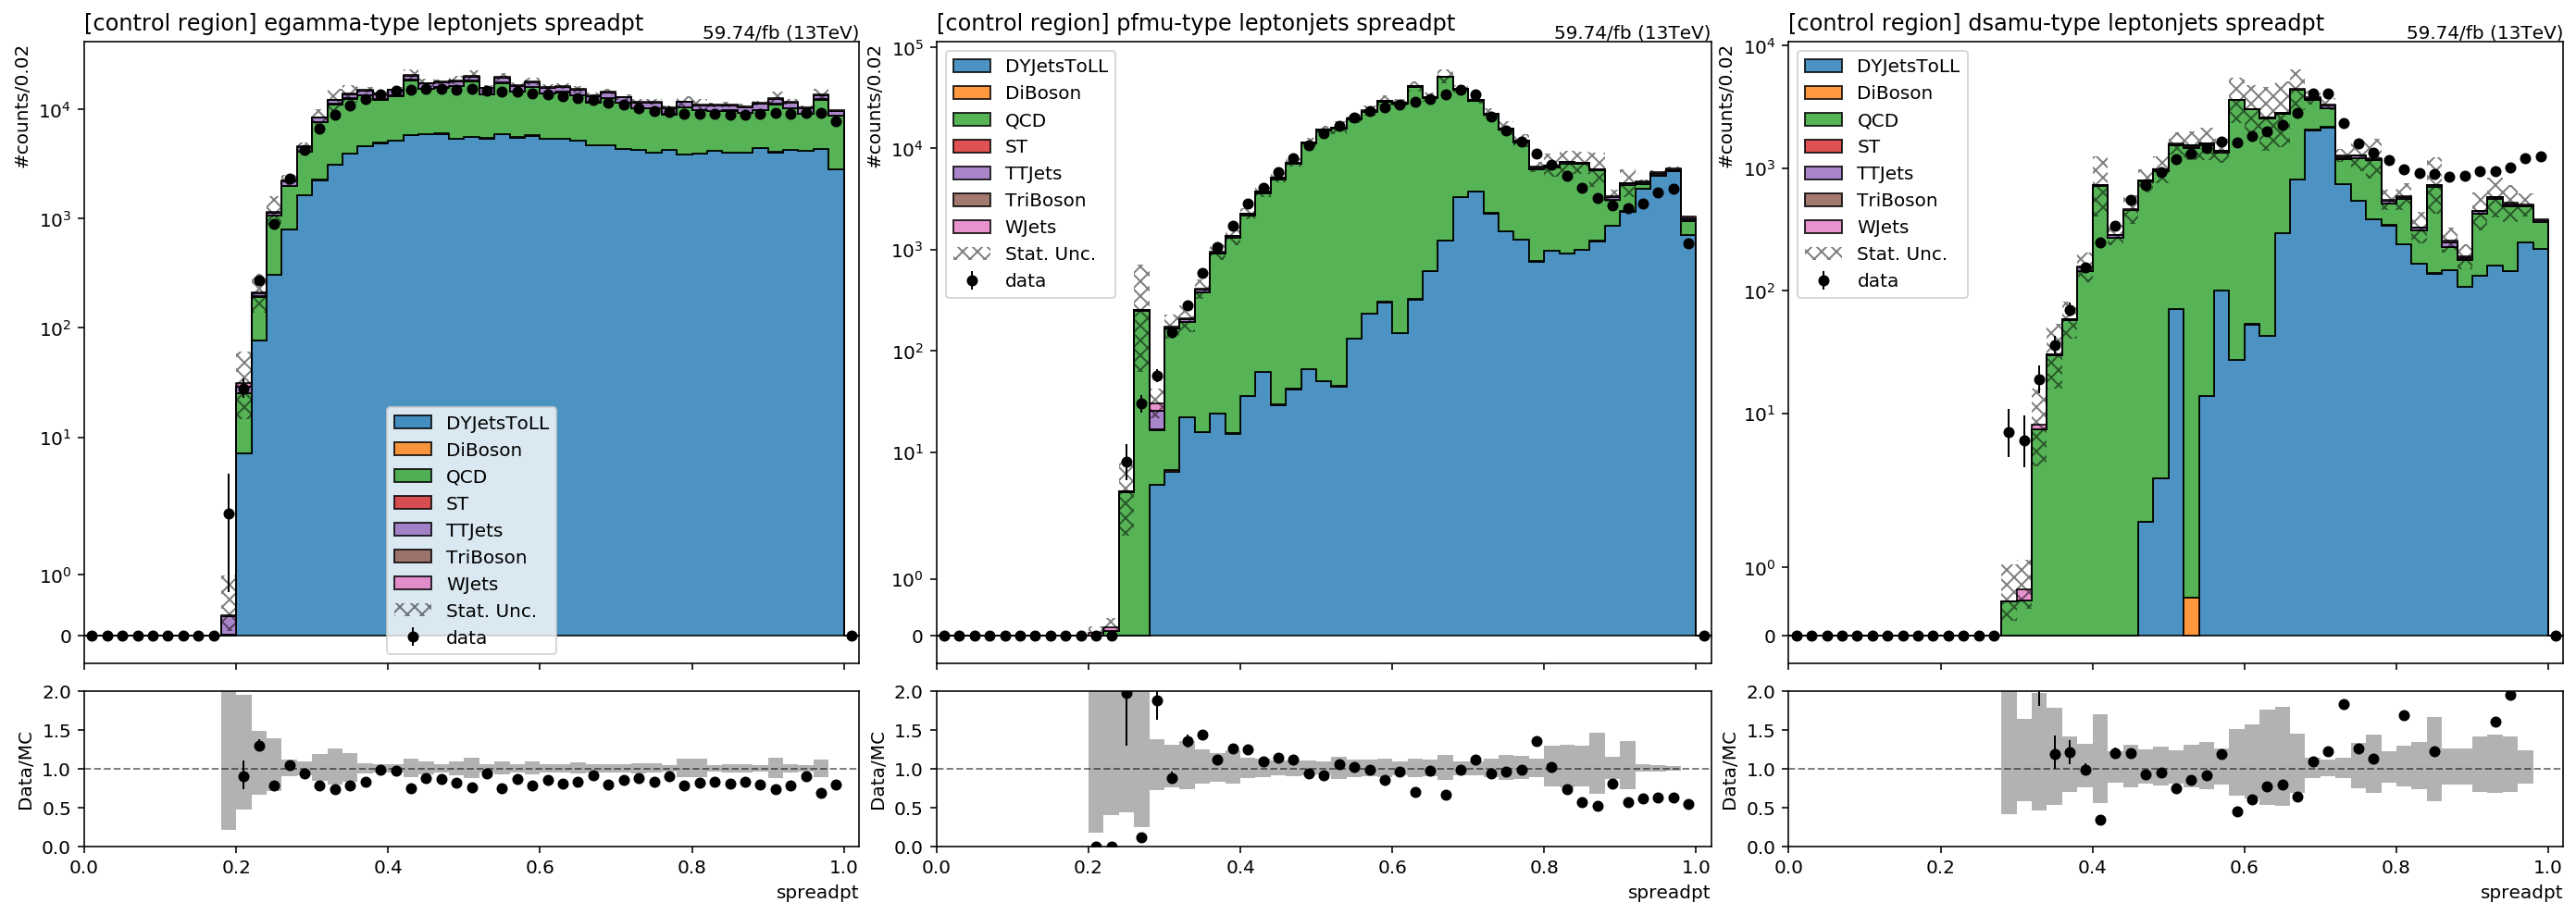

In [23]:
makeplot('lead_spreadpt_cat', 'spreadpt');

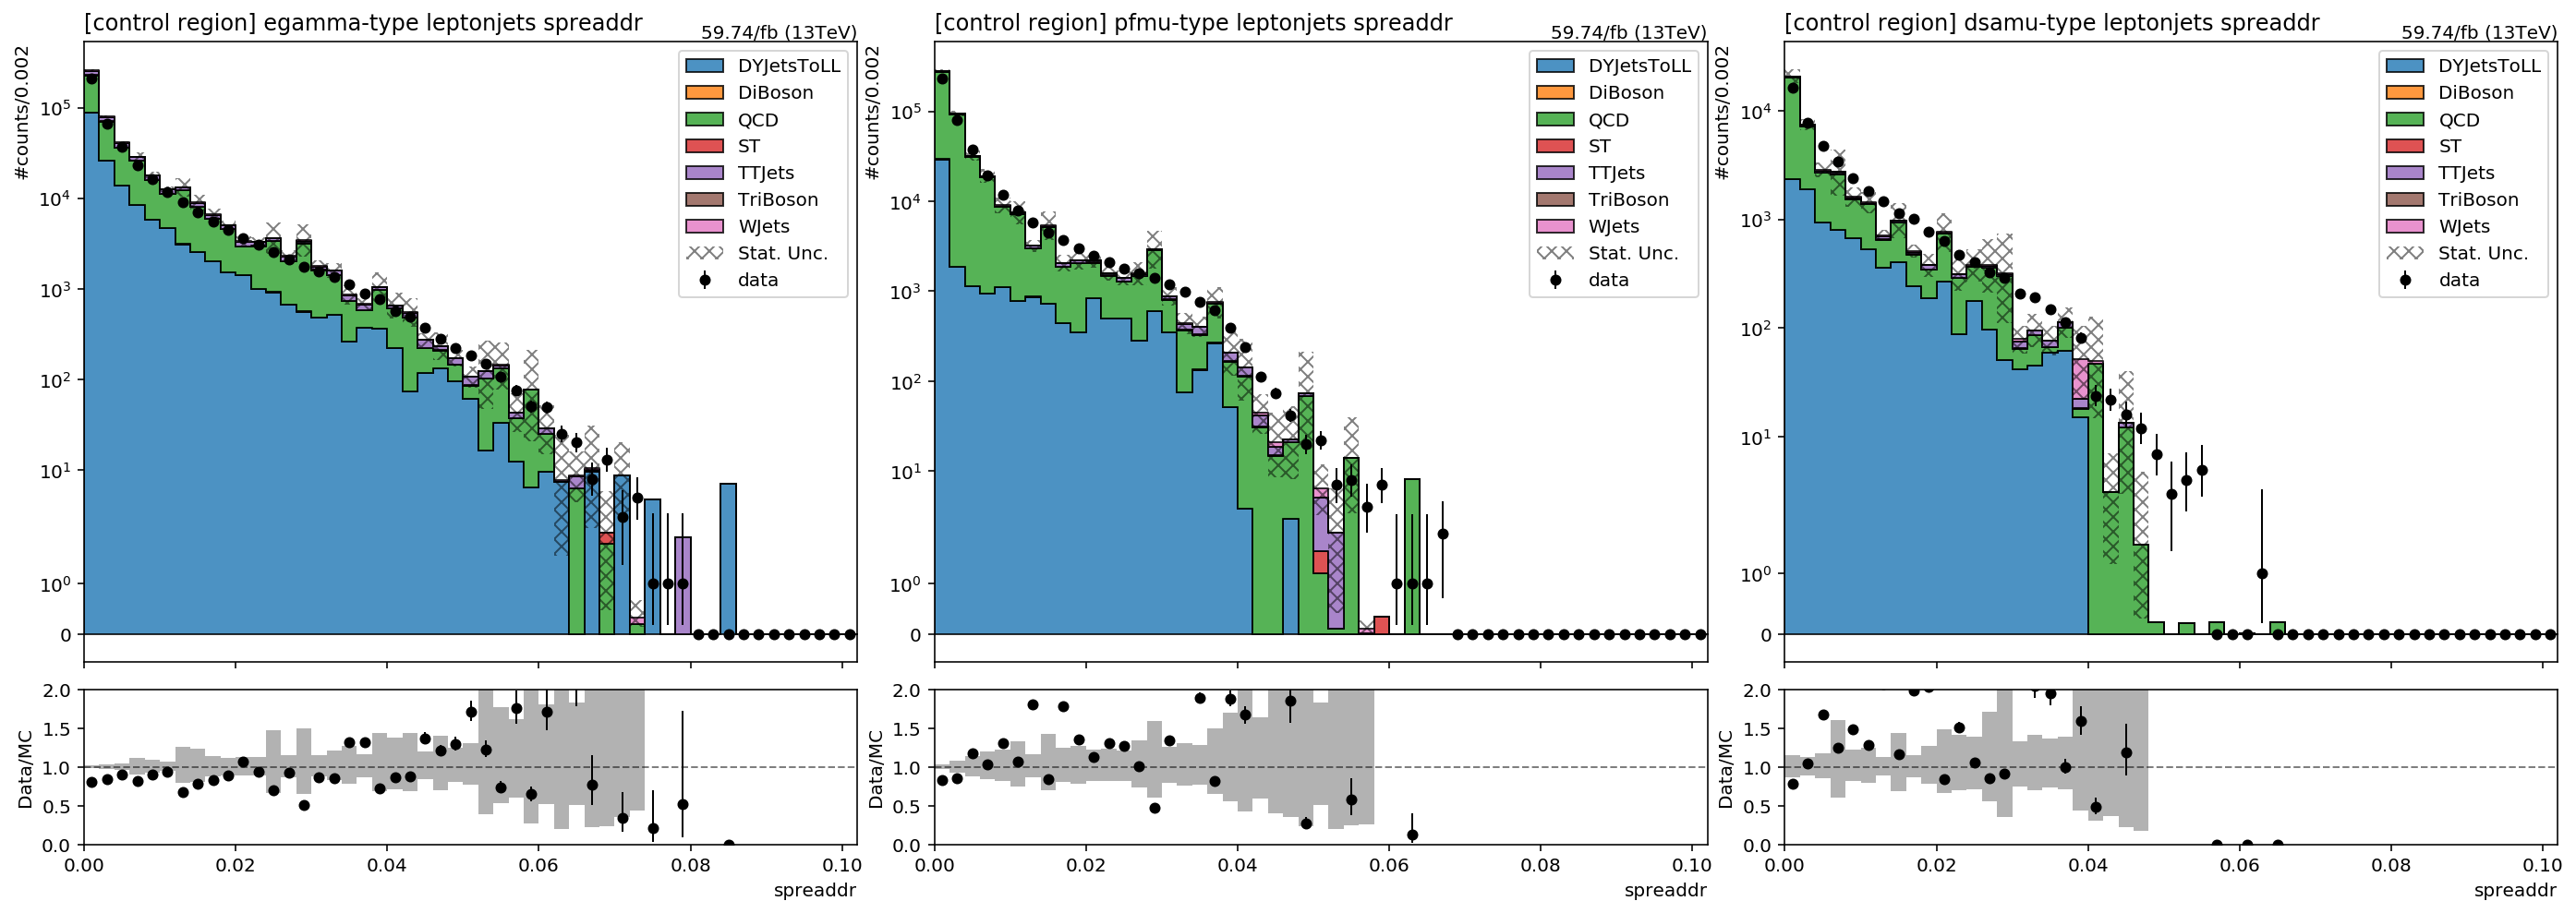

In [24]:
makeplot('lead_spreaddr_cat', 'spreaddr');

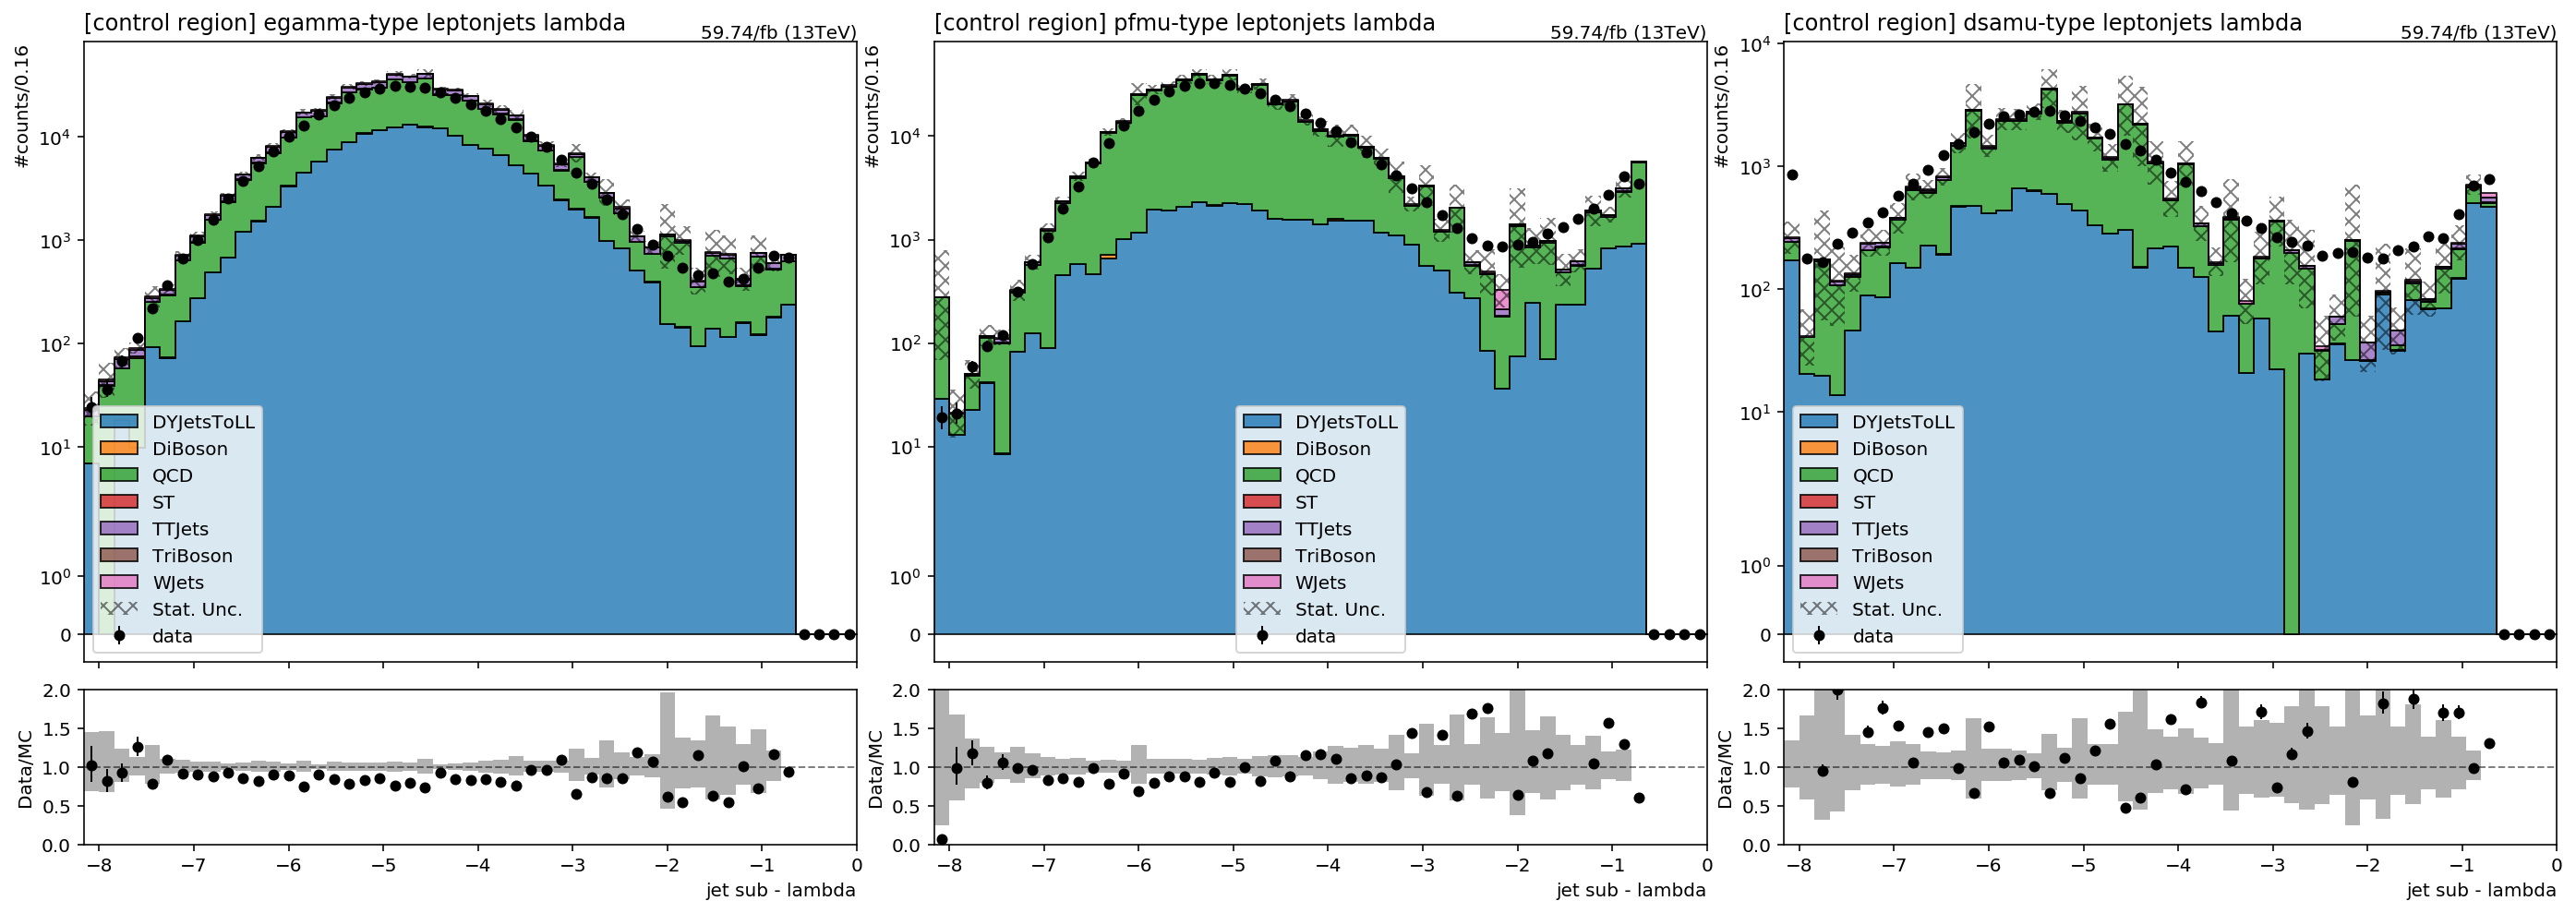

In [25]:
makeplot('lead_lamb_cat', 'lambda', overflow='under');

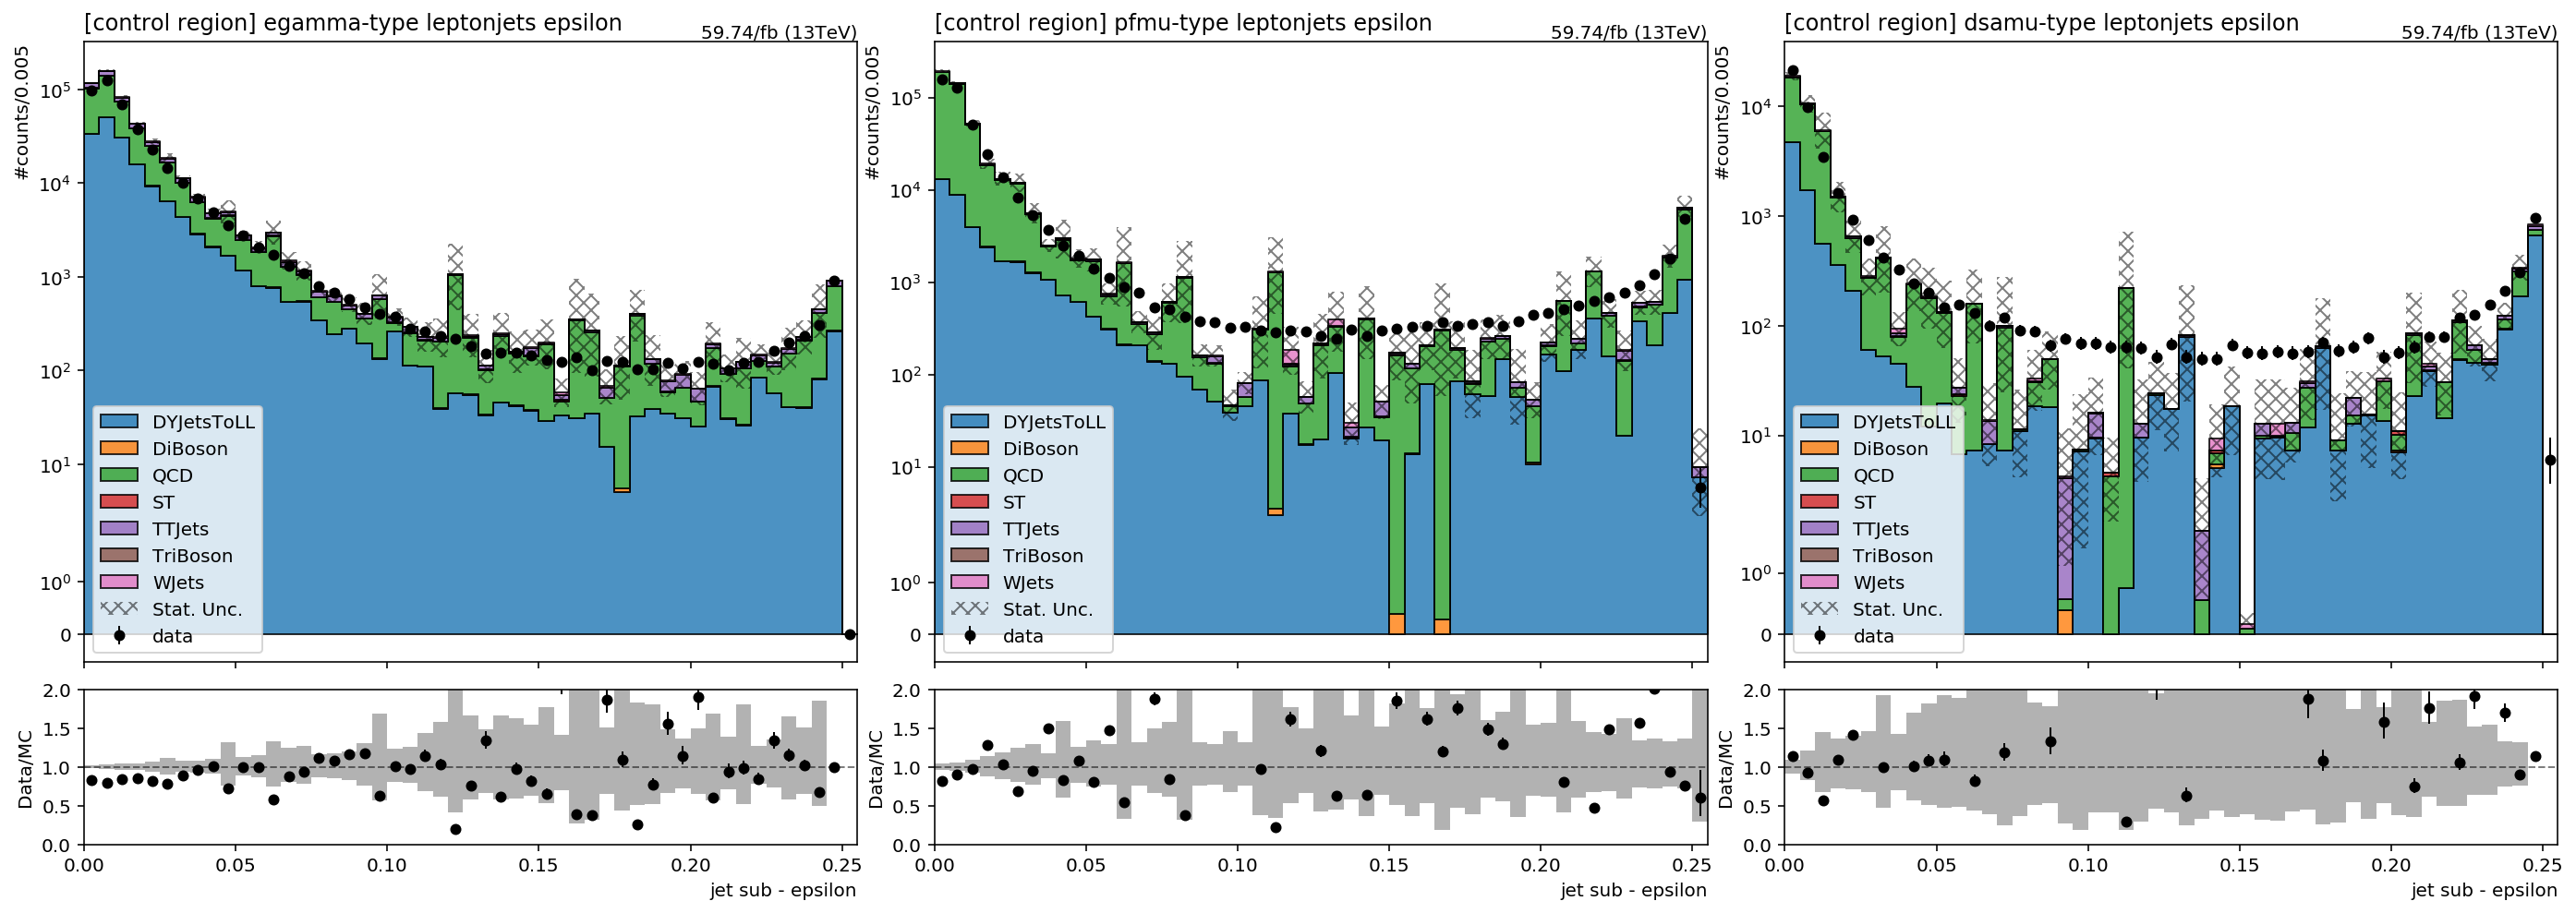

In [26]:
makeplot('lead_epsi_cat', 'epsilon');

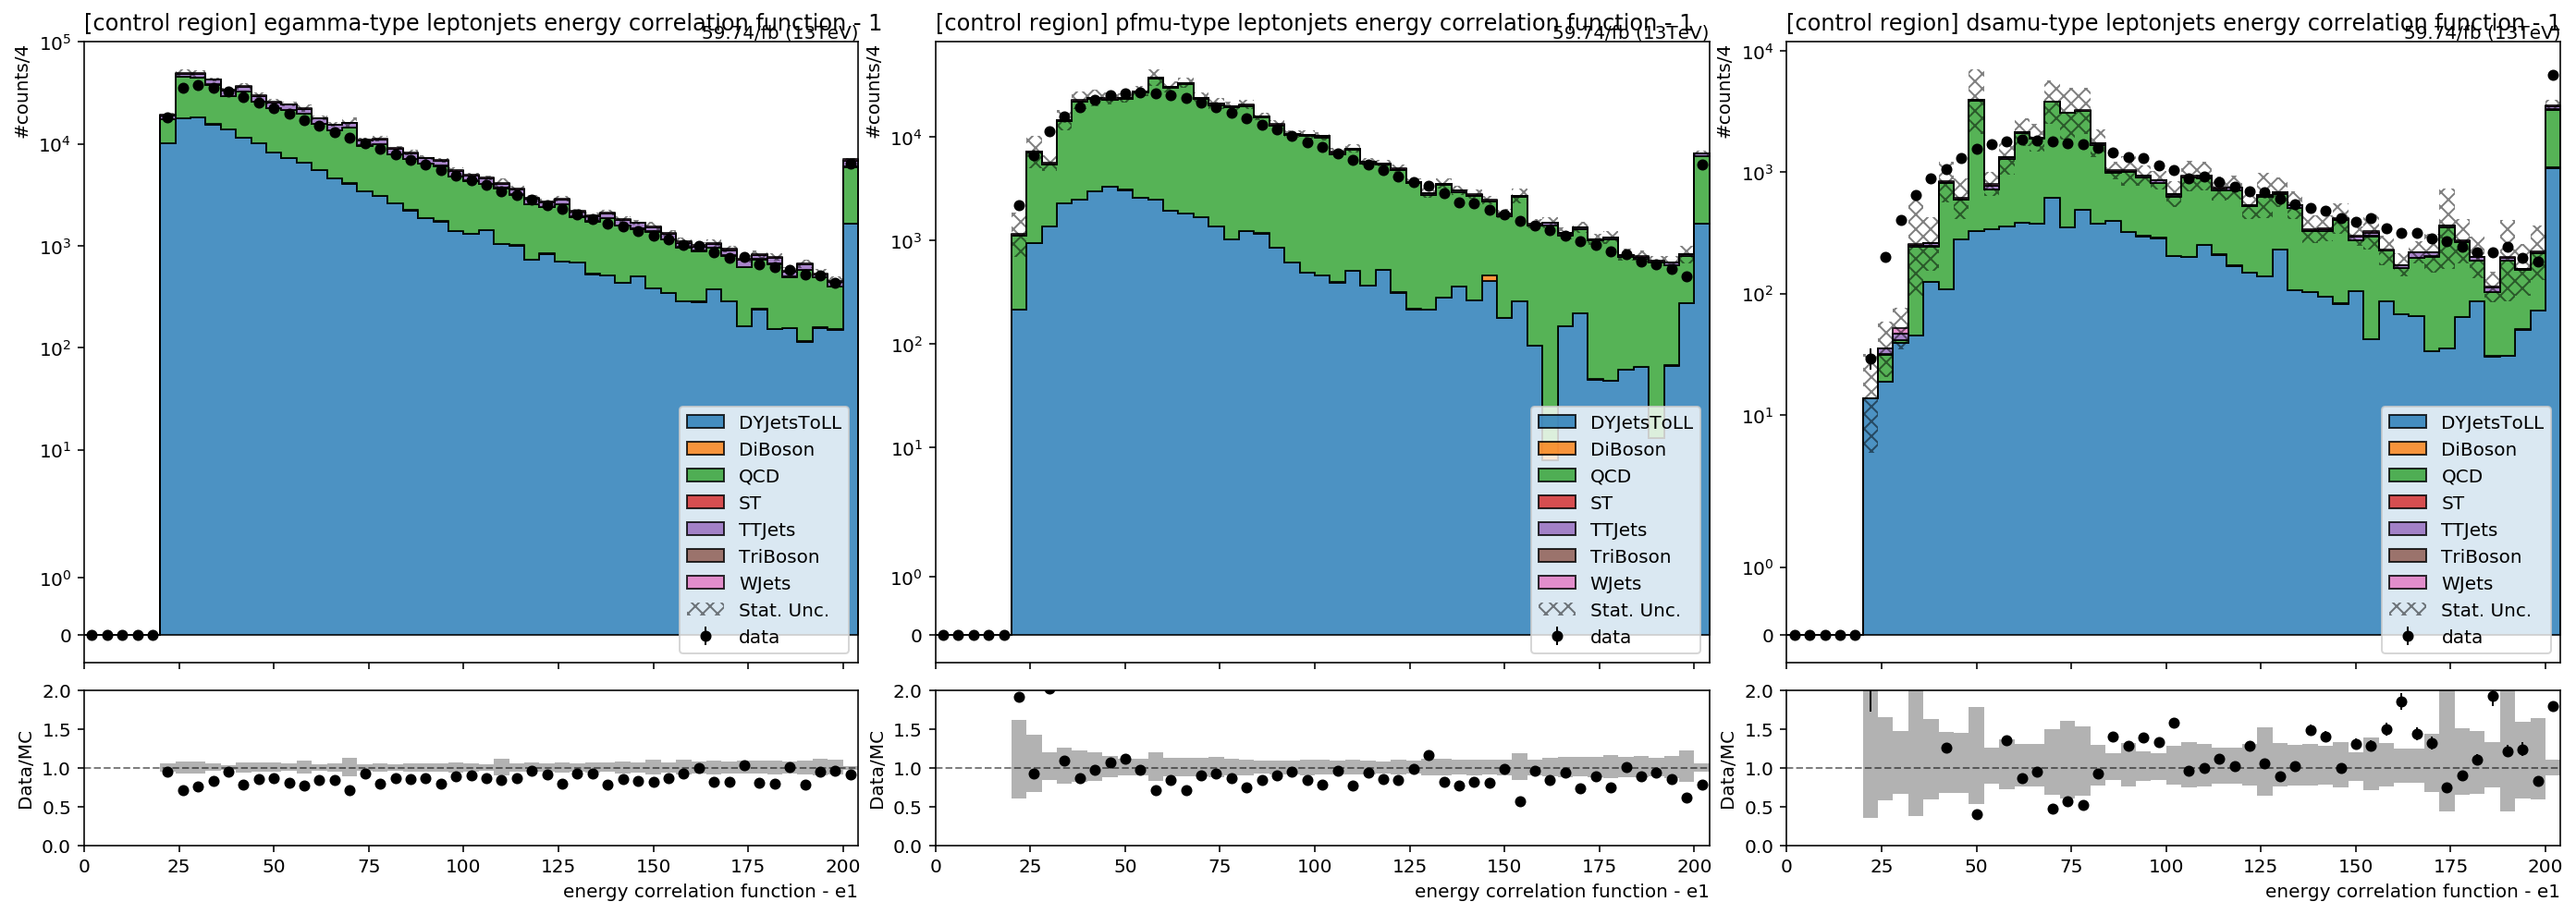

In [27]:
makeplot('lead_ecfe1_cat', 'energy correlation function - 1');

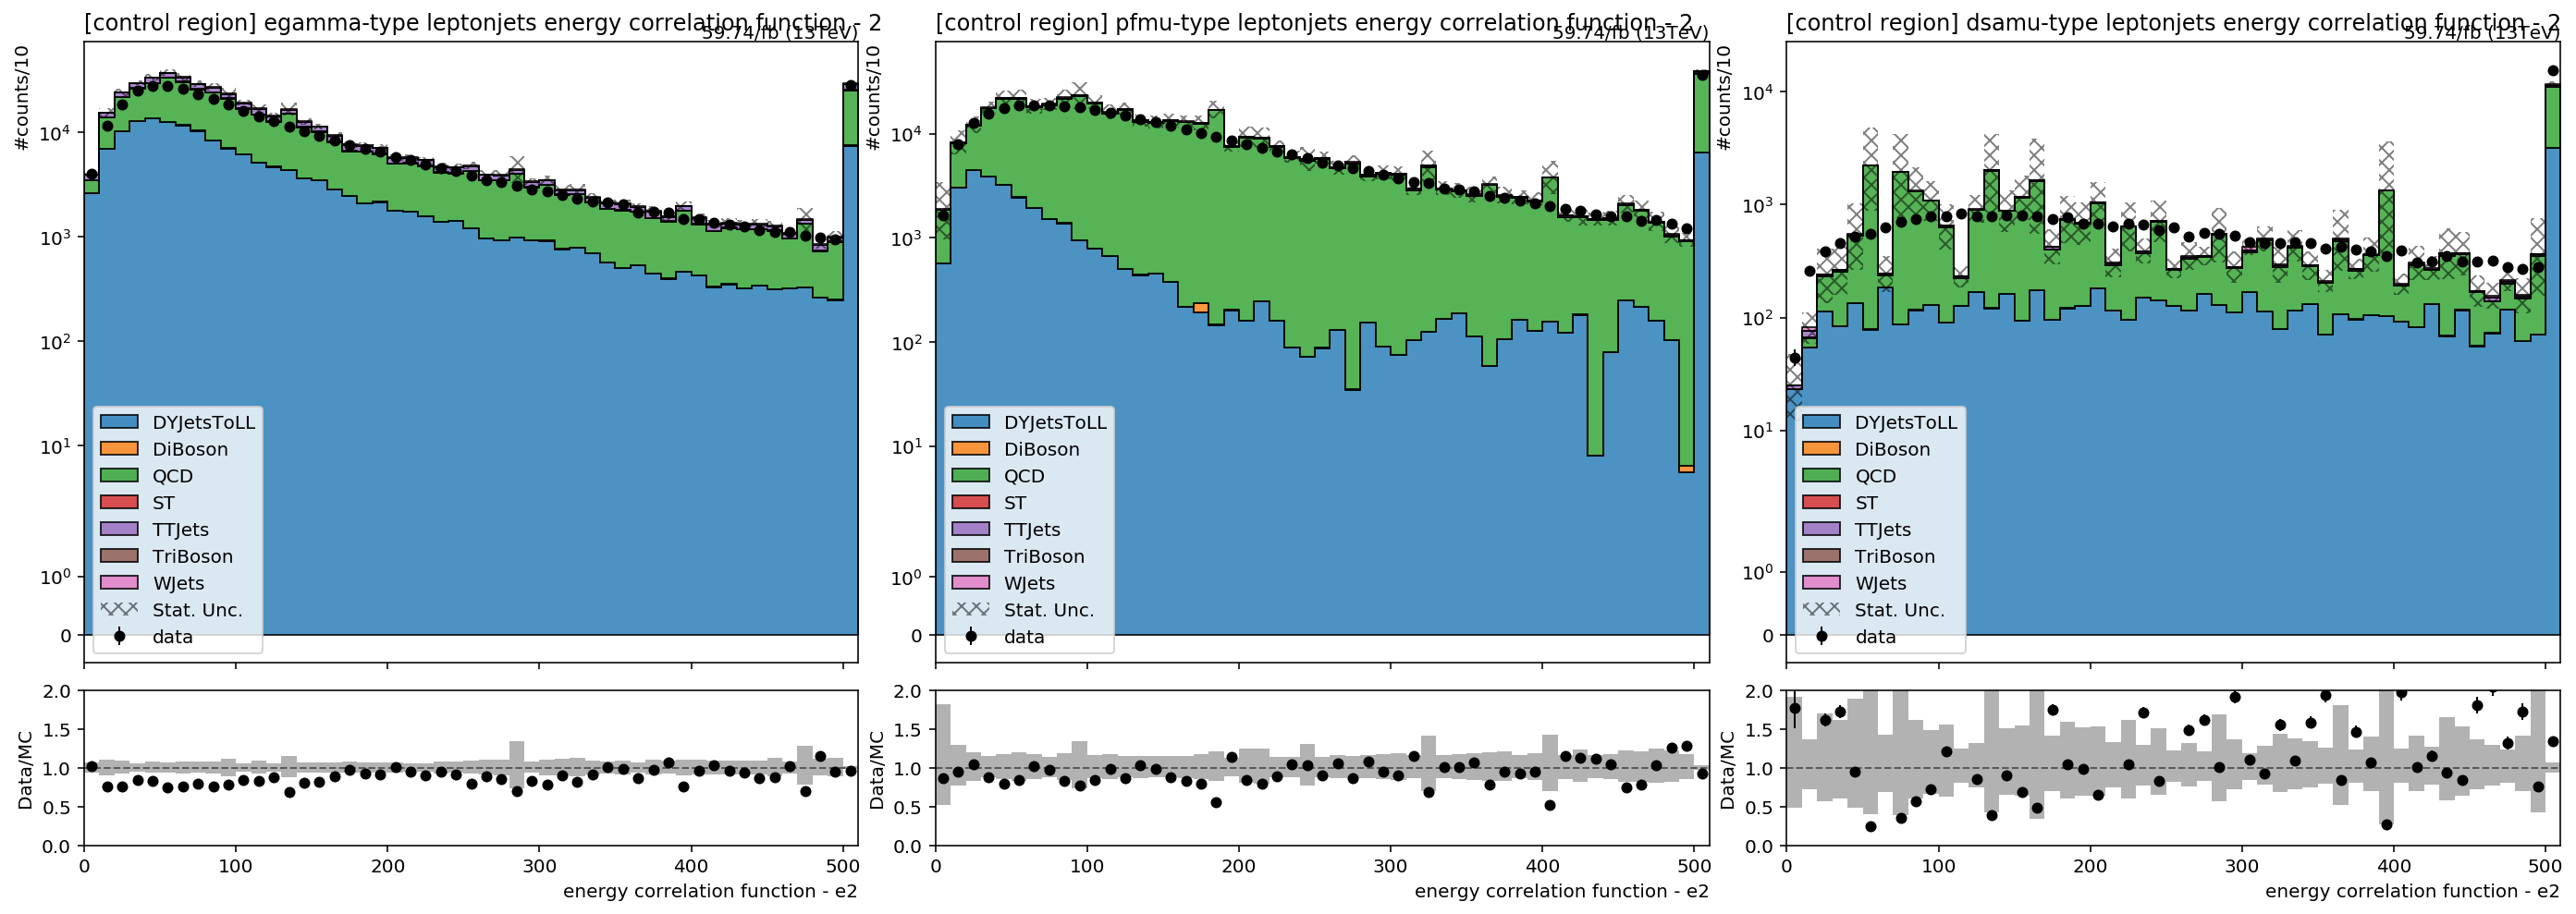

In [28]:
makeplot('lead_ecfe2_cat', 'energy correlation function - 2');

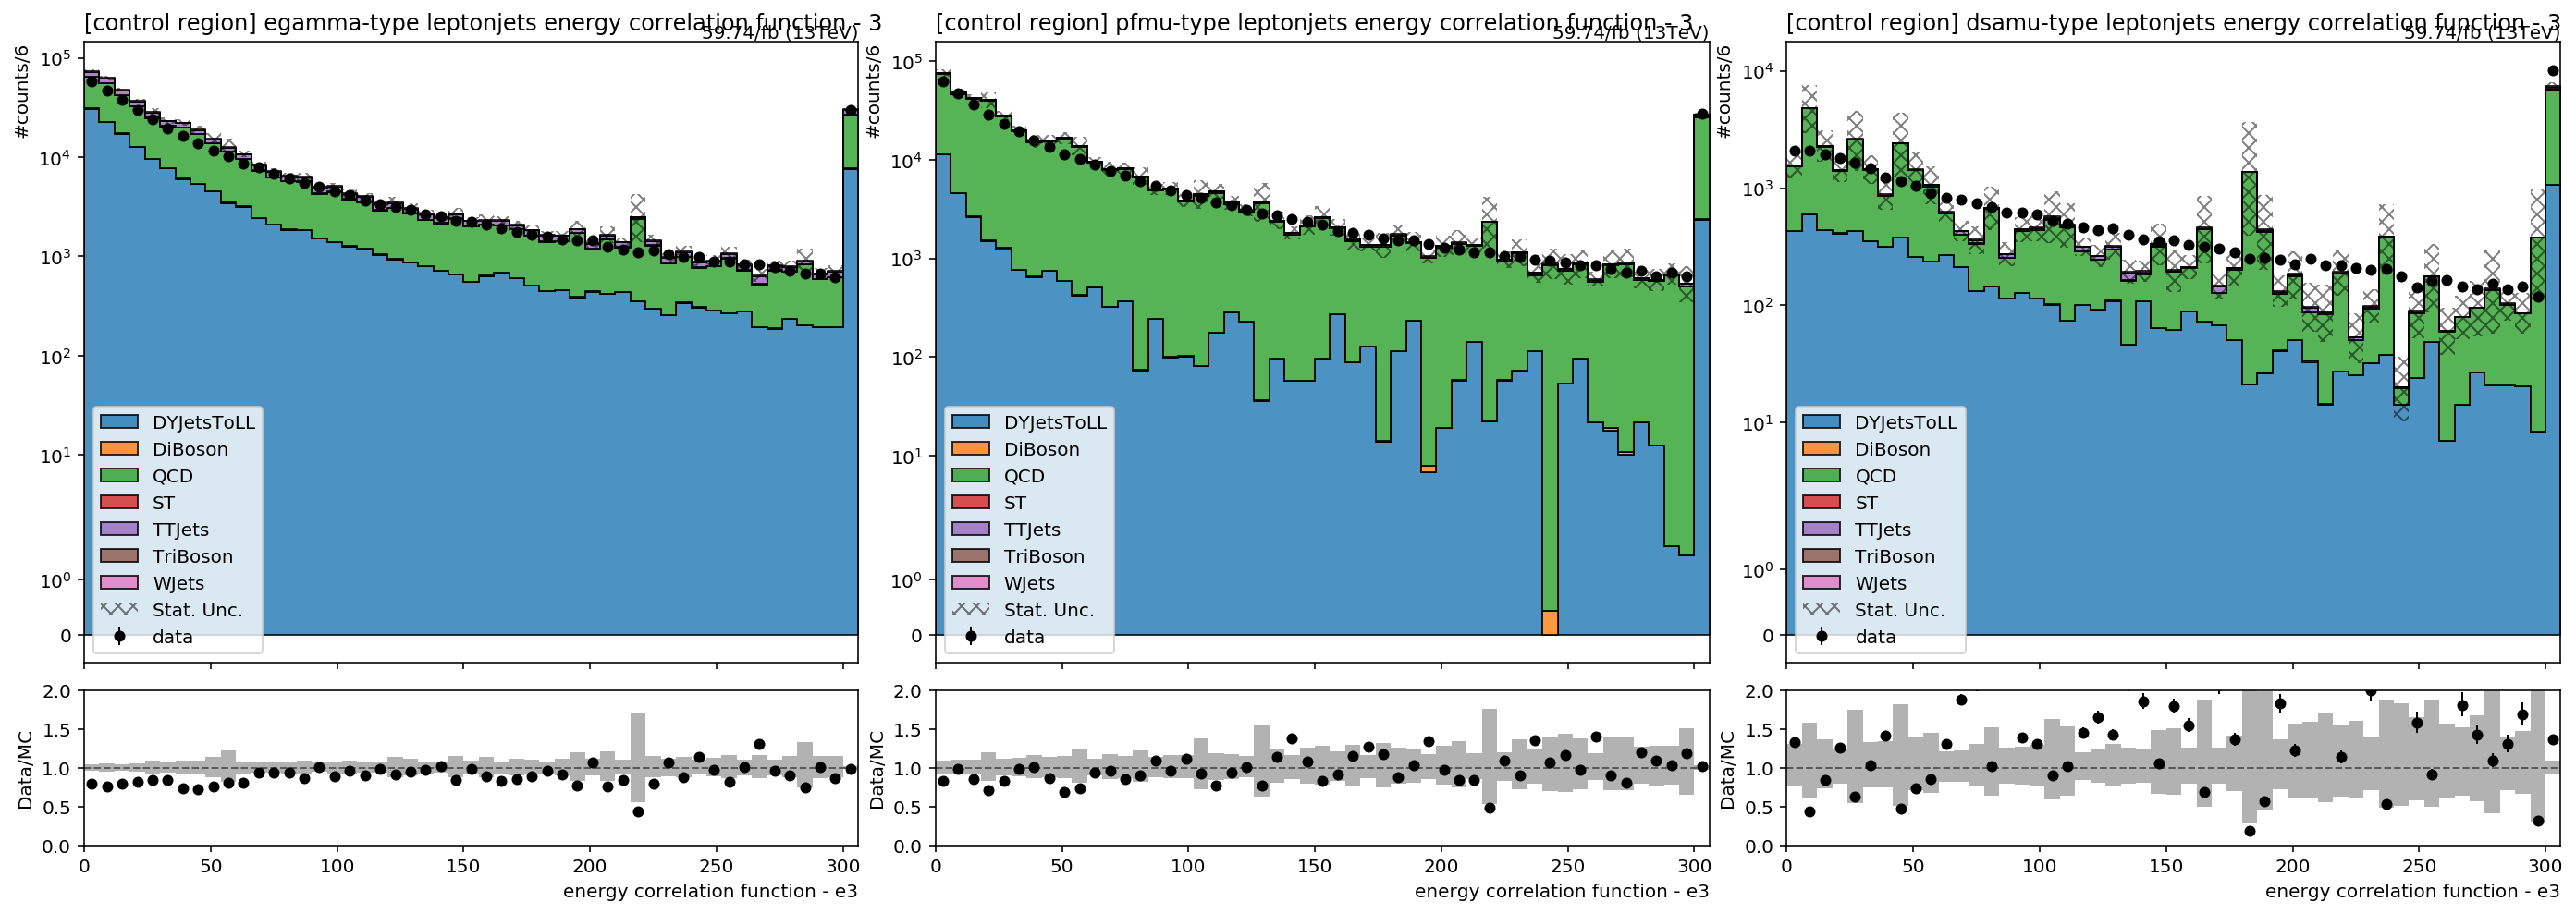

In [29]:
makeplot('lead_ecfe3_cat', 'energy correlation function - 3');

## subleading leptonjets

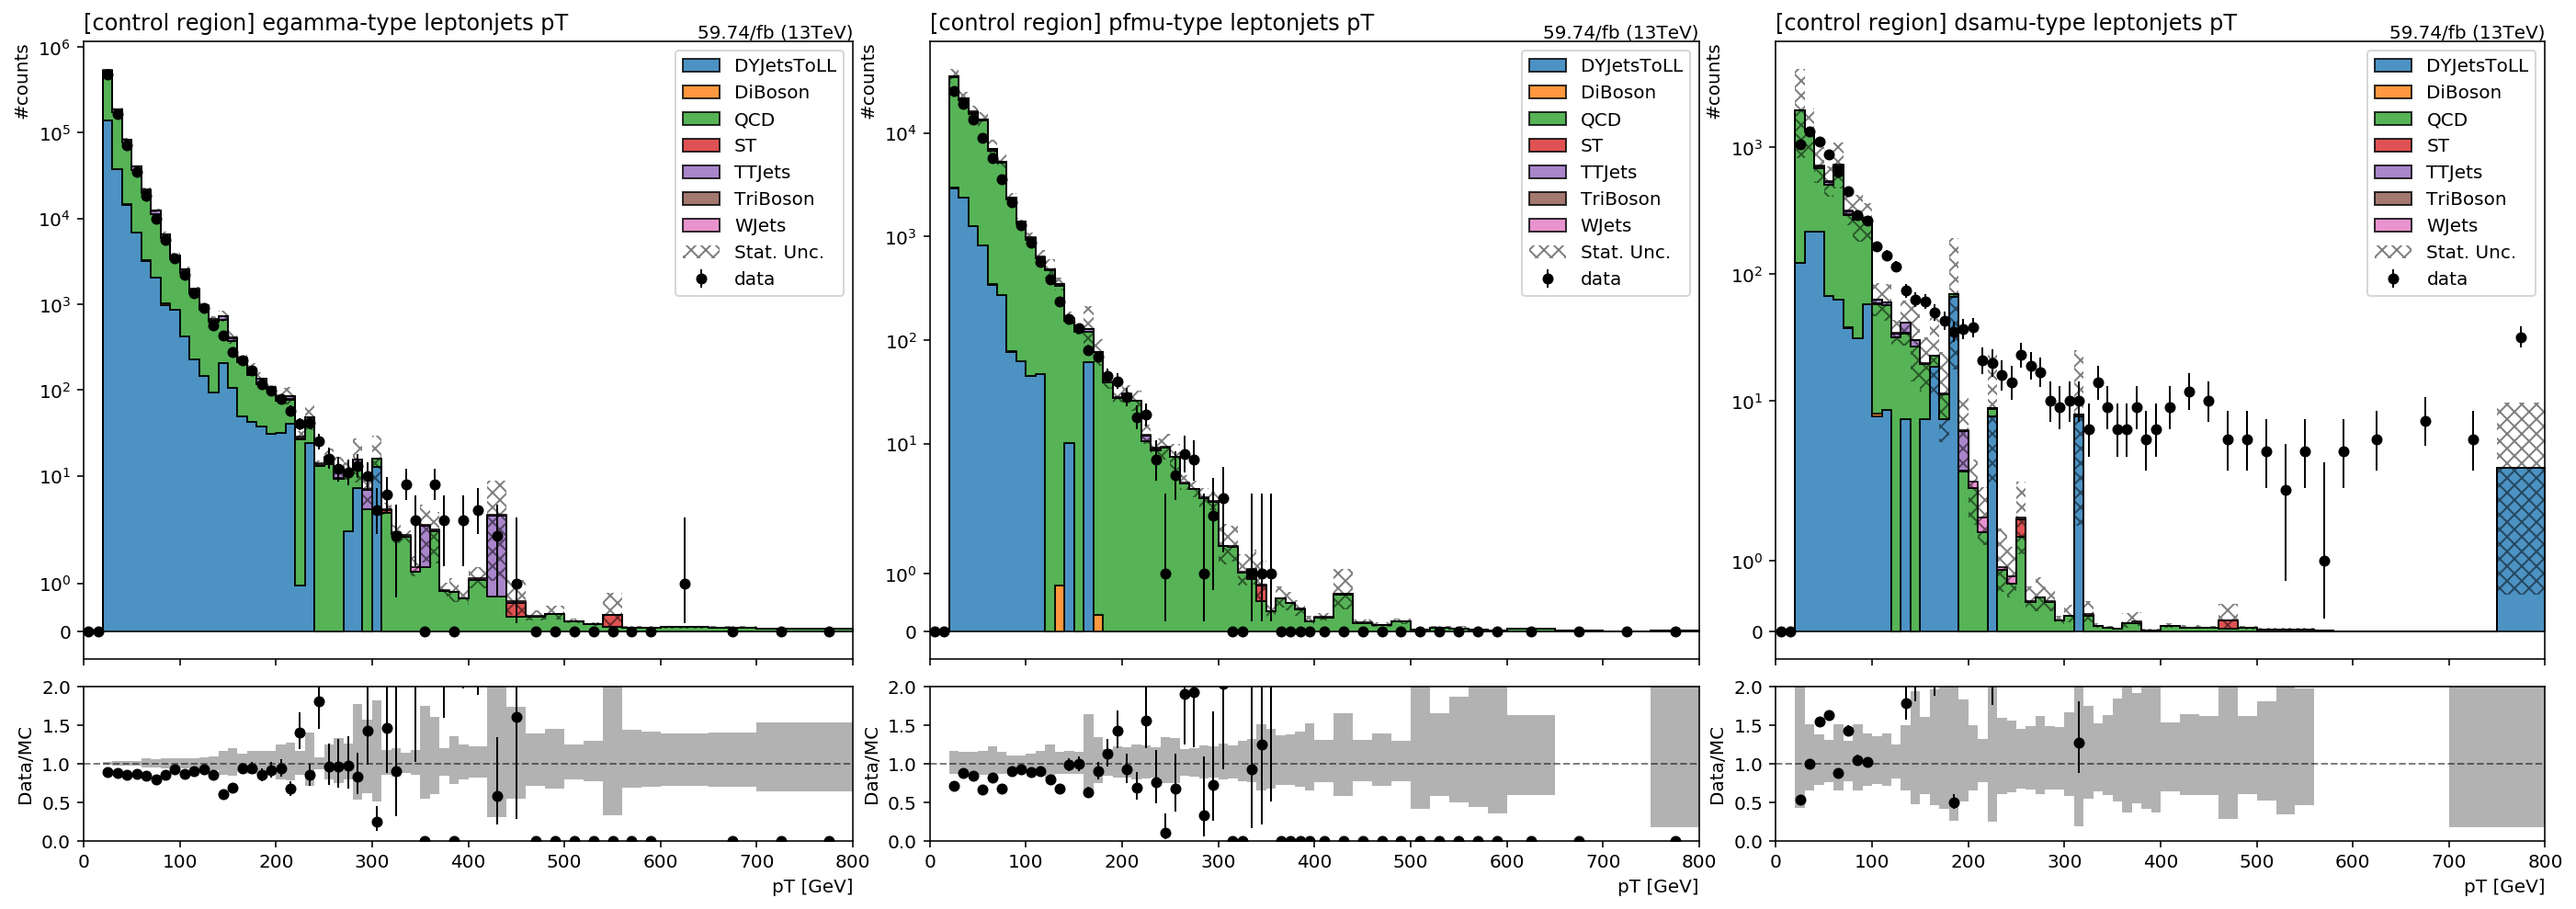

In [30]:
makeplot('subl_pt_cat', 'pT');

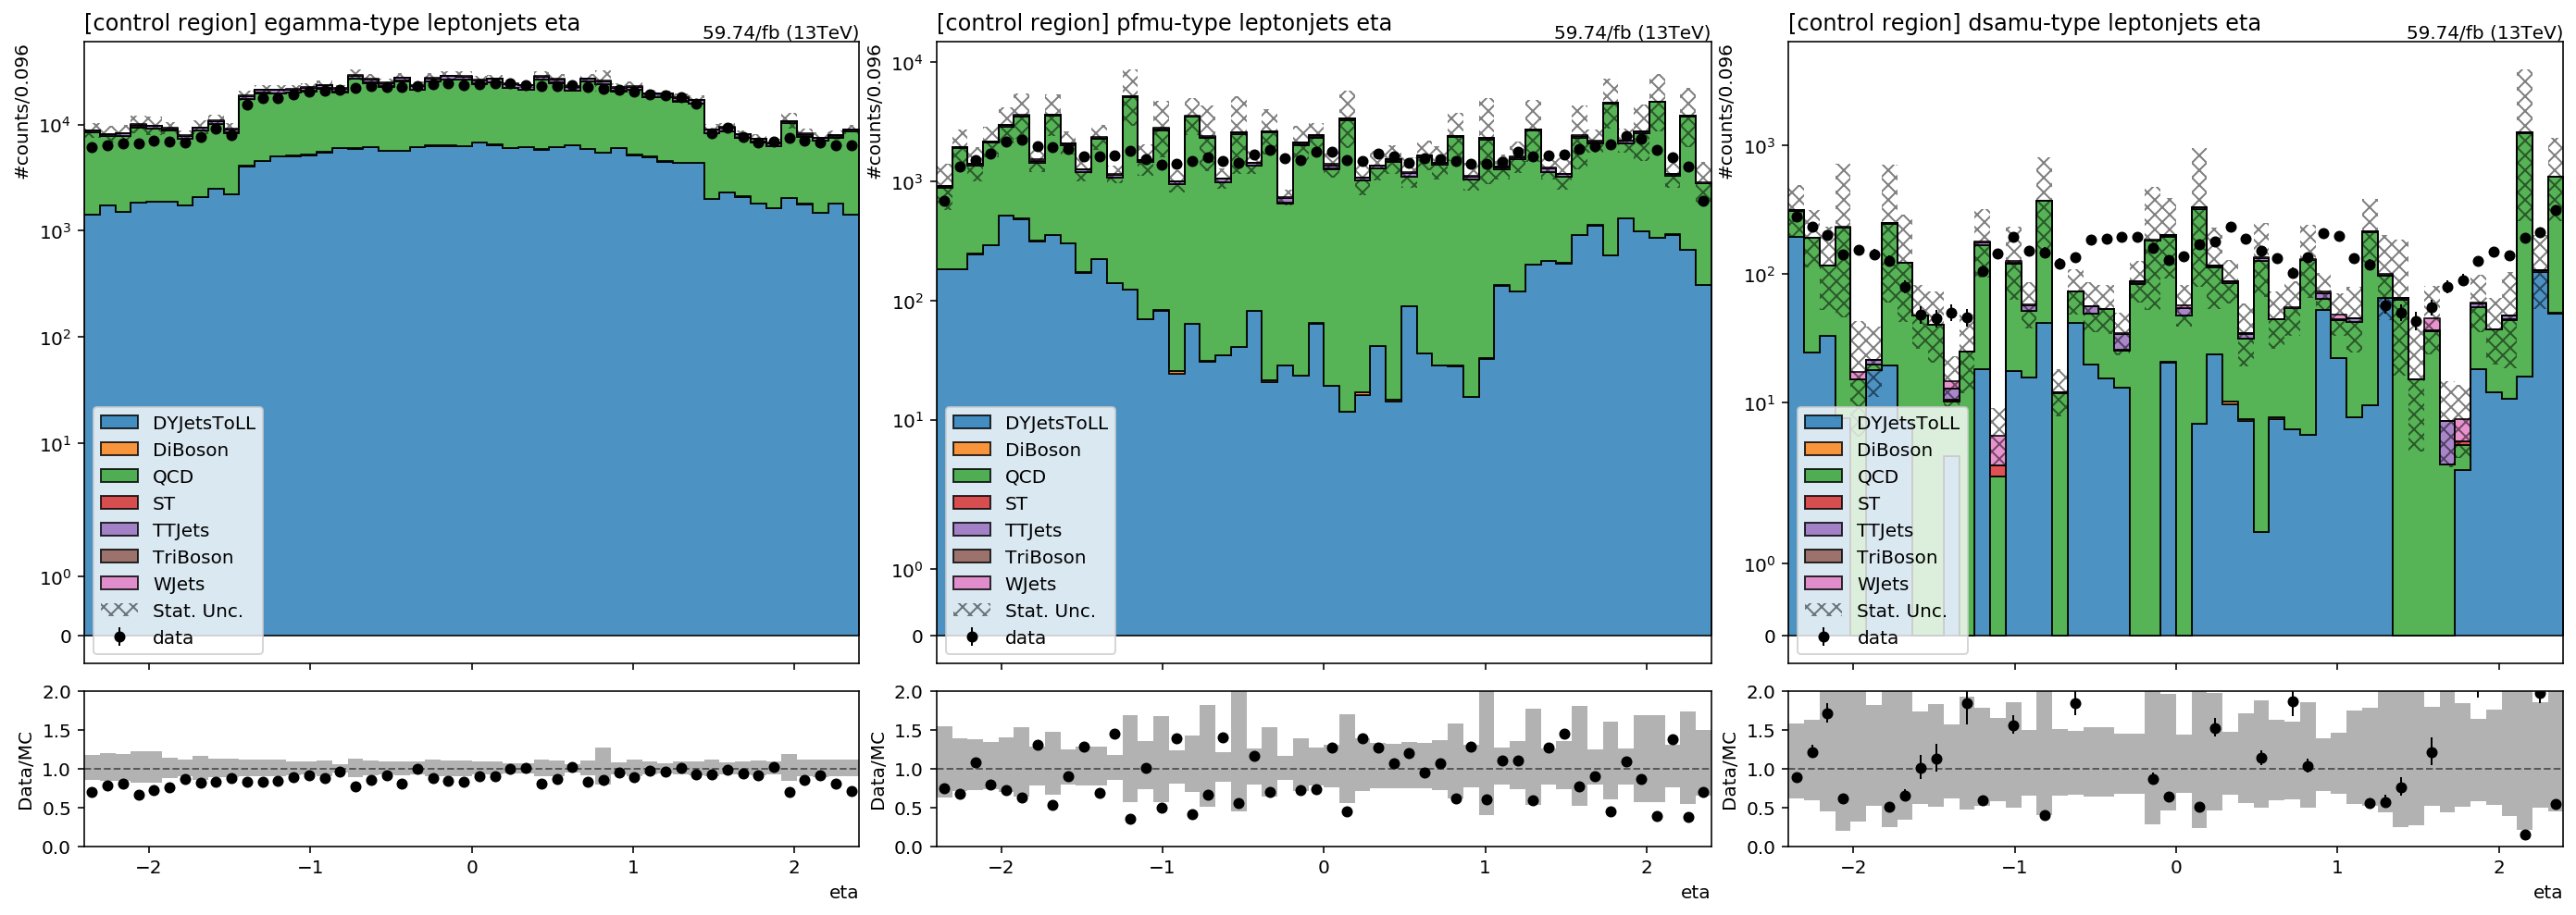

In [31]:
makeplot('subl_eta_cat', 'eta', overflow='none');

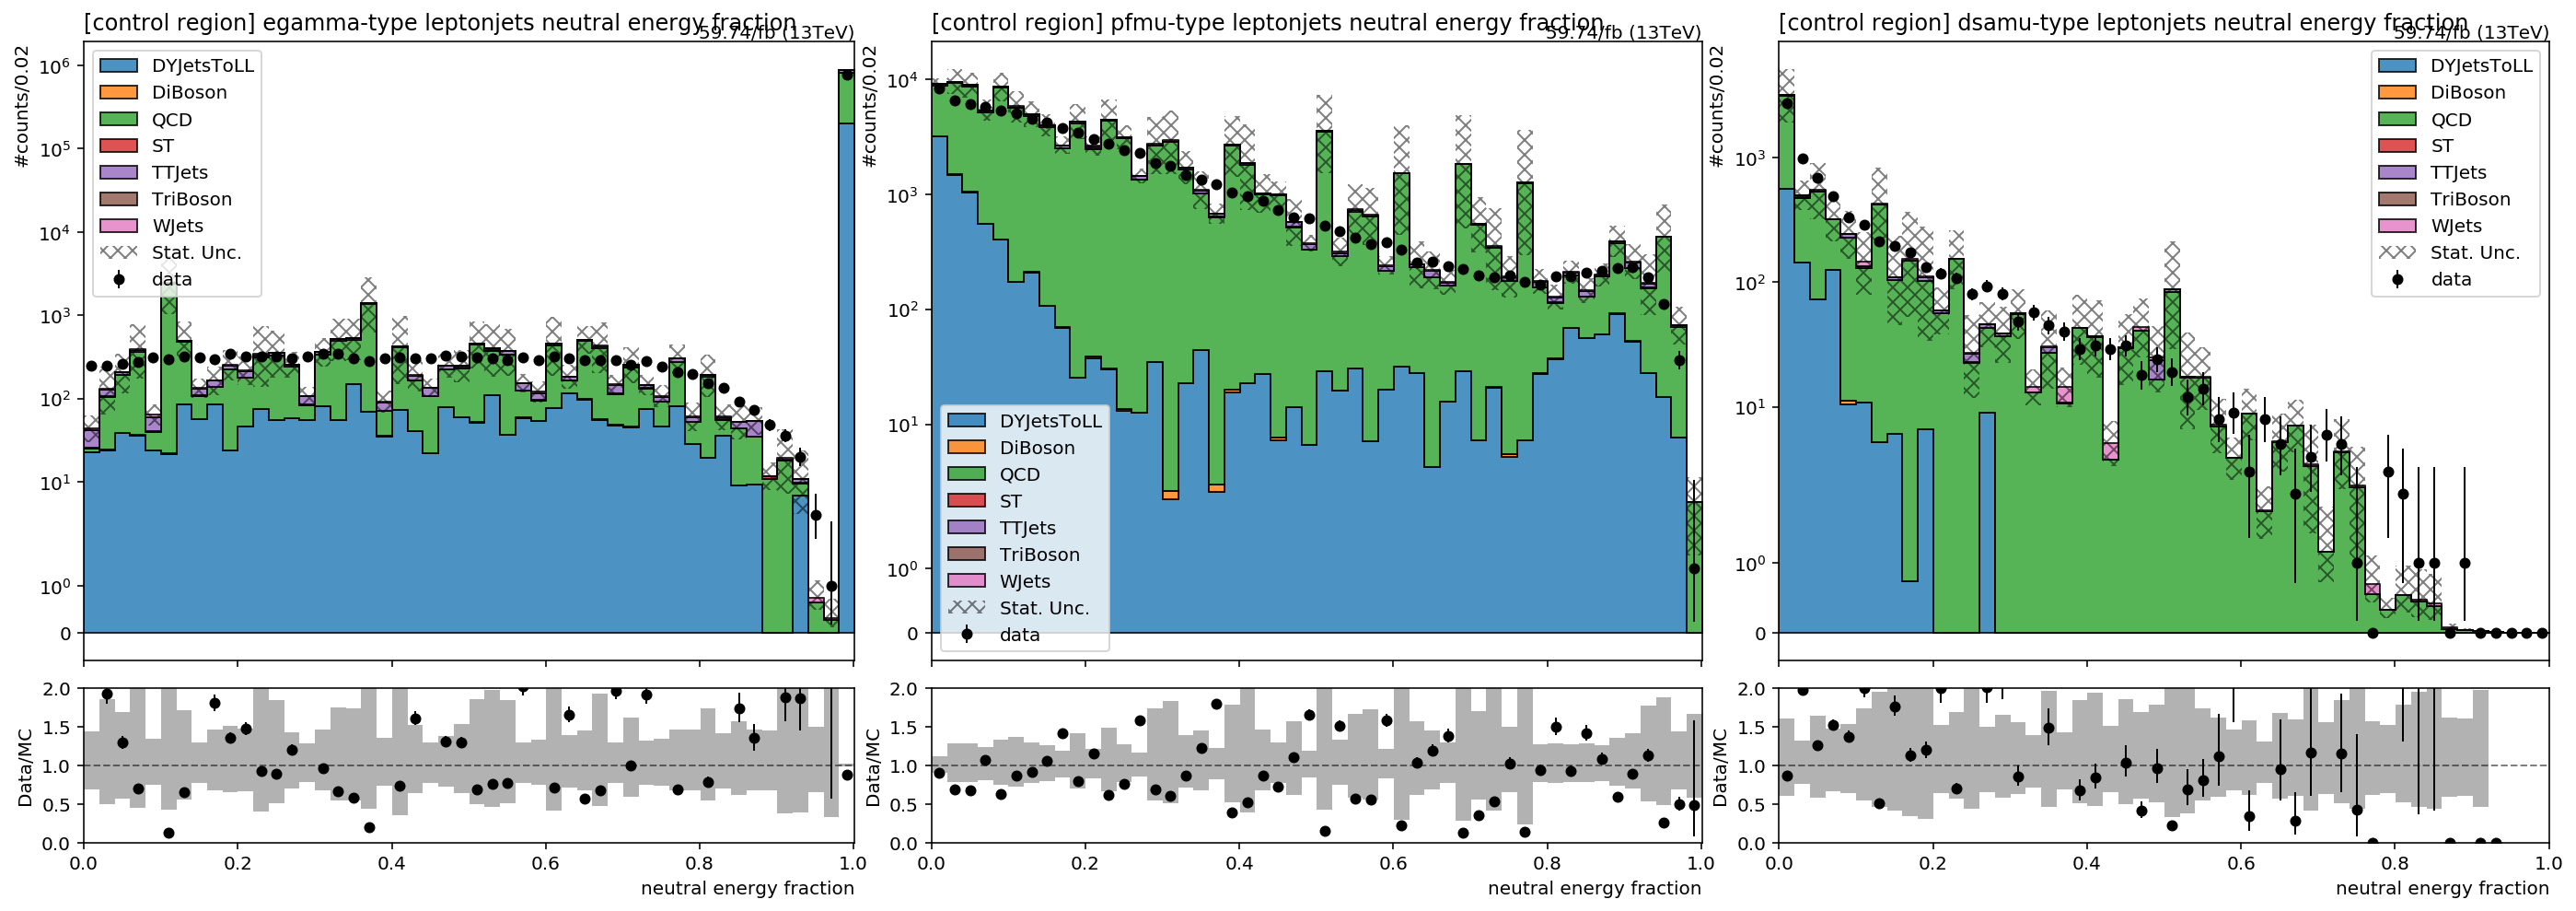

In [32]:
makeplot('subl_nef_cat', 'neutral energy fraction', overflow='none');

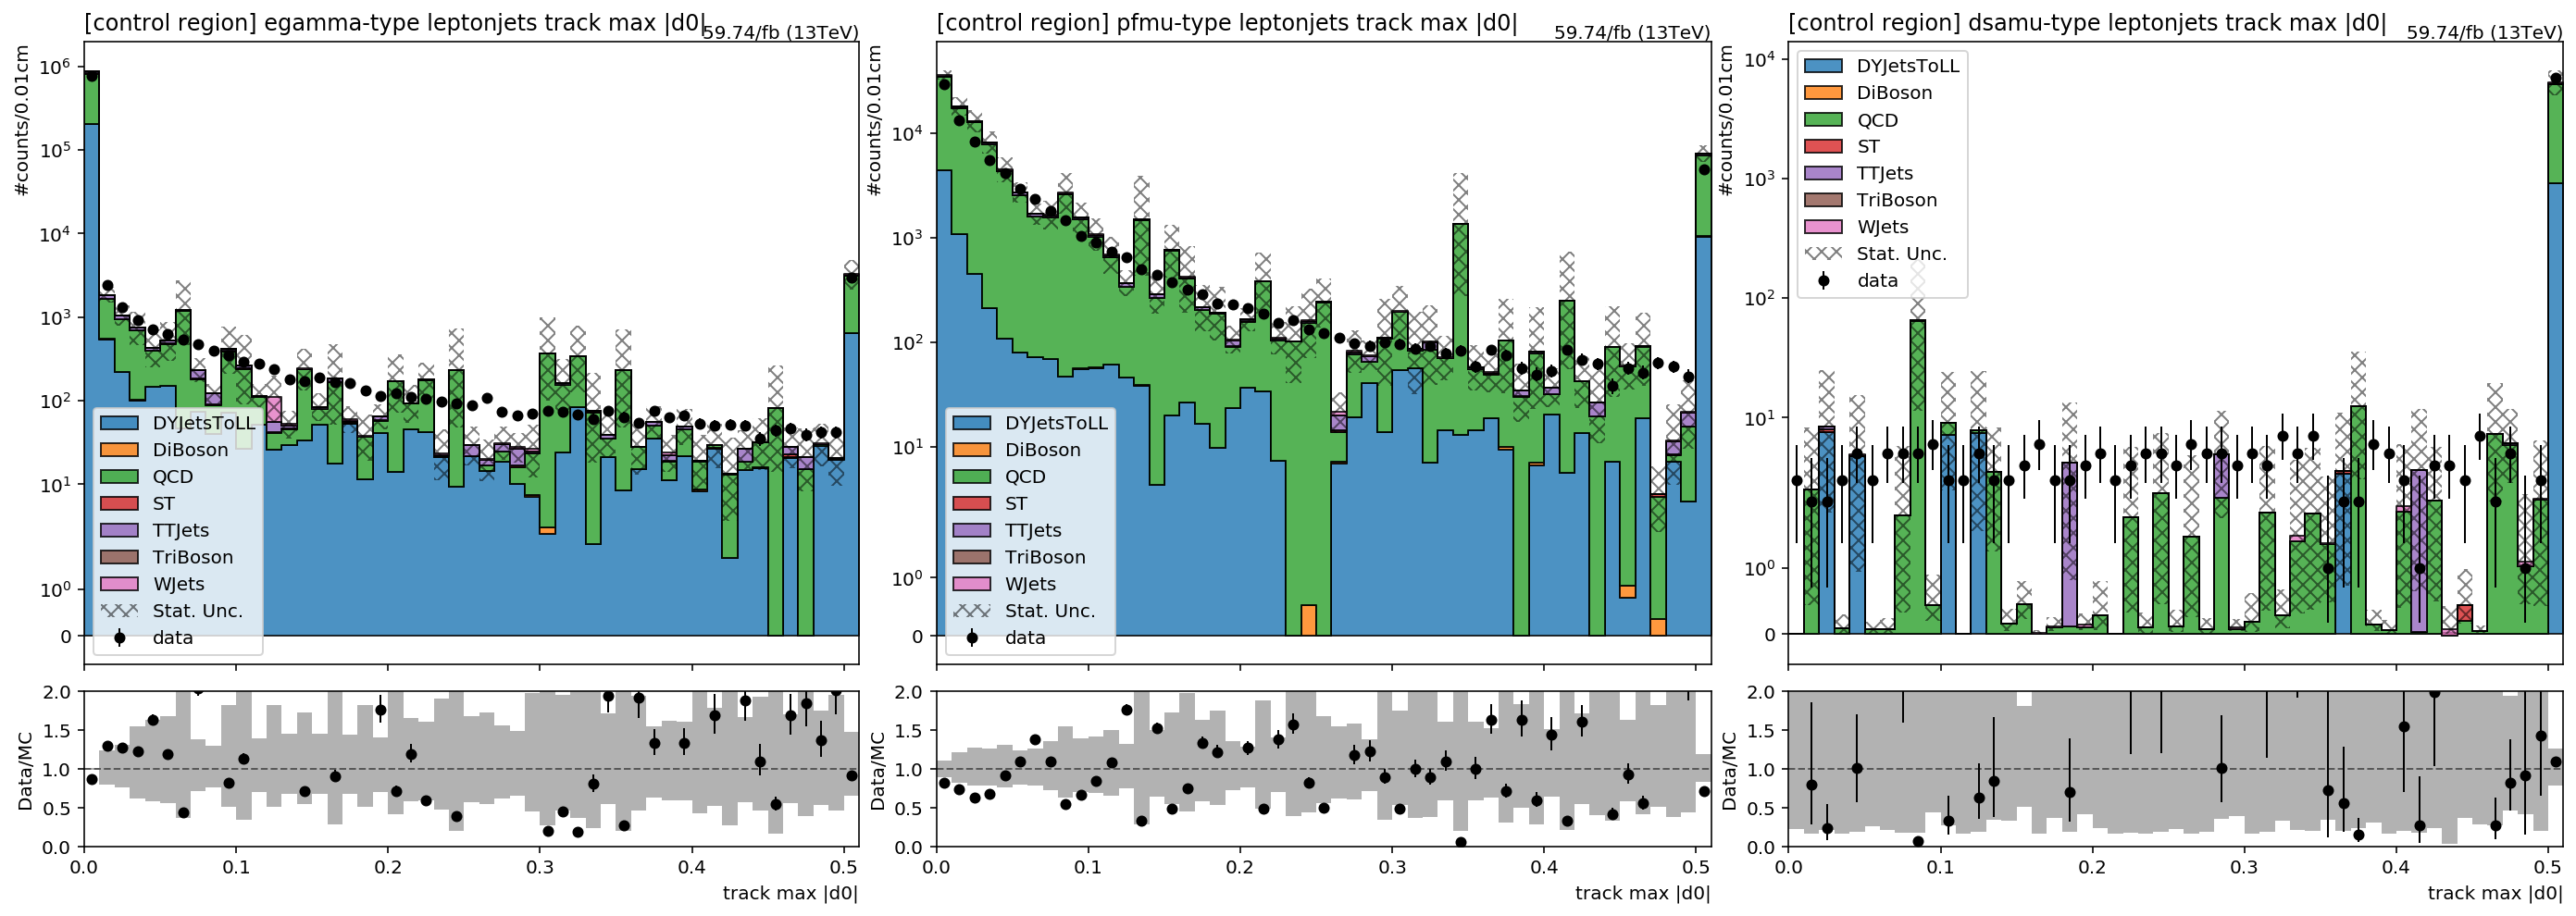

In [33]:
makeplot('subl_maxd0_cat', 'track max |d0|');

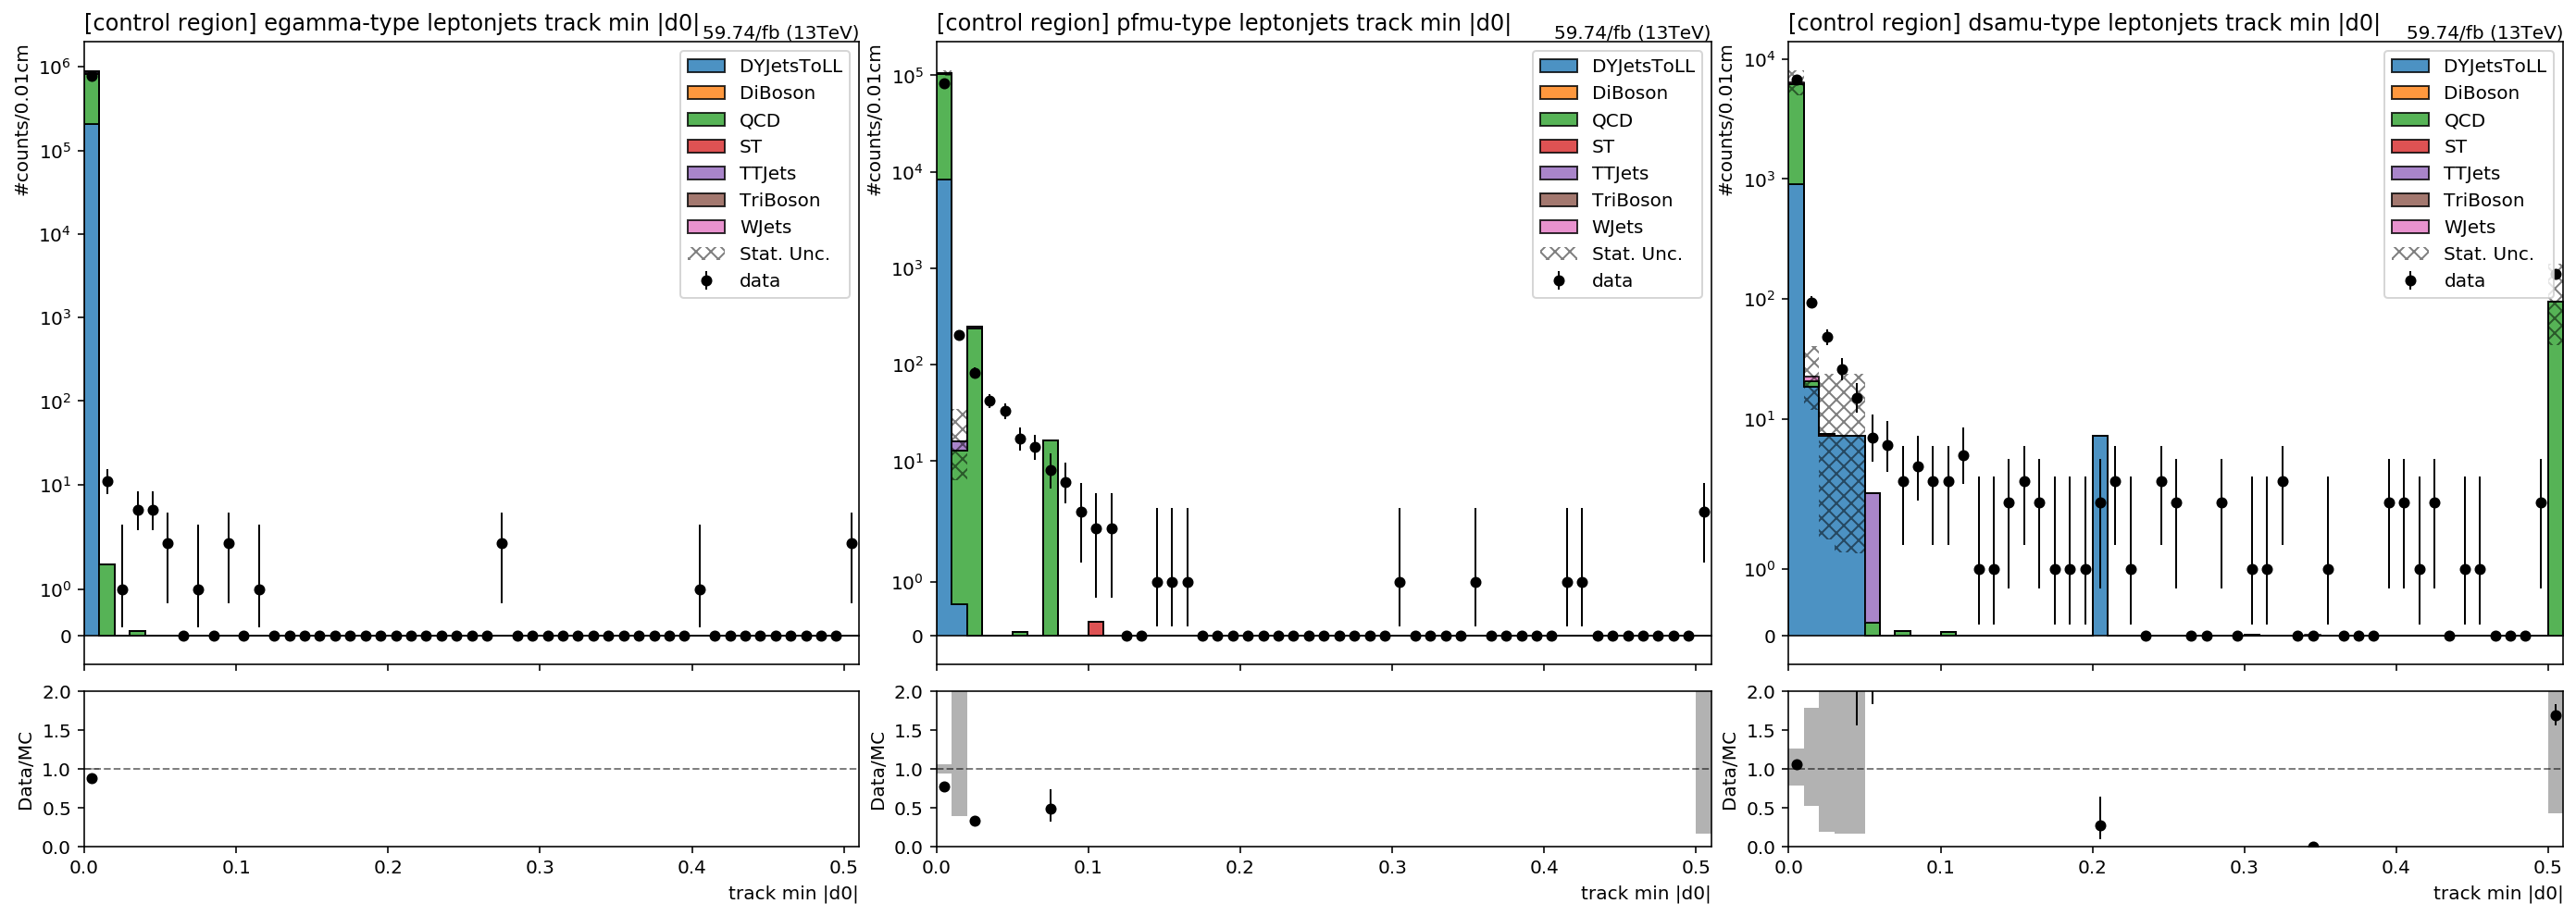

In [34]:
makeplot('subl_mind0_cat', 'track min |d0|');

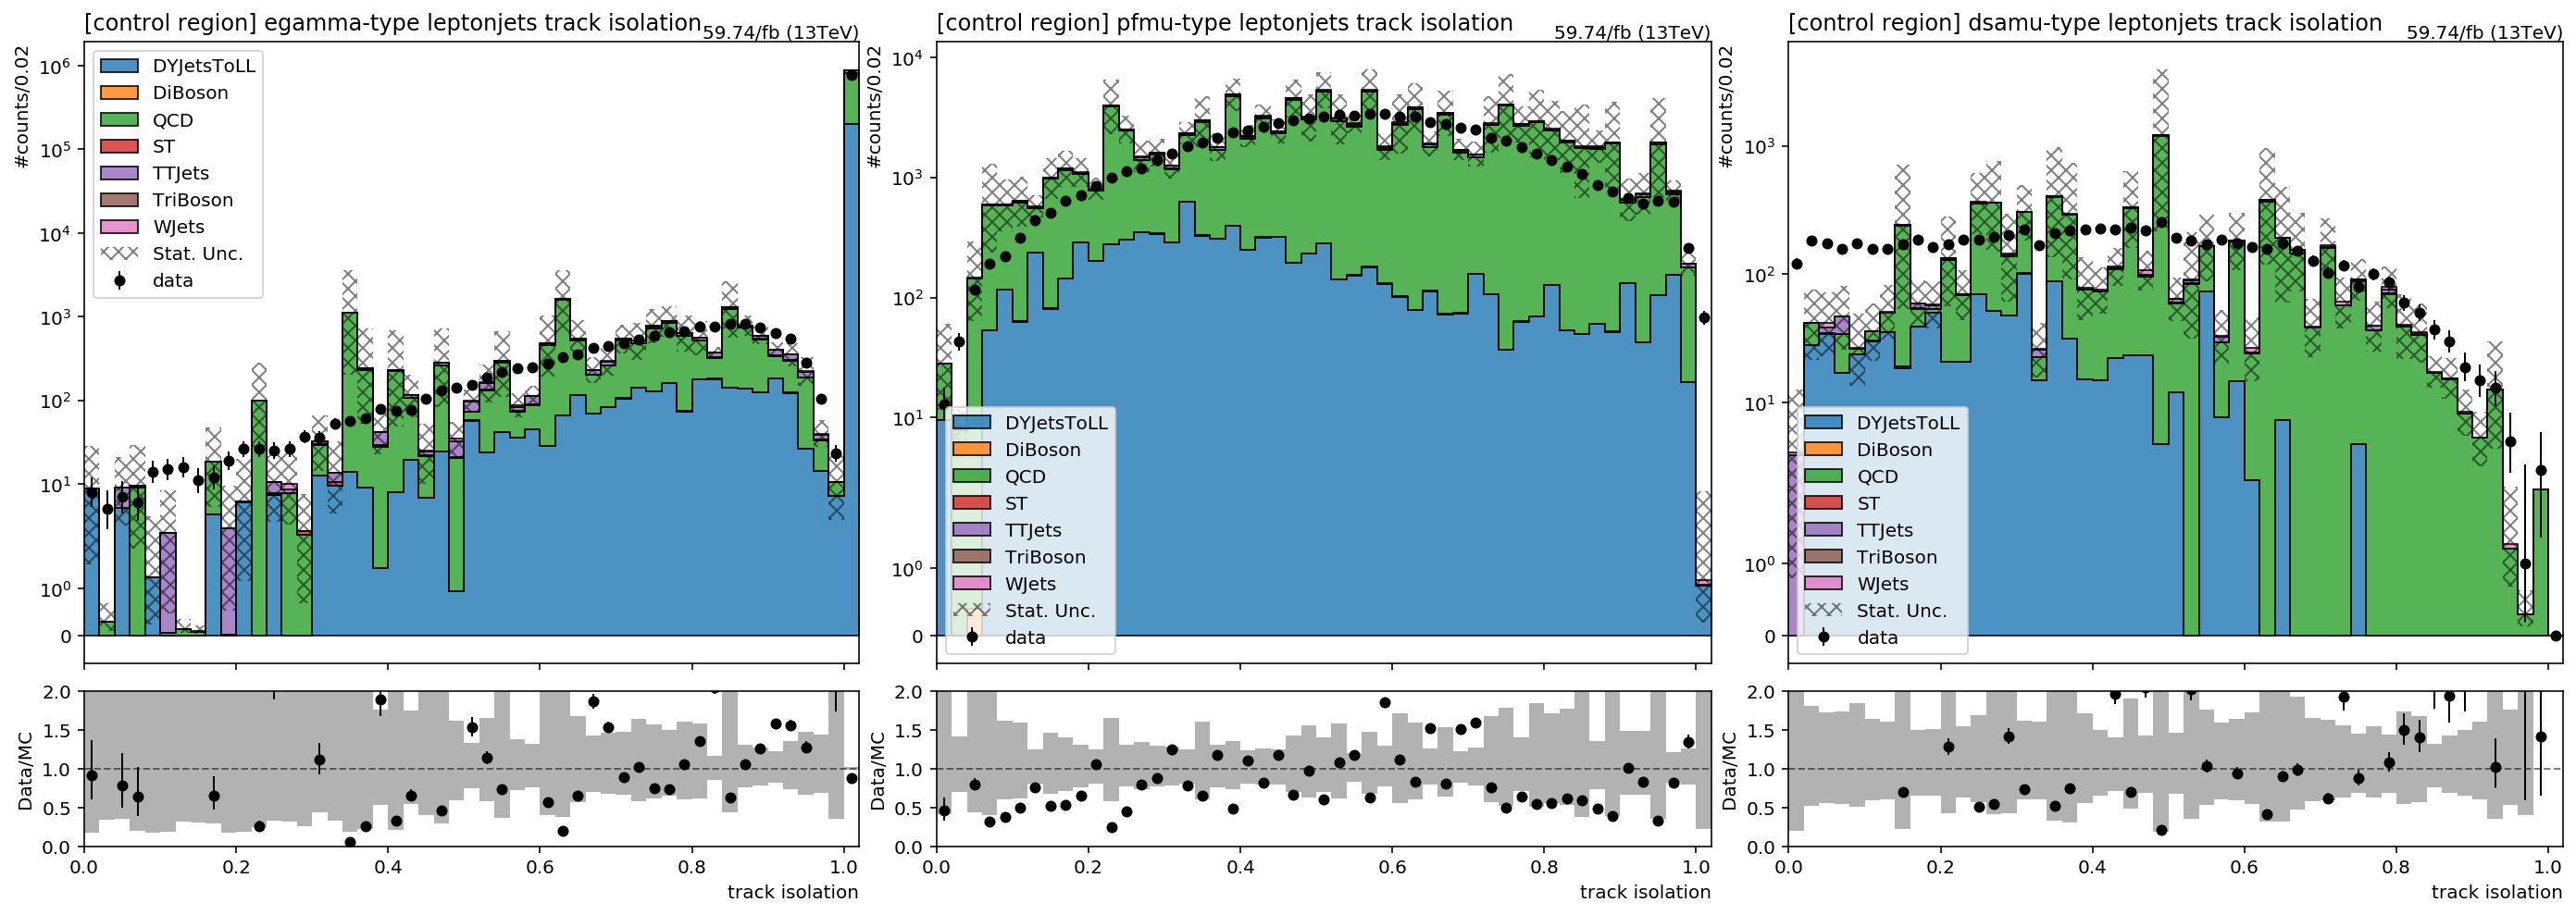

In [35]:
makeplot('subl_tkiso_cat', 'track isolation');

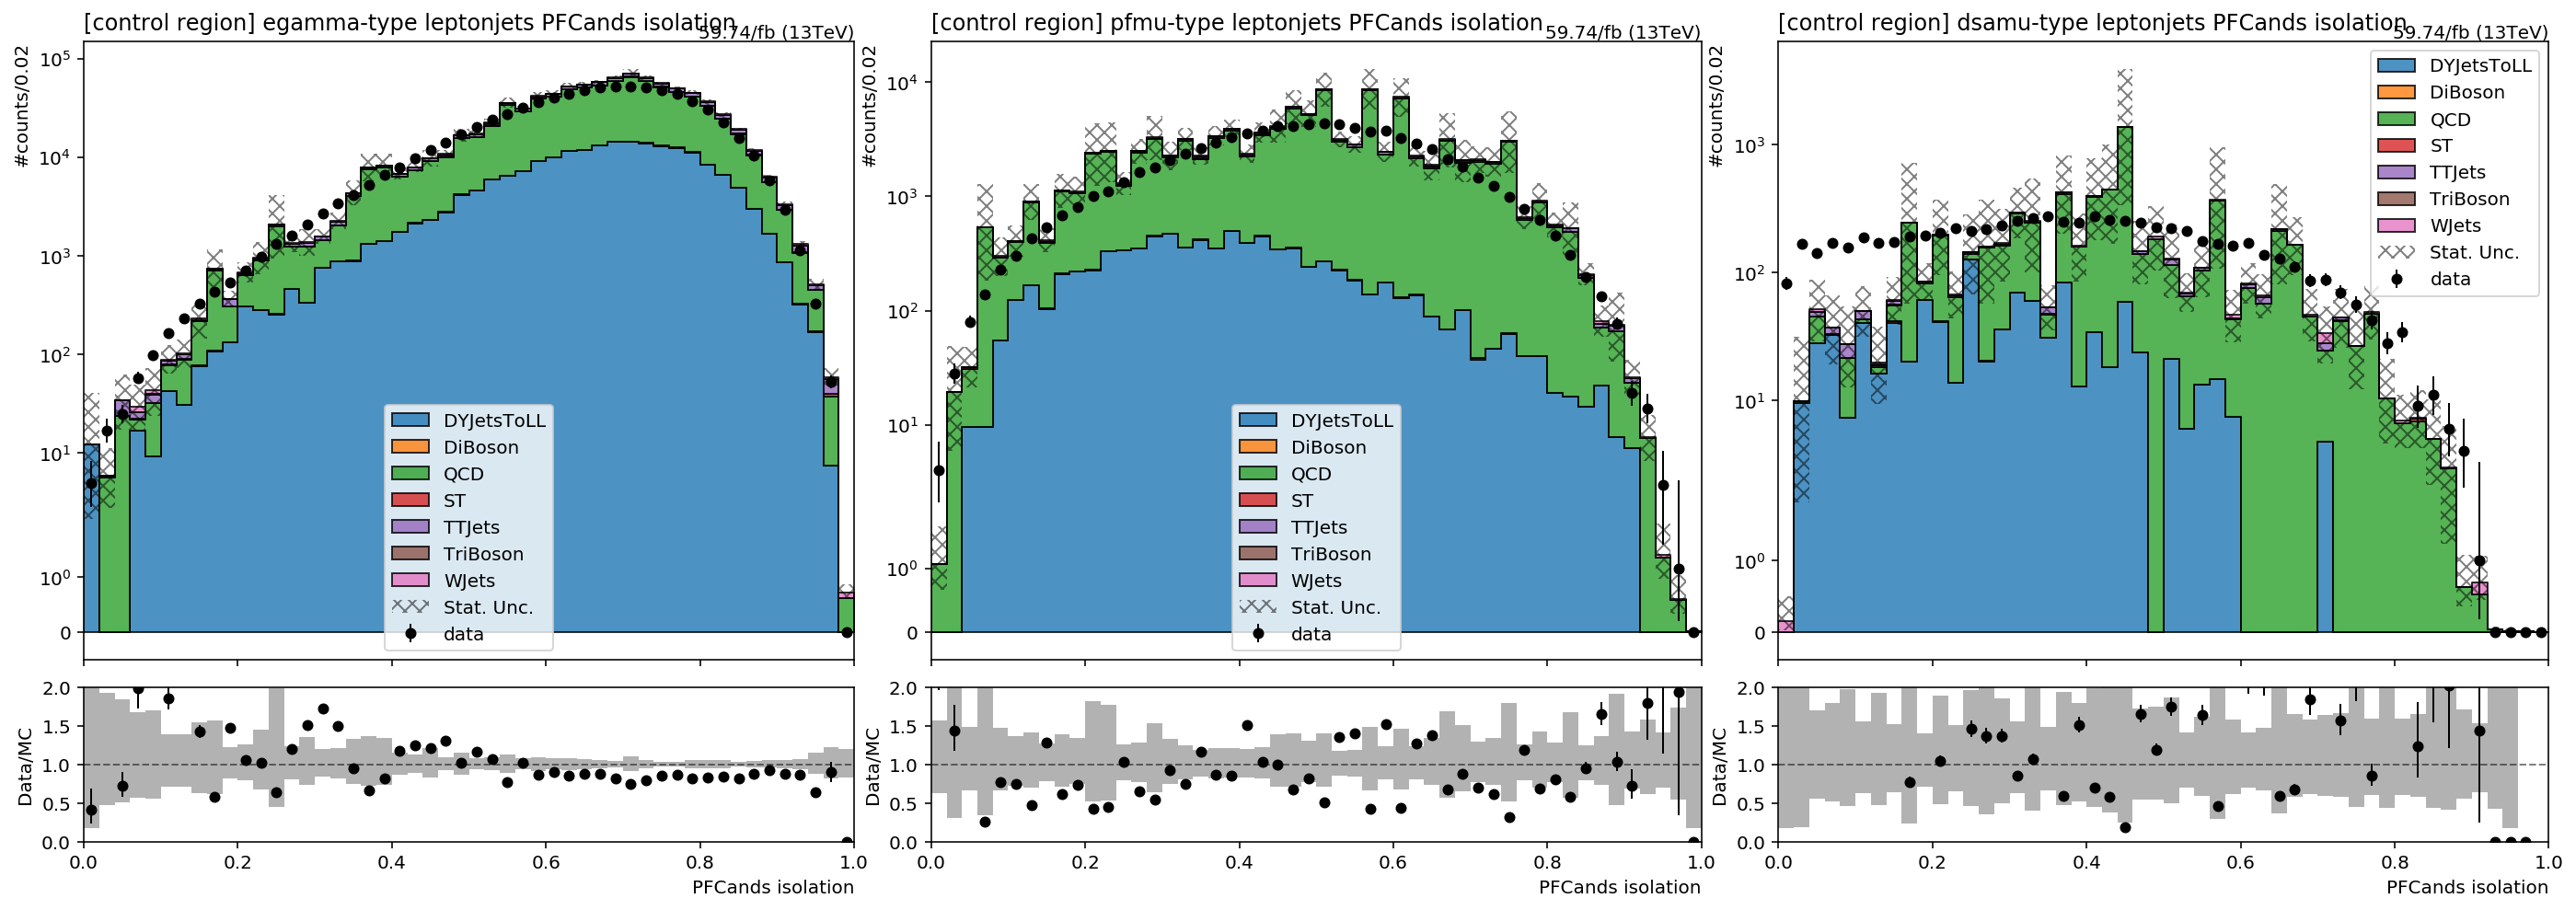

In [36]:
makeplot('subl_pfiso_cat', 'PFCands isolation', overflow='none');

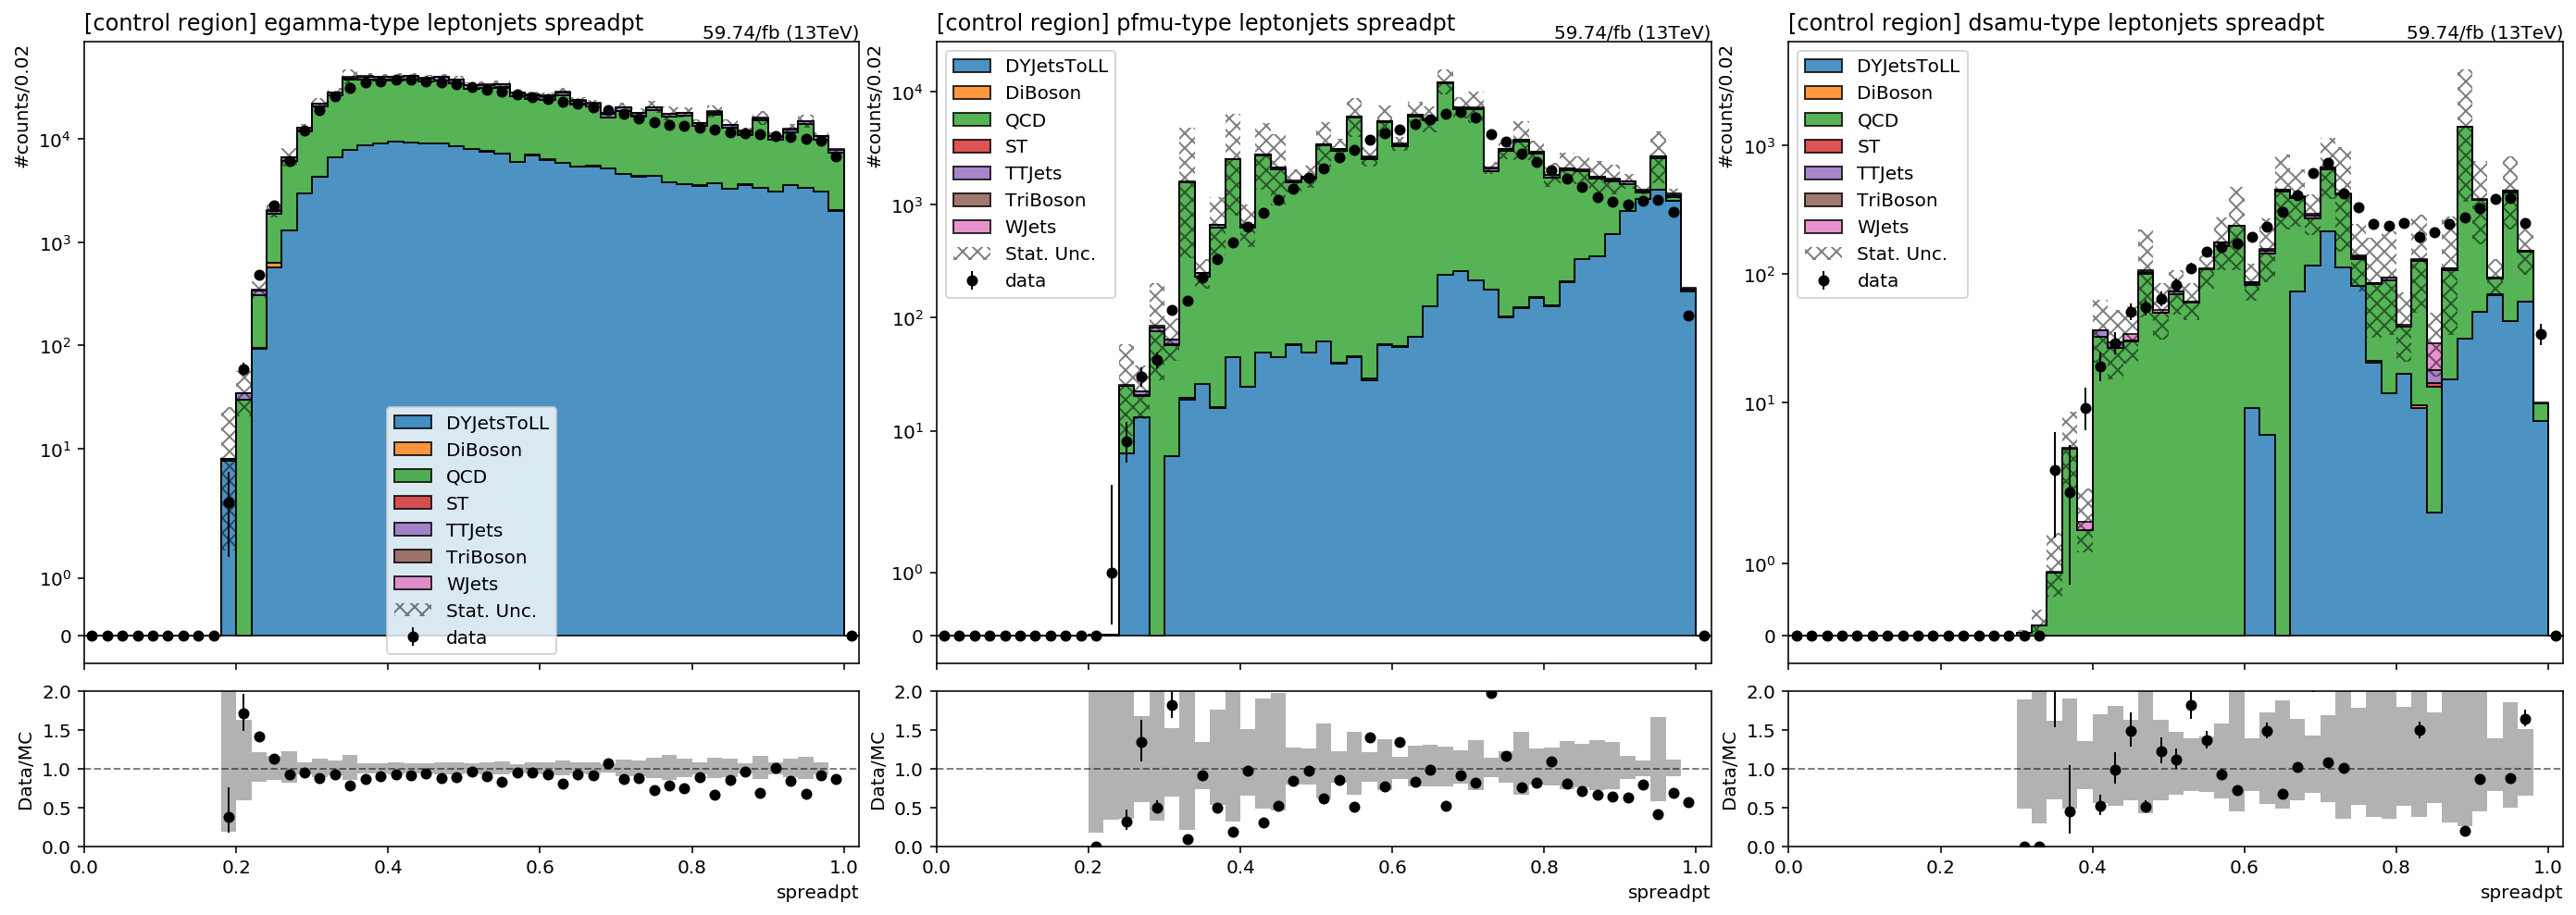

In [37]:
makeplot('subl_spreadpt_cat', 'spreadpt');

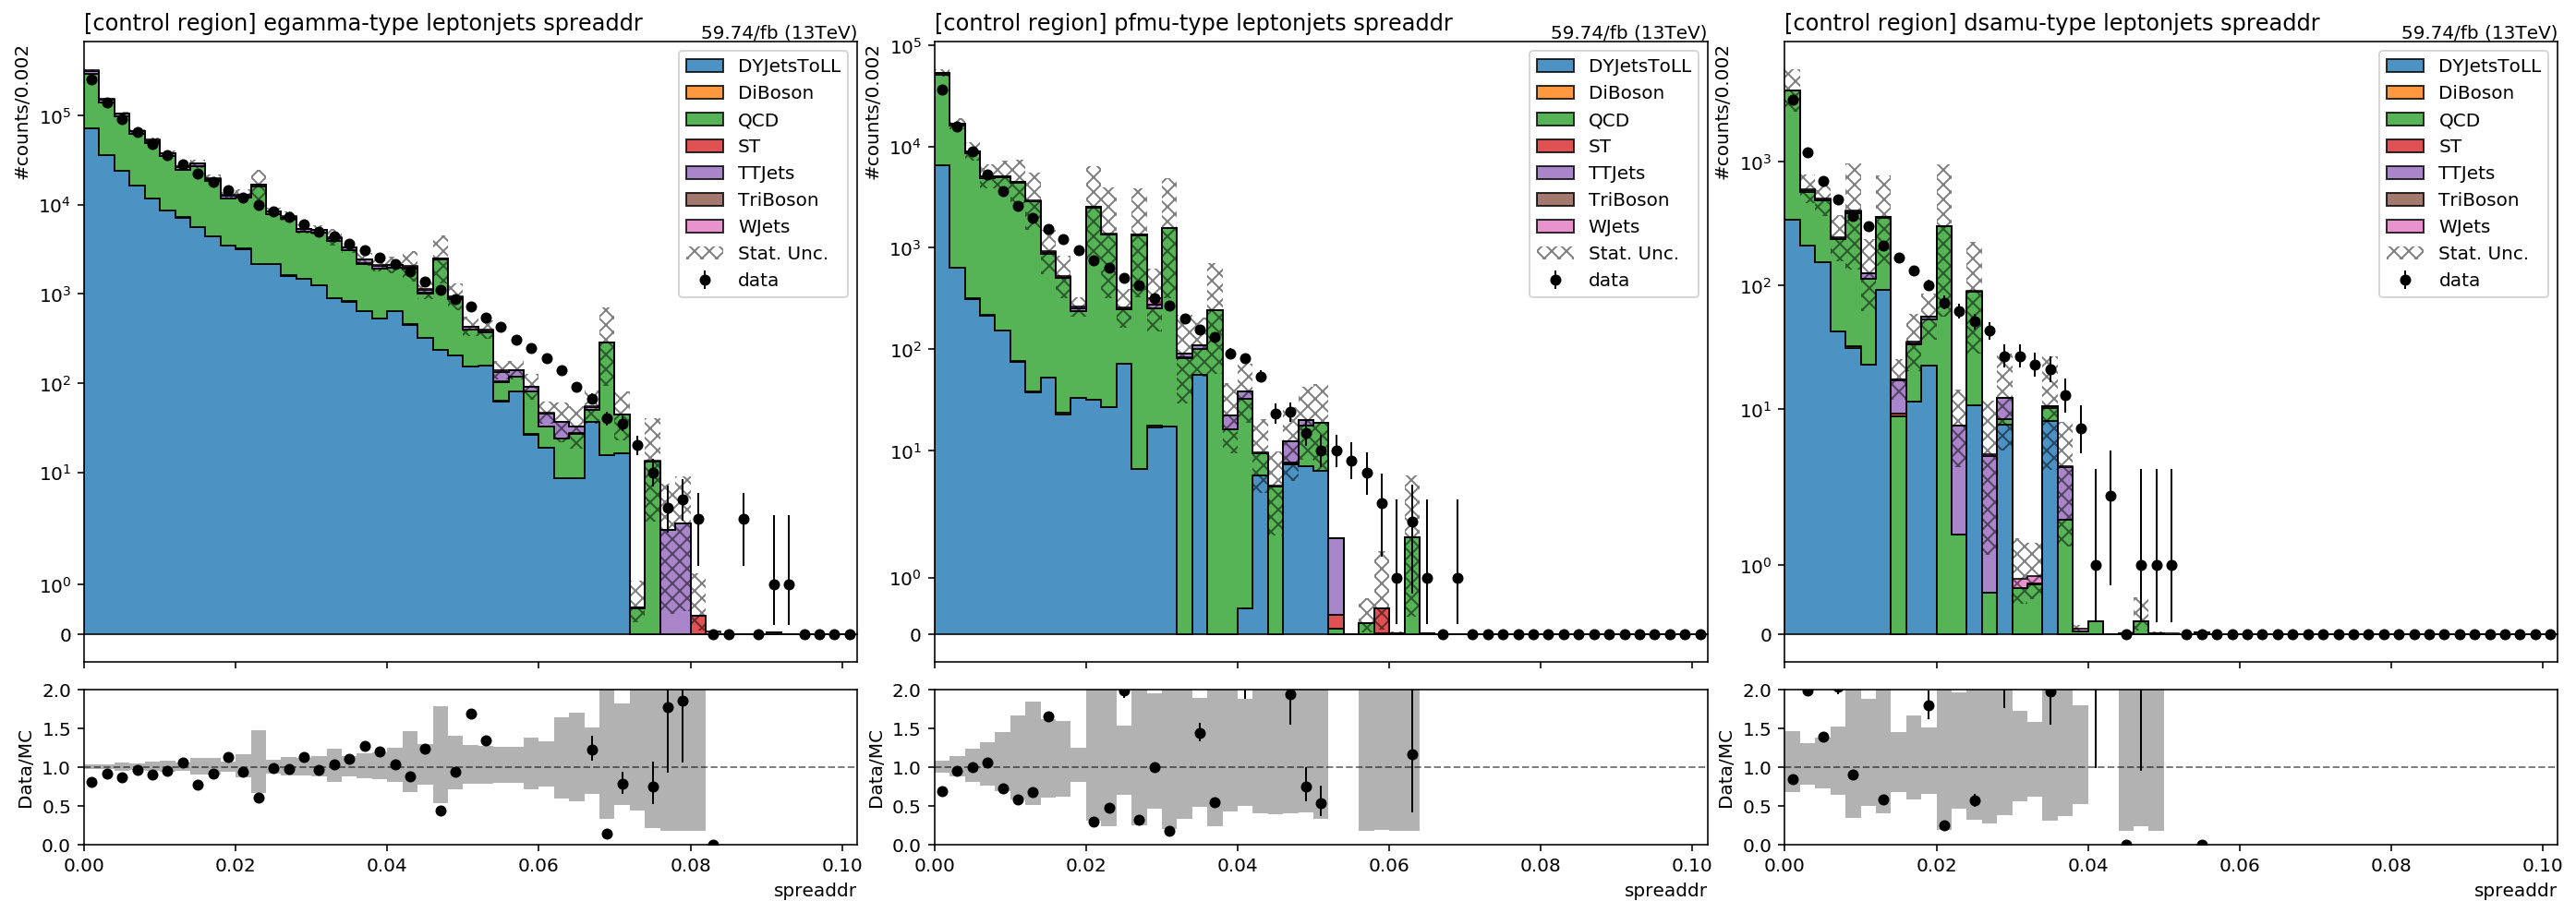

In [38]:
makeplot('subl_spreaddr_cat', 'spreaddr');

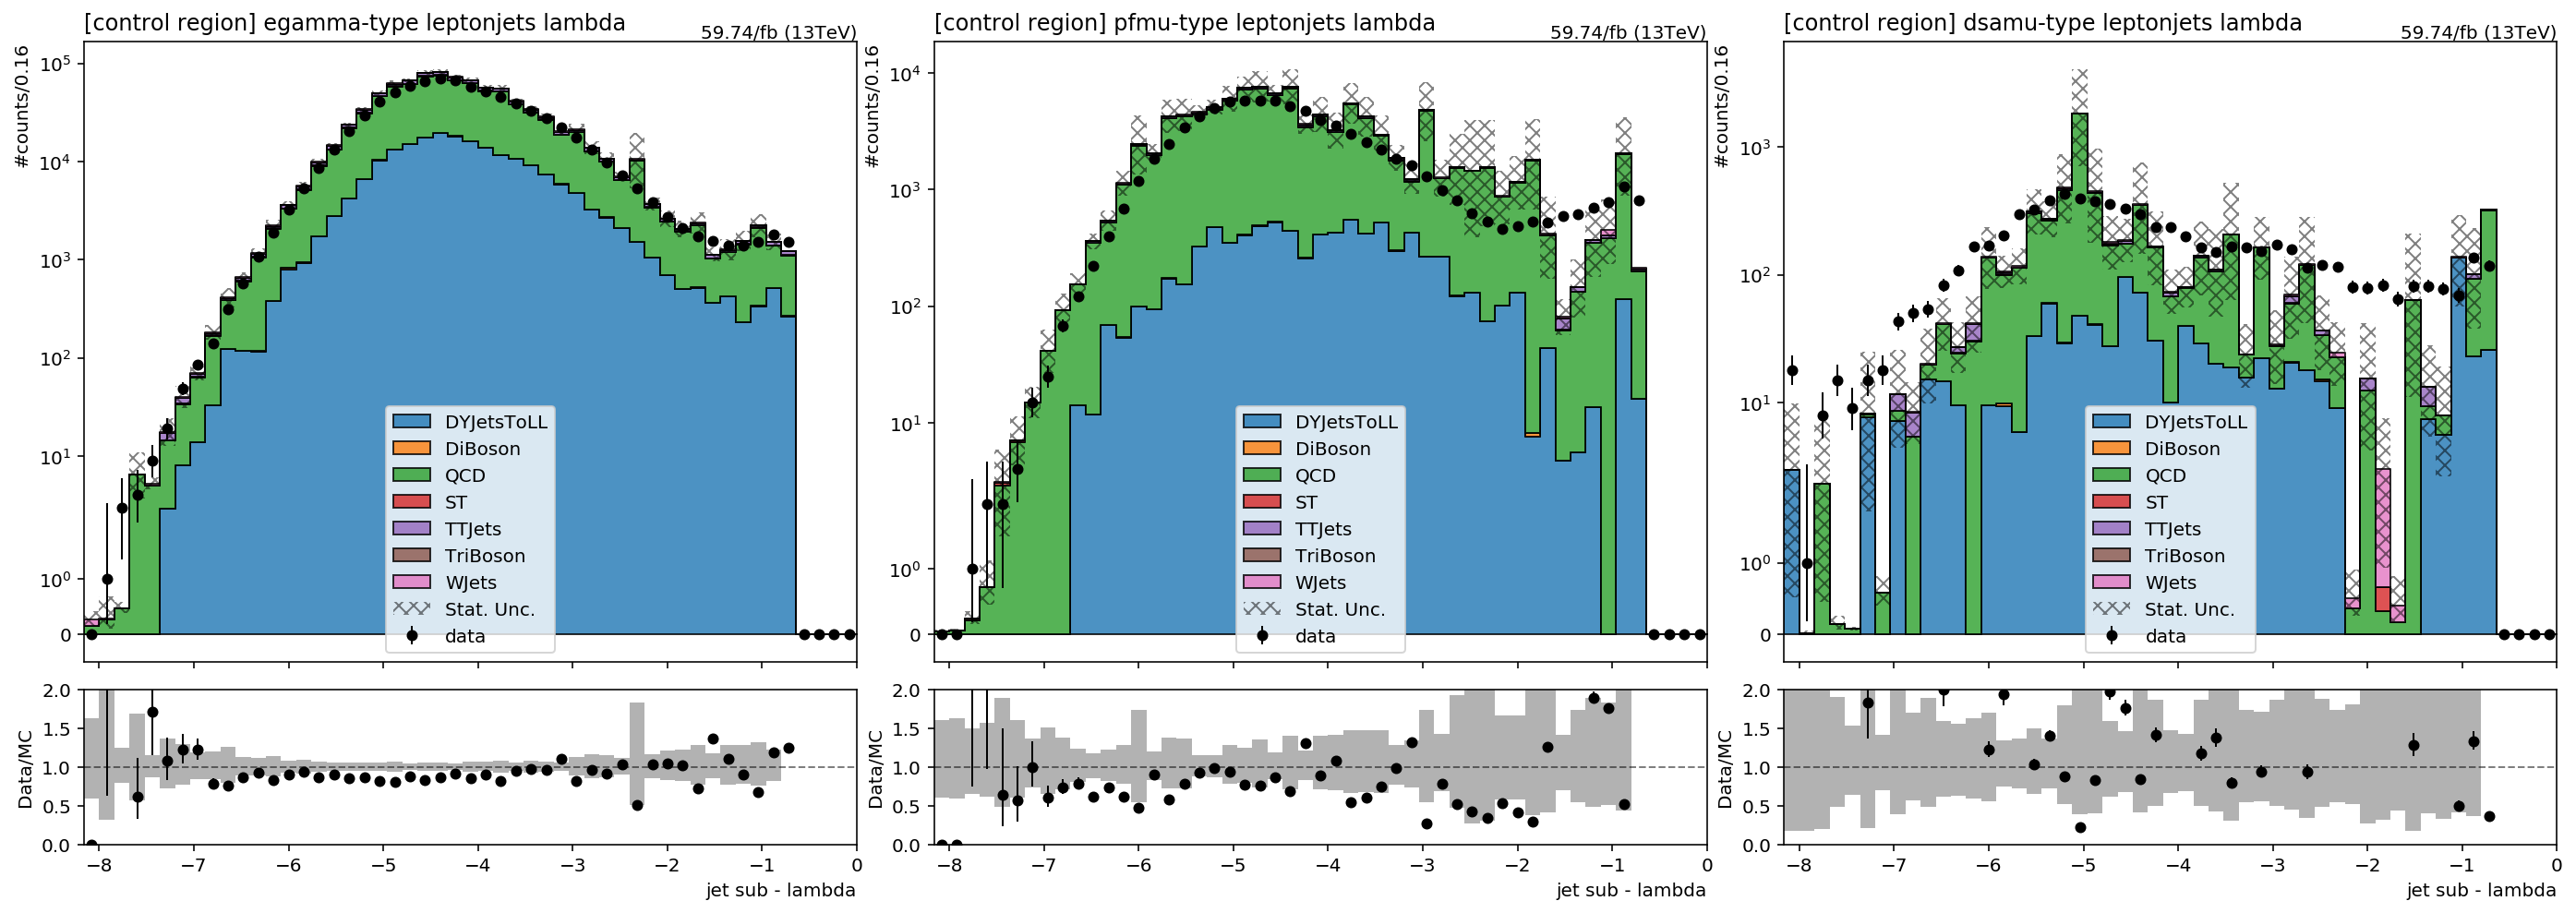

In [39]:
makeplot('subl_lamb_cat', 'lambda', overflow='under');

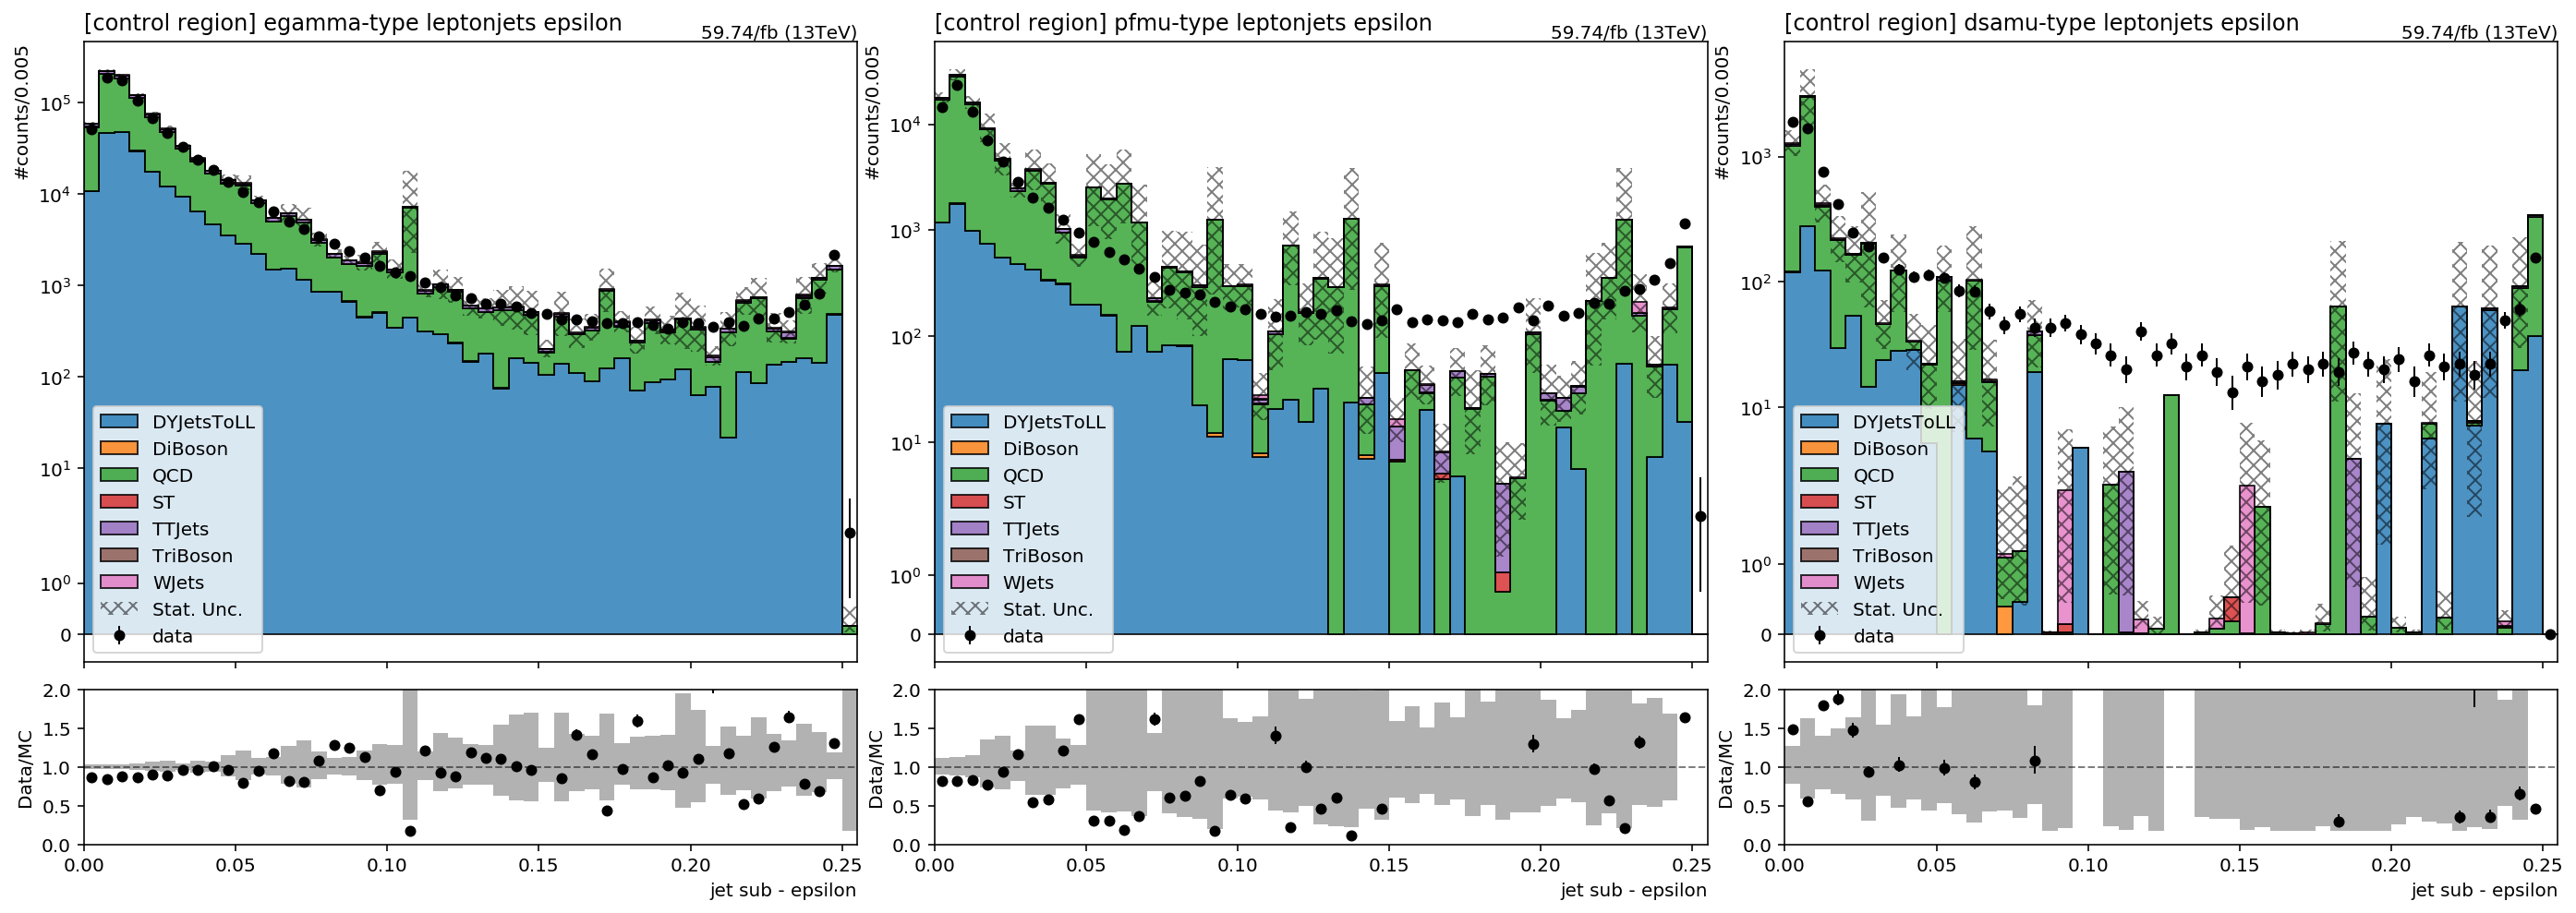

In [40]:
makeplot('subl_epsi_cat', 'epsilon');

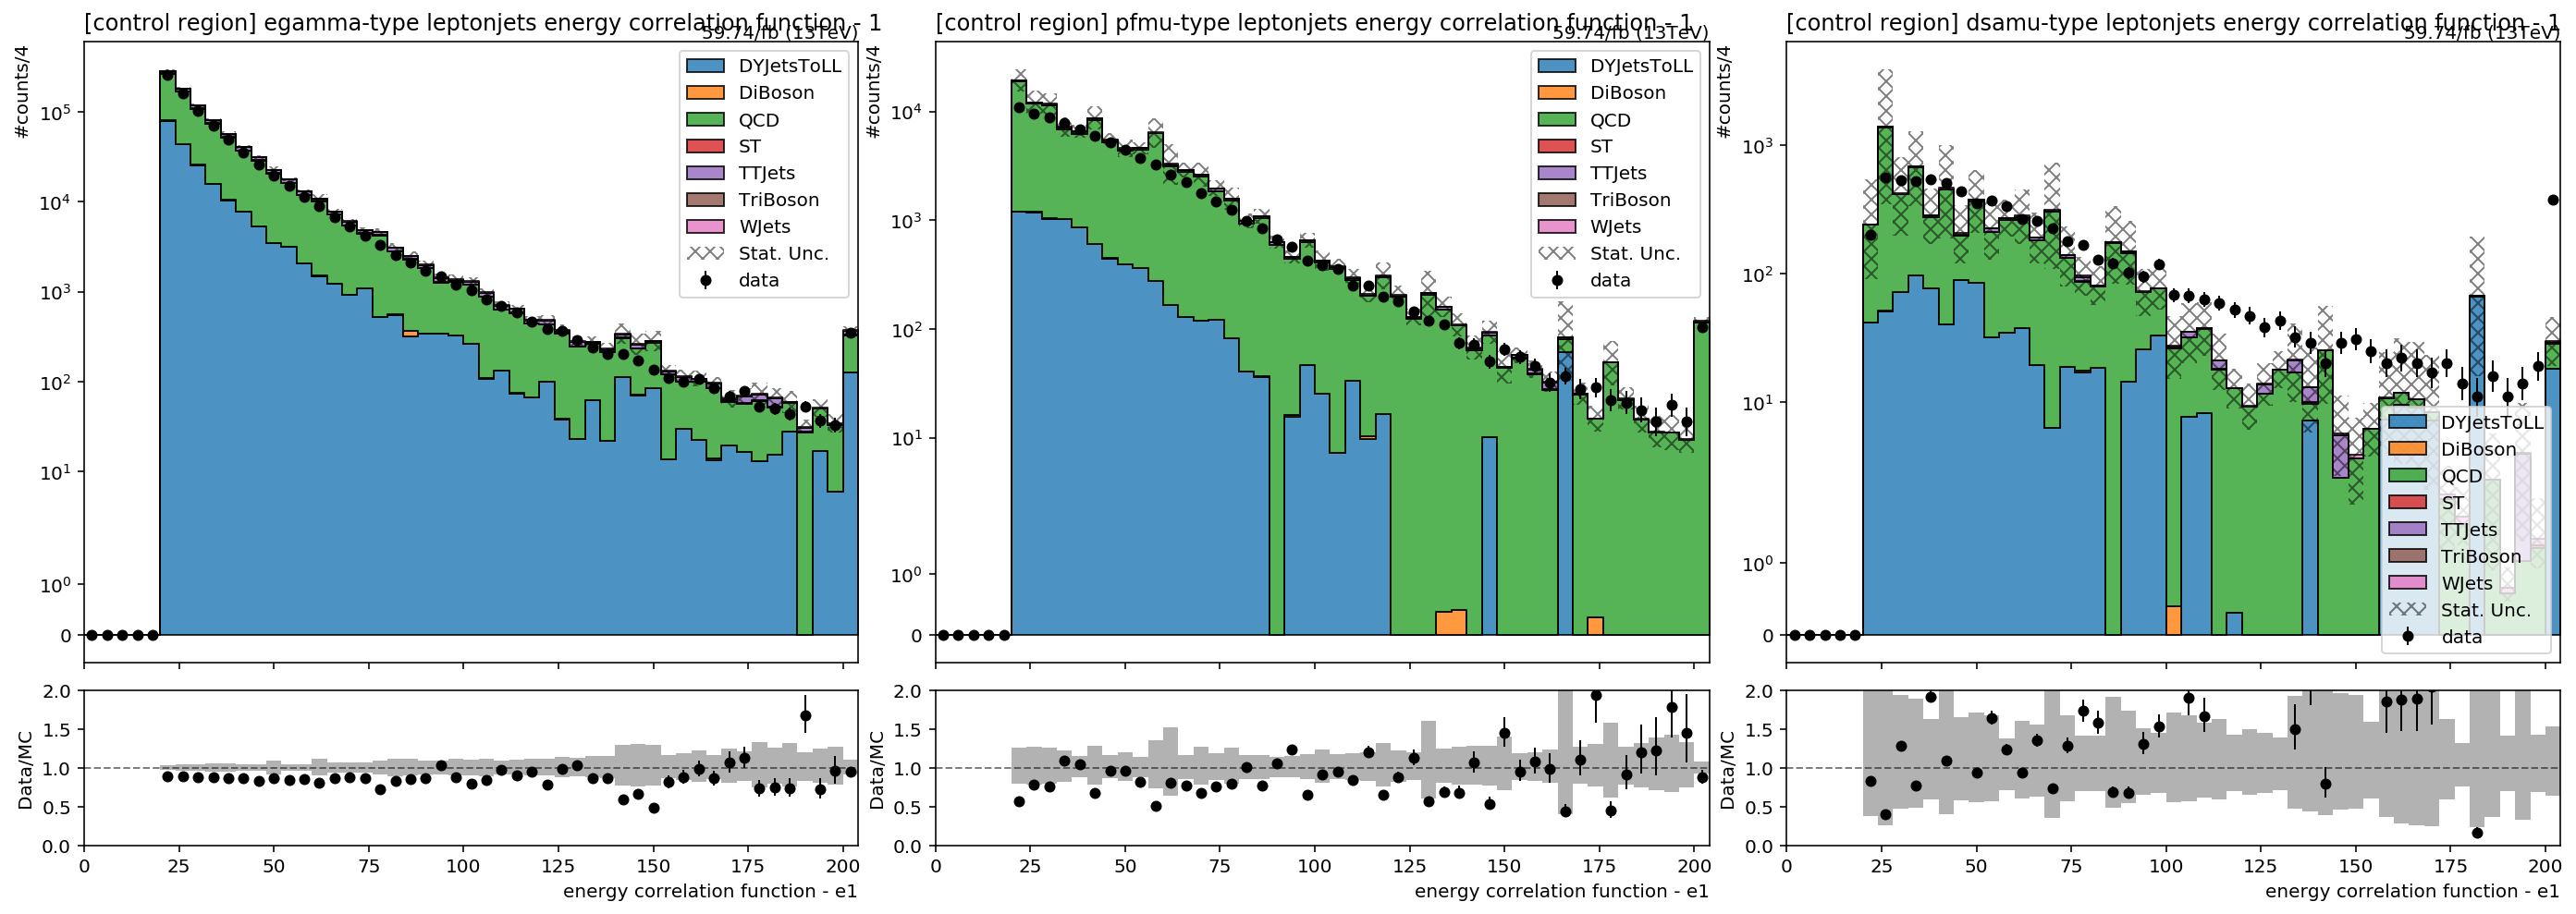

In [41]:
makeplot('subl_ecfe1_cat', 'energy correlation function - 1');

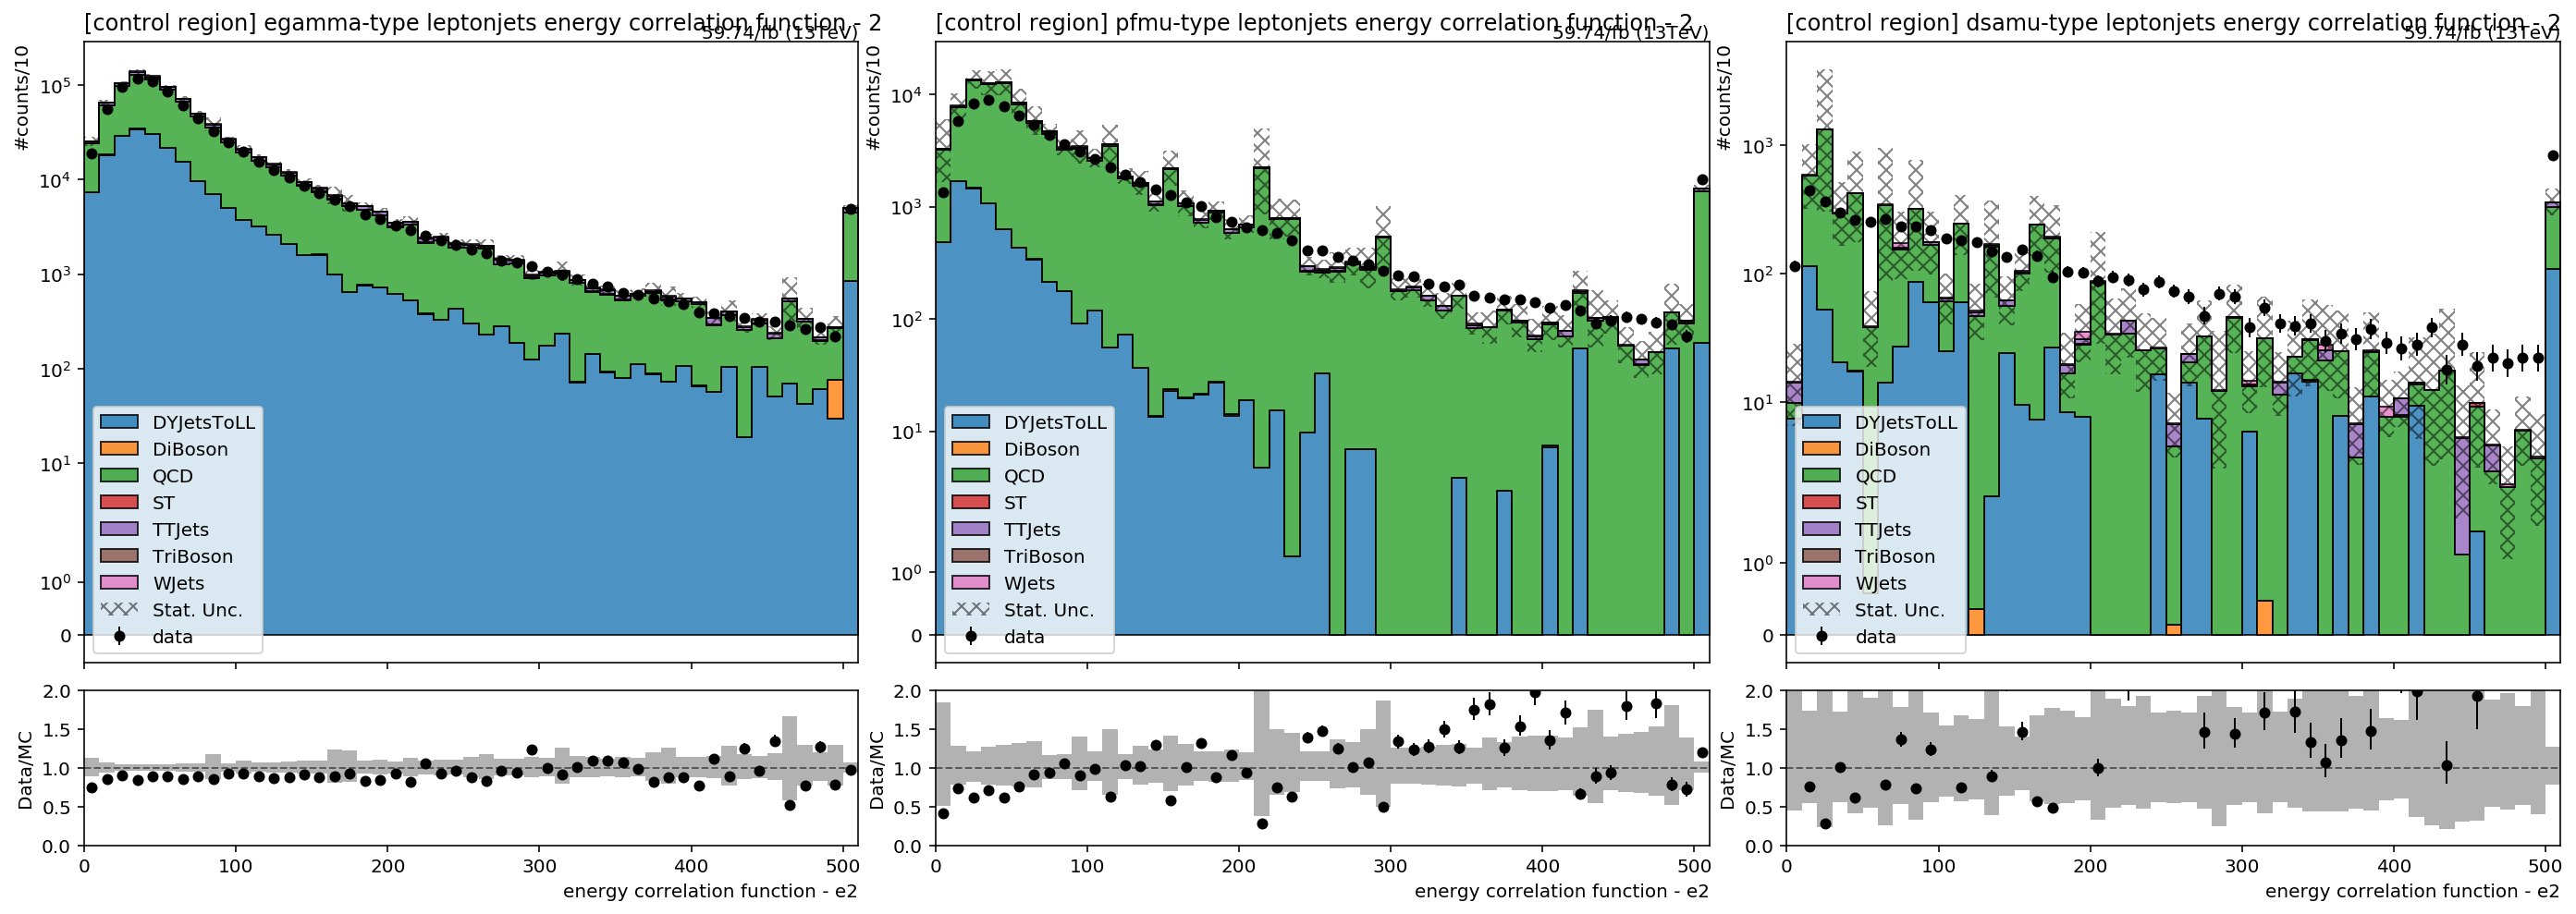

In [42]:
makeplot('subl_ecfe2_cat', 'energy correlation function - 2');

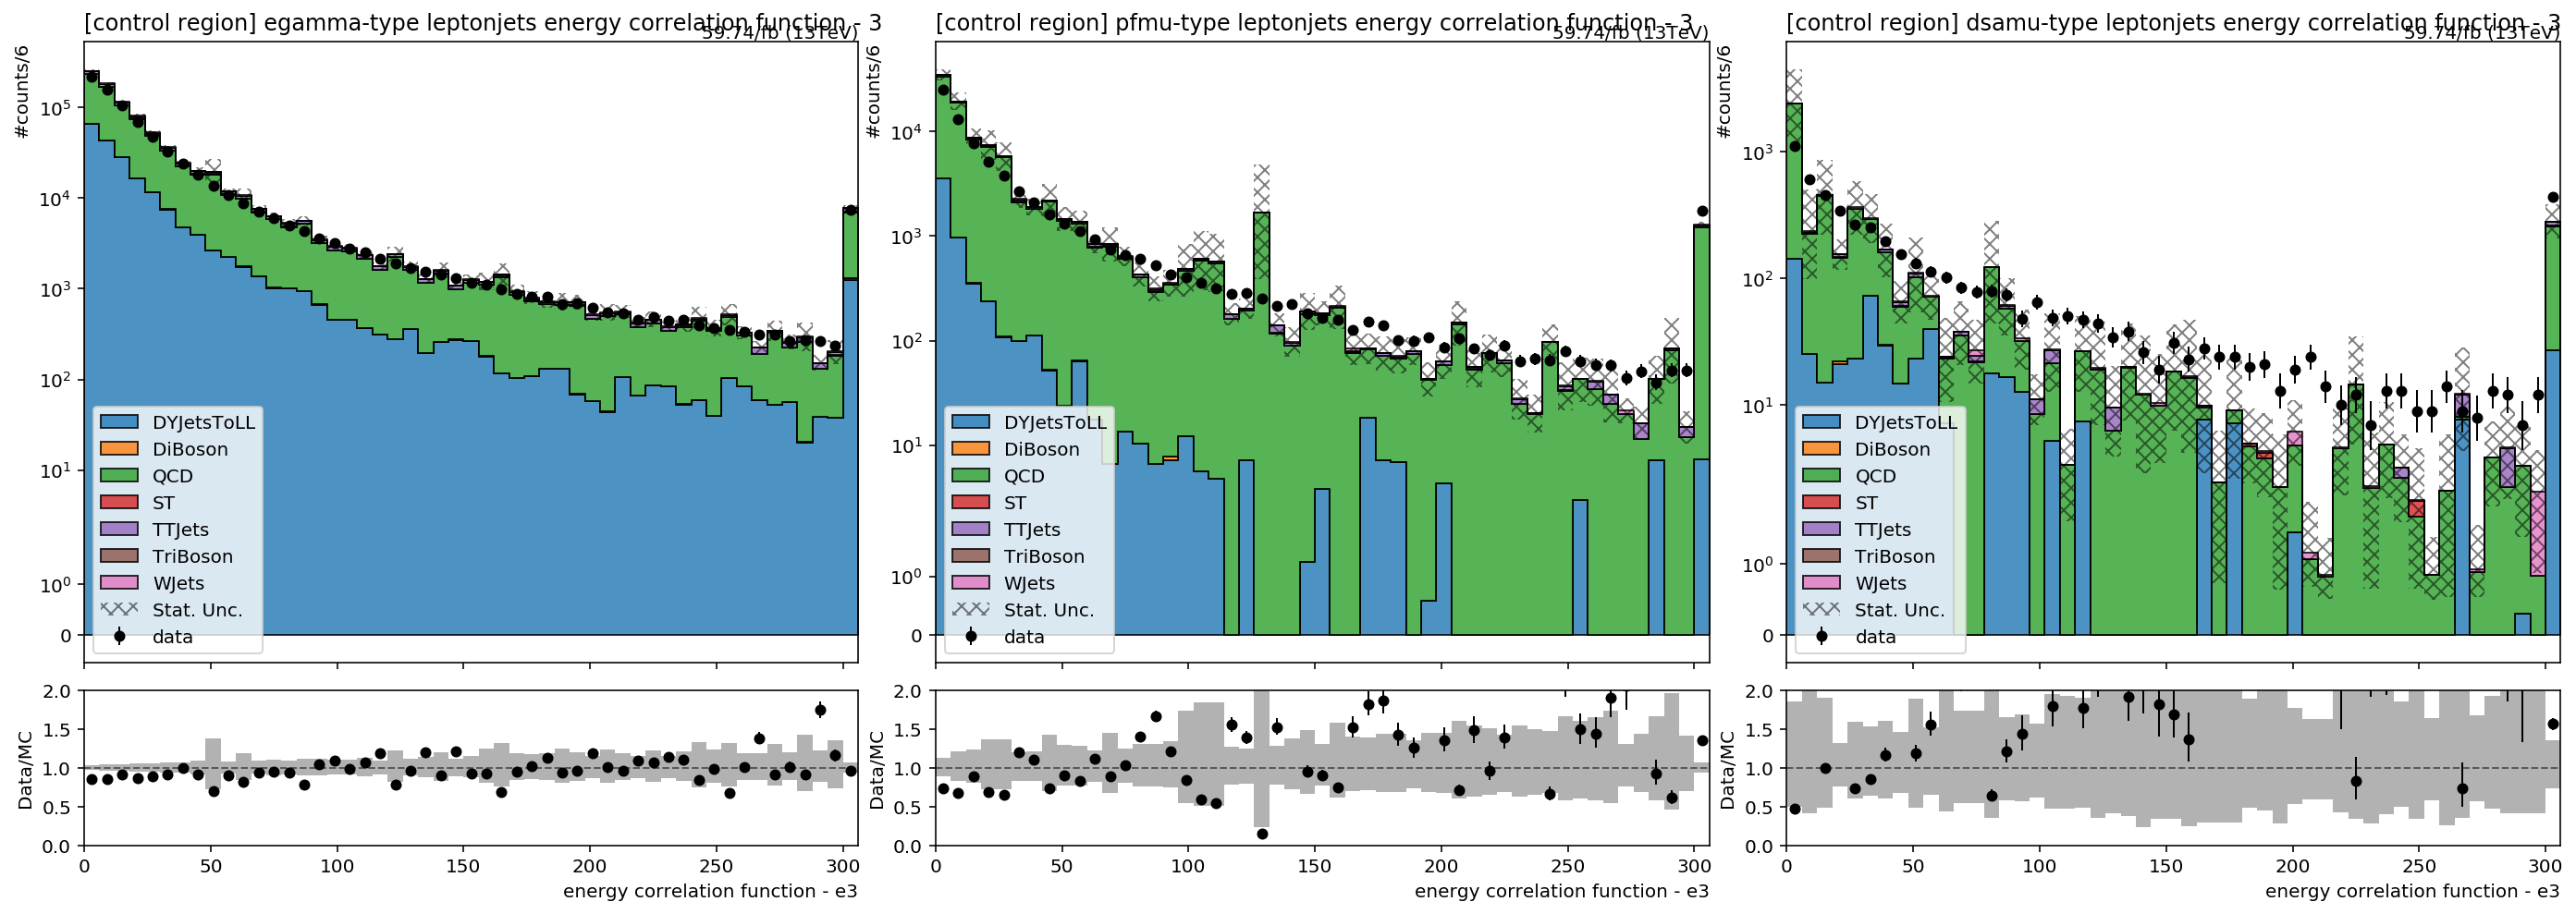

In [43]:
makeplot('subl_ecfe3_cat', 'energy correlation function - 3');

# between the leading two

In [6]:
class TwoLeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        dr_axis = hist.Bin('dr', "$\Delta R$(lead, sublead)", 50, 0, 10)
        
        self._accumulator = processor.dict_accumulator({
            'dr': hist.Hist('Events', dataset_axis, dr_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        dataset = df['dataset']
        if dataset.startswith('TTJets_'): return output # skip TTJets_
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])

            nvtx = df['trueInteractionNum']
            pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
            wgts.add('pileup', pu, puUp, puDown)

            wnlo = np.ones_like(df.size)
            if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
                genparticles = JaggedCandidateArray.candidatesfromcounts(
                    df['gen_p4'],
                    px=df['gen_p4.fCoordinates.fX'],
                    py=df['gen_p4.fCoordinates.fY'],
                    pz=df['gen_p4.fCoordinates.fZ'],
                    energy=df['gen_p4.fCoordinates.fT'],
                    pid=df['gen_pid'],
                )
                gentops = genparticles[np.abs(genparticles.pid)==6]
                genws = genparticles[np.abs(genparticles.pid)==24]
                genzs = genparticles[np.abs(genparticles.pid)==23]

                if 'TTJets' in dataset:
                    wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
                elif 'WJets' in dataset:
                    wnlo = self.nlo_w(genws[0].p4.pt.sum())
                elif 'DYJets' in dataset:
                    wnlo = self.nlo_z(genzs[0].p4.pt.sum())
            wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        absd0 = np.abs(awkward.fromiter(df['pfjet_pfcand_tkD0'])).fillna(0)
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=absd0.max().content,
            mind0=absd0.min().content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size==0: return output
        
        leadingLjPair = leptonjetpair[sumpt.argmax()]
        
        controlregion = (np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5).flatten()
        leadingpair = leadingLjPair[controlregion]
        wgt = wgt[controlregion]

        output['dr'].fill(dataset=dataset,
                          dr=leadingpair.i0.p4.delta_r(leadingpair.i1.p4).flatten(),
                          weight=wgt)

        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [8]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=TwoLeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 7285/7285 [09:53<00:00, 12.28items/s]  


In [9]:
def makeplot2(label, title, overflow='over'):
    fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
    fig.subplots_adjust(hspace=.07)

    hist.plot1d(output[label][notdata],
               overlay='cat',
               ax=ax,
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[label]['data'],
               overlay='cat',
               ax=ax,
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    ax.autoscale(axis='x', tight=True)
    ax.set_yscale('symlog')
    ax.set_xlabel(None)
    leg=ax.legend()

    hist.plotratio(output[label]['data'].sum('cat'),
                   output[label][notdata].sum('cat'),
                  ax=rax,
                  overflow=overflow,
                  error_opts=data_err_opts,
                  denom_fill_opts={},
                  guide_opts={},
                  unc='num')
    rax.set_ylabel('Data/MC')
    rax.set_ylim(0,2)

    rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_title(f'[control region] leading two leptonJets {title}', x=0.0, ha="left")
    ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

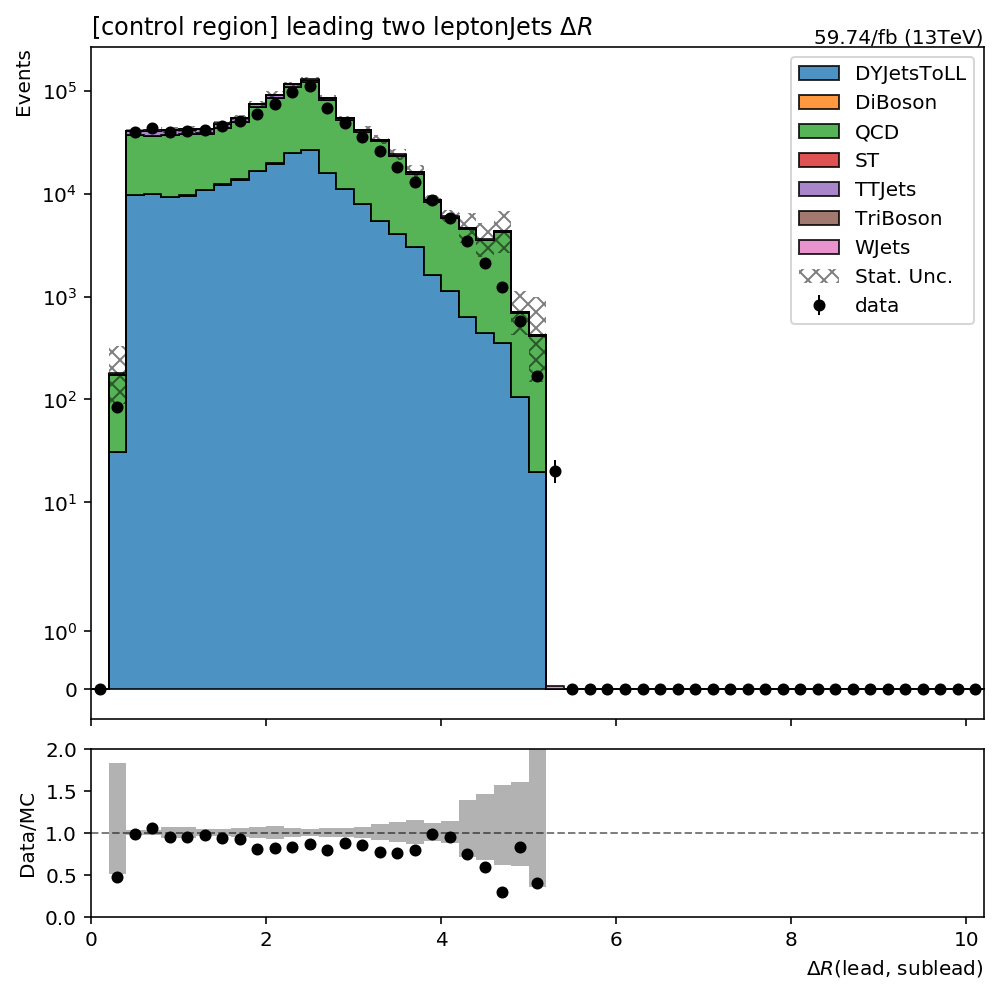

In [10]:
makeplot2('dr_cat', '$\Delta R$');